# Summary

## Annotation differences

- GTEx analyses was perfomed using __Ensembl GRCh38__ while nascent pairs were generated using __RefSeq hg38 p14 (Release GCF_000001405.40-RS_2023_03)__ annotations.

- These differences result is a non-overlapping set of genes (from a quick look, most of the genes are lncRNAs). 

- This means, the denominator for recovered pairs should be based on regions from genes with overlaps.

# Load libraries

In [1]:
library(data.table) ## load files into R faster
library(ggplot2)    ##plotting package
library(dplyr)      ## data structure wrangling
library(cowplot)    ##plots + arrange plots etc
library(parallel)   ##parallel processing
library(grid)
library(gridExtra)
library(svglite)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Metadata

In [2]:
##metadata
metadata_celltype <- data.table::fread('/scratch/Shares/dowell/rutendo/projects/DBNascent_Analysis/data/metadata/human_samples_QC_GC_protocol_filtered.tsv.gz')
dim(metadata_celltype)
head(metadata_celltype)


[1] 751  14

organism   tissue tissue_description                            disease
1 H. sapiens blood  blood; biphenotypic B myelomonocytic leukemia 1      
2 H. sapiens blood  blood; biphenotypic B myelomonocytic leukemia 1      
3 H. sapiens blood  blood; biphenotypic B myelomonocytic leukemia 1      
4 H. sapiens blood  blood; biphenotypic B myelomonocytic leukemia 1      
5 H. sapiens blood  blood; biphenotypic B myelomonocytic leukemia 1      
6 H. sapiens blood  blood; biphenotypic B myelomonocytic leukemia 1      
  srp       paper_id            protocol sample_name sample_type cell_type
1 SRP149838 Aho2019displacement PRO-seq  SRR7266931  cell line   MV4-11   
2 SRP149838 Aho2019displacement PRO-seq  SRR7266932  cell line   MV4-11   
3 SRP149838 Aho2019displacement PRO-seq  SRR7266933  cell line   MV4-11   
4 SRP149838 Aho2019displacement PRO-seq  SRR7266934  cell line   MV4-11   
5 SRP149838 Aho2019displacement PRO-seq  SRR7266935  cell line   MV4-11   
6 SRP149838 Aho2019displacement PRO-seq  SRR7266936  cell line   MV4-11   
  samp_qc_score samp_data_score replicate control_experimental
1 1             2               1         control             
2 2             1               2         control             
3 1             2               1         experimental        
4 1             2               2         experimental        
5 1             2               1         experimental        
6 1             2               2         experimental

In [3]:
tissue_counts <- as.data.frame(table(metadata_celltype$tissue))
tissue_counts

Var1           Freq
1  blood          222 
2  bone             4 
3  brain            6 
4  breast         159 
5  embryo          27 
6  eye              1 
7  heart           22 
8  intestine       47 
9  kidney          63 
10 liver            7 
11 lung            27 
12 multiple        10 
13 muscle           5 
14 ovary            5 
15 prostate        41 
16 skin            27 
17 testis           1 
18 umbilical cord  19 
19 uterus          58

# Explore overlaps 

## Shuffled pairs

In [4]:
## Loading all overlaps
overlap_path <- '/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps'

##get paths
overlap_files <- list.files(path=overlap_path, 
                              pattern="*_shuffled_pair*", 
                                   full.names=TRUE)

overlap_files

[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/blood_shuffled_pair_overlap_summary_2024_September_05_13_21_21.tsv.gz"    
 [2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/breast_shuffled_pair_overlap_summary_2024_September_05_13_21_14.tsv.gz"   
 [3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/heart_shuffled_pair_overlap_summary_2024_September_05_13_21_17.tsv.gz"    
 [4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/heart_shuffled_pair_overlap_summary_2024_September_05_13_34_52.tsv.gz"    
 [5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/intestine_shuffled_pair_overlap_summary_2024_September_05_13_21_16.tsv.gz"
 [6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/intestine_shuffled_pair_overlap_summary_2024_September_05_13_34_58.tsv.gz"
 [7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/kidney_shuffled_pair_overlap_summary_2024_September_05_13_21_08.tsv.gz"   
 [8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/lung_shuffled_pair_overlap_summary_2024_September_05_13_35_00.tsv.gz"     
 [9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/prostate_shuffled_pair_overlap_summary_2024_September_05_13_34_50.tsv.gz" 
[10] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/skin_shuffled_pair_overlap_summary_2024_September_05_13_21_25.tsv.gz"     
[11] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/skin_shuffled_pair_overlap_summary_2024_September_05_13_35_06.tsv.gz"     
[12] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/uterus_shuffled_pair_overlap_summary_2024_September_05_13_34_47.tsv.gz"

In [5]:
##load overlaps
overlap_bed_DT_list <- lapply(overlap_files, 
                                   data.table::fread) 

##merge overlaps
overlap_bed_DT <- do.call(rbind, 
                          overlap_bed_DT_list)
dim(overlap_bed_DT)
head(overlap_bed_DT)

[1] 12000     5

seed_value eqtl_overlap nascent_pair_overlap percent_eqtl
1 1          3739         2699                 1.766980    
2 2          3679         2614                 1.738625    
3 3          3930         2693                 1.857243    
4 4          3897         2707                 1.841648    
5 5          3883         2718                 1.835031    
6 6          3783         2648                 1.787773    
  percent_nascent_pairs
1 0.3789097            
2 0.3669766            
3 0.3780673            
4 0.3800328            
5 0.3815770            
6 0.3717498

In [6]:
bidir_tissue <- c("blood", "breast", "heart", "heart", "intestine","intestine", 
               "kidney","lung", "prostate", "skin", "skin", "uterus")

gtex_tissue <- c("Whole_Blood", "Breast_Mammary_Tissue", "Heart_Atrial_Appendage","Heart_Left_Ventricle",
              "Colon_Sigmoid", "Colon_Transverse", "Kidney_Cortex", "Lung", "Prostate",
              "Skin_Not_Sun_Exposed_Suprapubic", "Skin_Sun_Exposed_Lower_leg", "Uterus")

In [7]:
tissues <- paste0(bidir_tissue, "_", gtex_tissue)
tissues_clean <- paste0(bidir_tissue, " & ", gtex_tissue)
overlap_bed_DT$tissues <- rep(tissues_clean,  each = 1000)
head(overlap_bed_DT)

seed_value eqtl_overlap nascent_pair_overlap percent_eqtl
1 1          3739         2699                 1.766980    
2 2          3679         2614                 1.738625    
3 3          3930         2693                 1.857243    
4 4          3897         2707                 1.841648    
5 5          3883         2718                 1.835031    
6 6          3783         2648                 1.787773    
  percent_nascent_pairs tissues            
1 0.3789097             blood & Whole_Blood
2 0.3669766             blood & Whole_Blood
3 0.3780673             blood & Whole_Blood
4 0.3800328             blood & Whole_Blood
5 0.3815770             blood & Whole_Blood
6 0.3717498             blood & Whole_Blood

## True overlaps

In [8]:
##get paths
all_files <- list.files(path=overlap_path, 
                              pattern="*tsv.gz", 
                                   full.names=TRUE)

true_overlap_files <- base::setdiff(all_files, overlap_files)
true_overlap_files

[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/blood_pair_overlap_summary_2024_September_05_13_21_21.tsv.gz"    
 [2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/breast_pair_overlap_summary_2024_September_05_13_21_14.tsv.gz"   
 [3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/heart_pair_overlap_summary_2024_September_05_13_21_17.tsv.gz"    
 [4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/heart_pair_overlap_summary_2024_September_05_13_34_52.tsv.gz"    
 [5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/intestine_pair_overlap_summary_2024_September_05_13_21_16.tsv.gz"
 [6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/intestine_pair_overlap_summary_2024_September_05_13_34_58.tsv.gz"
 [7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/kidney_pair_overlap_summary_2024_September_05_13_21_08.tsv.gz"   
 [8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/lung_pair_overlap_summary_2024_September_05_13_35_00.tsv.gz"     
 [9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/prostate_pair_overlap_summary_2024_September_05_13_34_50.tsv.gz" 
[10] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/skin_pair_overlap_summary_2024_September_05_13_21_25.tsv.gz"     
[11] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/skin_pair_overlap_summary_2024_September_05_13_35_06.tsv.gz"     
[12] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_gtex_pair_overlaps/uterus_pair_overlap_summary_2024_September_05_13_34_47.tsv.gz"

In [9]:
##load overlaps
true_overlap_bed_DT_list <- lapply(true_overlap_files, 
                                   data.table::fread) 

##merge overlaps
true_overlap_bed_DT <- do.call(rbind, 
                          true_overlap_bed_DT_list)

true_overlap_bed_DT$tissues <- tissues_clean
dim(true_overlap_bed_DT)
head(true_overlap_bed_DT)

[1] 12  7

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1 62488        56050                29.530633    7.868798             
2 28262        24184                20.510476    6.206596             
3 11397         9294                 7.744369    5.969708             
4 10345         8217                 7.661487    5.712637             
5 16381        13615                12.457034    5.356356             
6 18128        15184                12.682865    5.545897             
  p_value_nascent p_value_eqtl tissues                       
1 0.000999001     0.000999001  blood & Whole_Blood           
2 0.000999001     0.000999001  breast & Breast_Mammary_Tissue
3 0.000999001     0.000999001  heart & Heart_Atrial_Appendage
4 0.000999001     0.000999001  heart & Heart_Left_Ventricle  
5 0.000999001     0.000999001  intestine & Colon_Sigmoid     
6 0.000999001     0.000999001  intestine & Colon_Transverse

## Swapped overlaps

In [10]:
## Loading all overlaps
swapped_overlap_path <- '/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps'

##get paths
swapped_overlap_files <- list.files(path=swapped_overlap_path, 
                                    pattern="*_shuffled_pair*", 
                                    full.names=TRUE)

swapped_overlap_files

[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/blood_shuffled_pair_overlap_summary_2024_September_05_13_55_53.tsv.gz"    
 [2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/breast_shuffled_pair_overlap_summary_2024_September_05_13_55_43.tsv.gz"   
 [3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/heart_shuffled_pair_overlap_summary_2024_September_05_13_55_42.tsv.gz"    
 [4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/heart_shuffled_pair_overlap_summary_2024_September_05_14_04_53.tsv.gz"    
 [5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/intestine_shuffled_pair_overlap_summary_2024_September_05_13_55_45.tsv.gz"
 [6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/intestine_shuffled_pair_overlap_summary_2024_September_05_14_04_54.tsv.gz"
 [7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/kidney_shuffled_pair_overlap_summary_2024_September_05_13_55_35.tsv.gz"   
 [8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/lung_shuffled_pair_overlap_summary_2024_September_05_14_05_01.tsv.gz"     
 [9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/prostate_shuffled_pair_overlap_summary_2024_September_05_14_04_53.tsv.gz" 
[10] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/skin_shuffled_pair_overlap_summary_2024_September_05_13_55_52.tsv.gz"     
[11] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/skin_shuffled_pair_overlap_summary_2024_September_05_14_05_04.tsv.gz"     
[12] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/uterus_shuffled_pair_overlap_summary_2024_September_05_14_04_49.tsv.gz"

In [11]:
##get paths
swapped_all_files <- list.files(path=swapped_overlap_path, 
                              pattern="*tsv.gz", 
                                   full.names=TRUE)

swapped_true_overlap_files <- base::setdiff(swapped_all_files, 
                                            swapped_overlap_files)
swapped_true_overlap_files

[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/blood_pair_overlap_summary_2024_September_05_13_55_53.tsv.gz"    
 [2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/breast_pair_overlap_summary_2024_September_05_13_55_43.tsv.gz"   
 [3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/heart_pair_overlap_summary_2024_September_05_13_55_42.tsv.gz"    
 [4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/heart_pair_overlap_summary_2024_September_05_14_04_53.tsv.gz"    
 [5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/intestine_pair_overlap_summary_2024_September_05_13_55_45.tsv.gz"
 [6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/intestine_pair_overlap_summary_2024_September_05_14_04_54.tsv.gz"
 [7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/kidney_pair_overlap_summary_2024_September_05_13_55_35.tsv.gz"   
 [8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/lung_pair_overlap_summary_2024_September_05_14_05_01.tsv.gz"     
 [9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/prostate_pair_overlap_summary_2024_September_05_14_04_53.tsv.gz" 
[10] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/skin_pair_overlap_summary_2024_September_05_13_55_52.tsv.gz"     
[11] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/skin_pair_overlap_summary_2024_September_05_14_05_04.tsv.gz"     
[12] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_shuffled_gtex_pair_overlaps/uterus_pair_overlap_summary_2024_September_05_14_04_49.tsv.gz"

In [12]:
##load overlaps
swapped_true_overlap_bed_DT_list <- lapply(swapped_true_overlap_files, 
                                   data.table::fread) 

##merge overlaps
swapped_true_overlap_bed_DT <- do.call(rbind, 
                          swapped_true_overlap_bed_DT_list)

swapped_true_overlap_bed_DT$tissues <- tissues_clean
dim(swapped_true_overlap_bed_DT)
print(swapped_true_overlap_bed_DT)

[1] 12  7

    eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
           <int>                <int>        <num>                 <num>
 1:        28241                23606    13.346156              6.790846
 2:        10039                 8137     7.285566              5.652186
 3:         8212                 7081     5.580131              5.430298
 4:         7303                 6238     5.408588              5.260805
 5:         5677                 4413     4.317110              4.816056
 6:         6388                 4977     4.469227              5.002463
 7:          463                  328     4.663108              3.424157
 8:         2837                 2220     1.486500              6.314891
 9:         3644                 2926     5.052130              4.469359
10:         4113                 3348     1.885728              6.595225
11:         4820                 3993     1.922003              7.078909
12:         1345                 1009     4.489769 

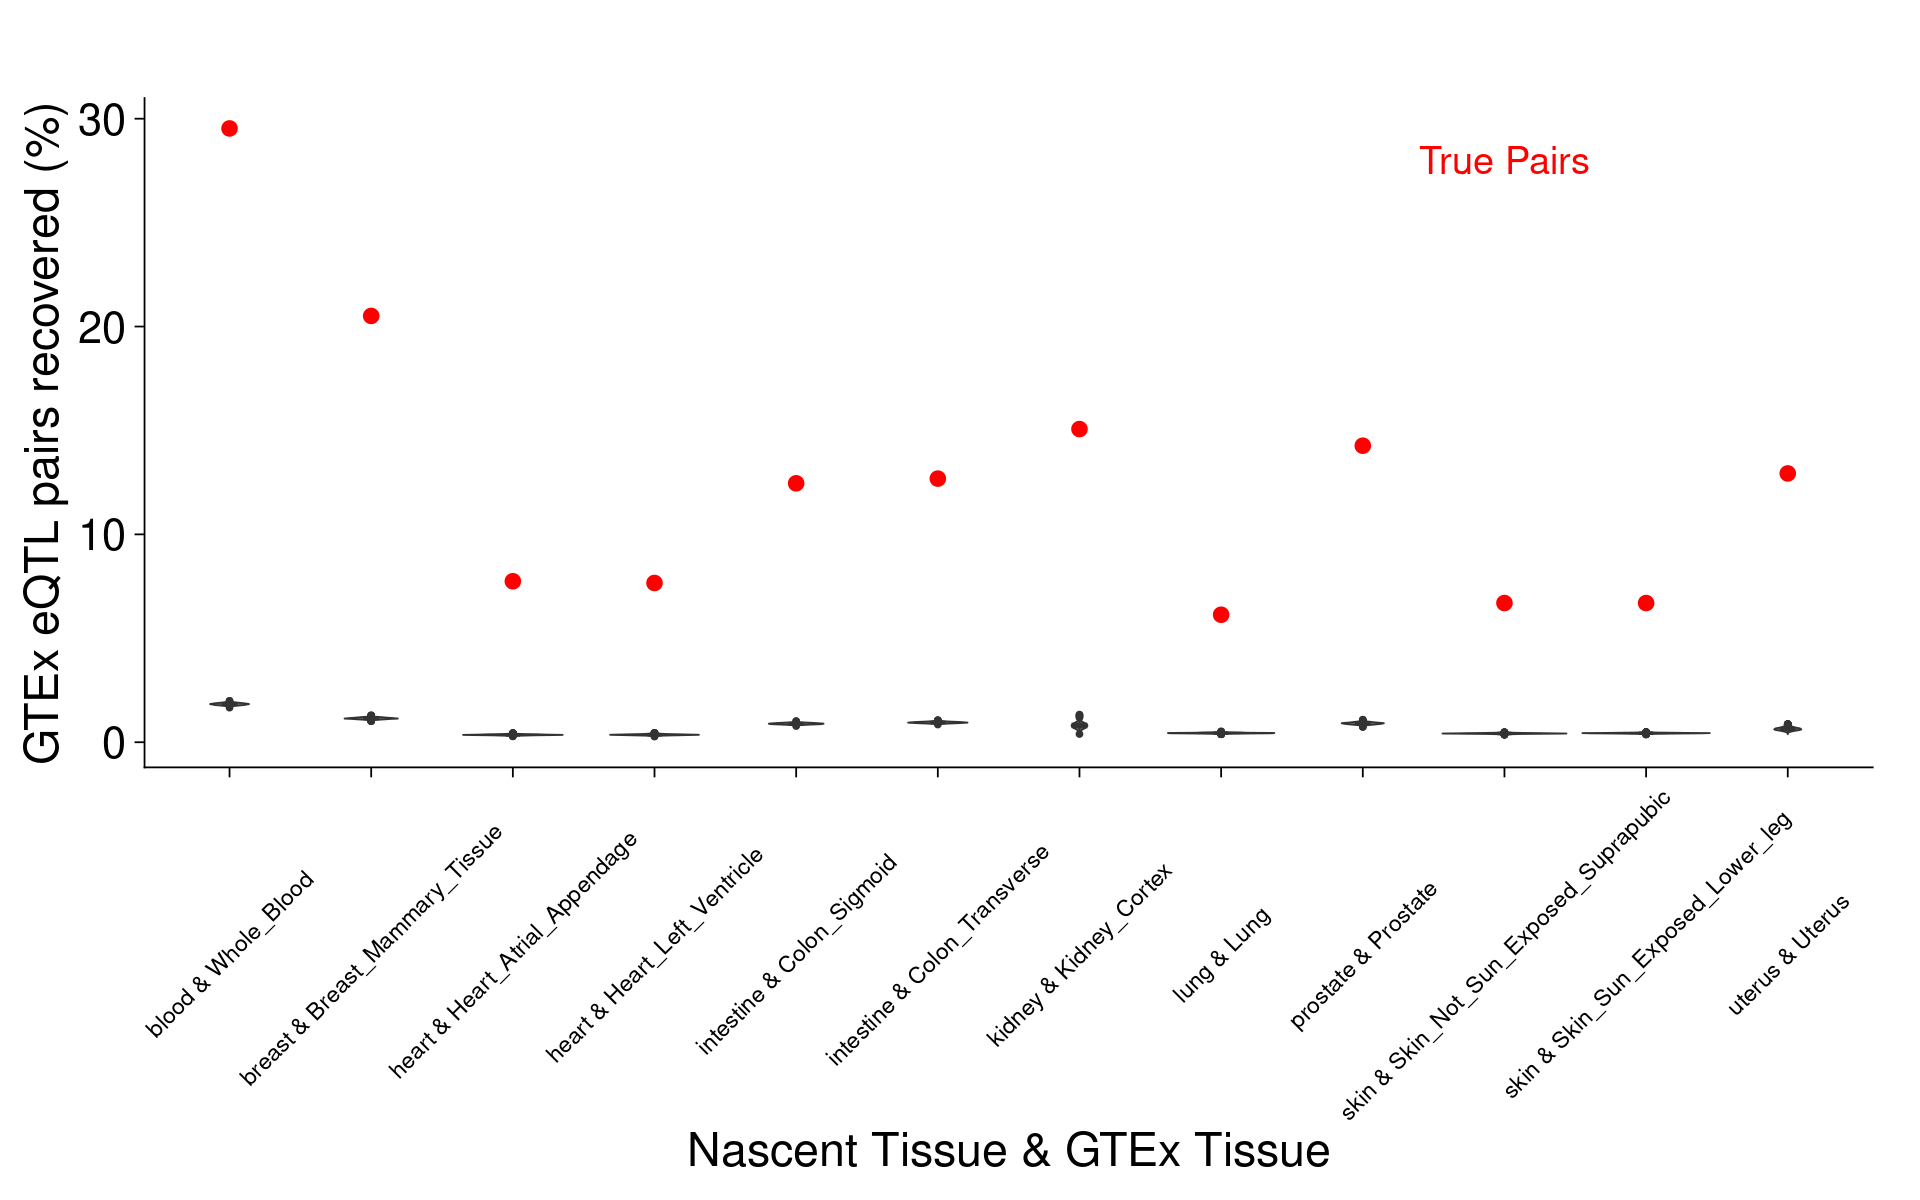

In [13]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot <- ggplot(overlap_bed_DT, aes(x=tissues, y=percent_eqtl)) +
  geom_violin(trim=FALSE, fill='gray40', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=percent_eqtl),
           size=4,
           color="red", 
           alpha=1) +
labs(title = " ", 
       y = "GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=10, 
         y=28, 
         size=8,
         label="True Pairs",
         color="red") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot

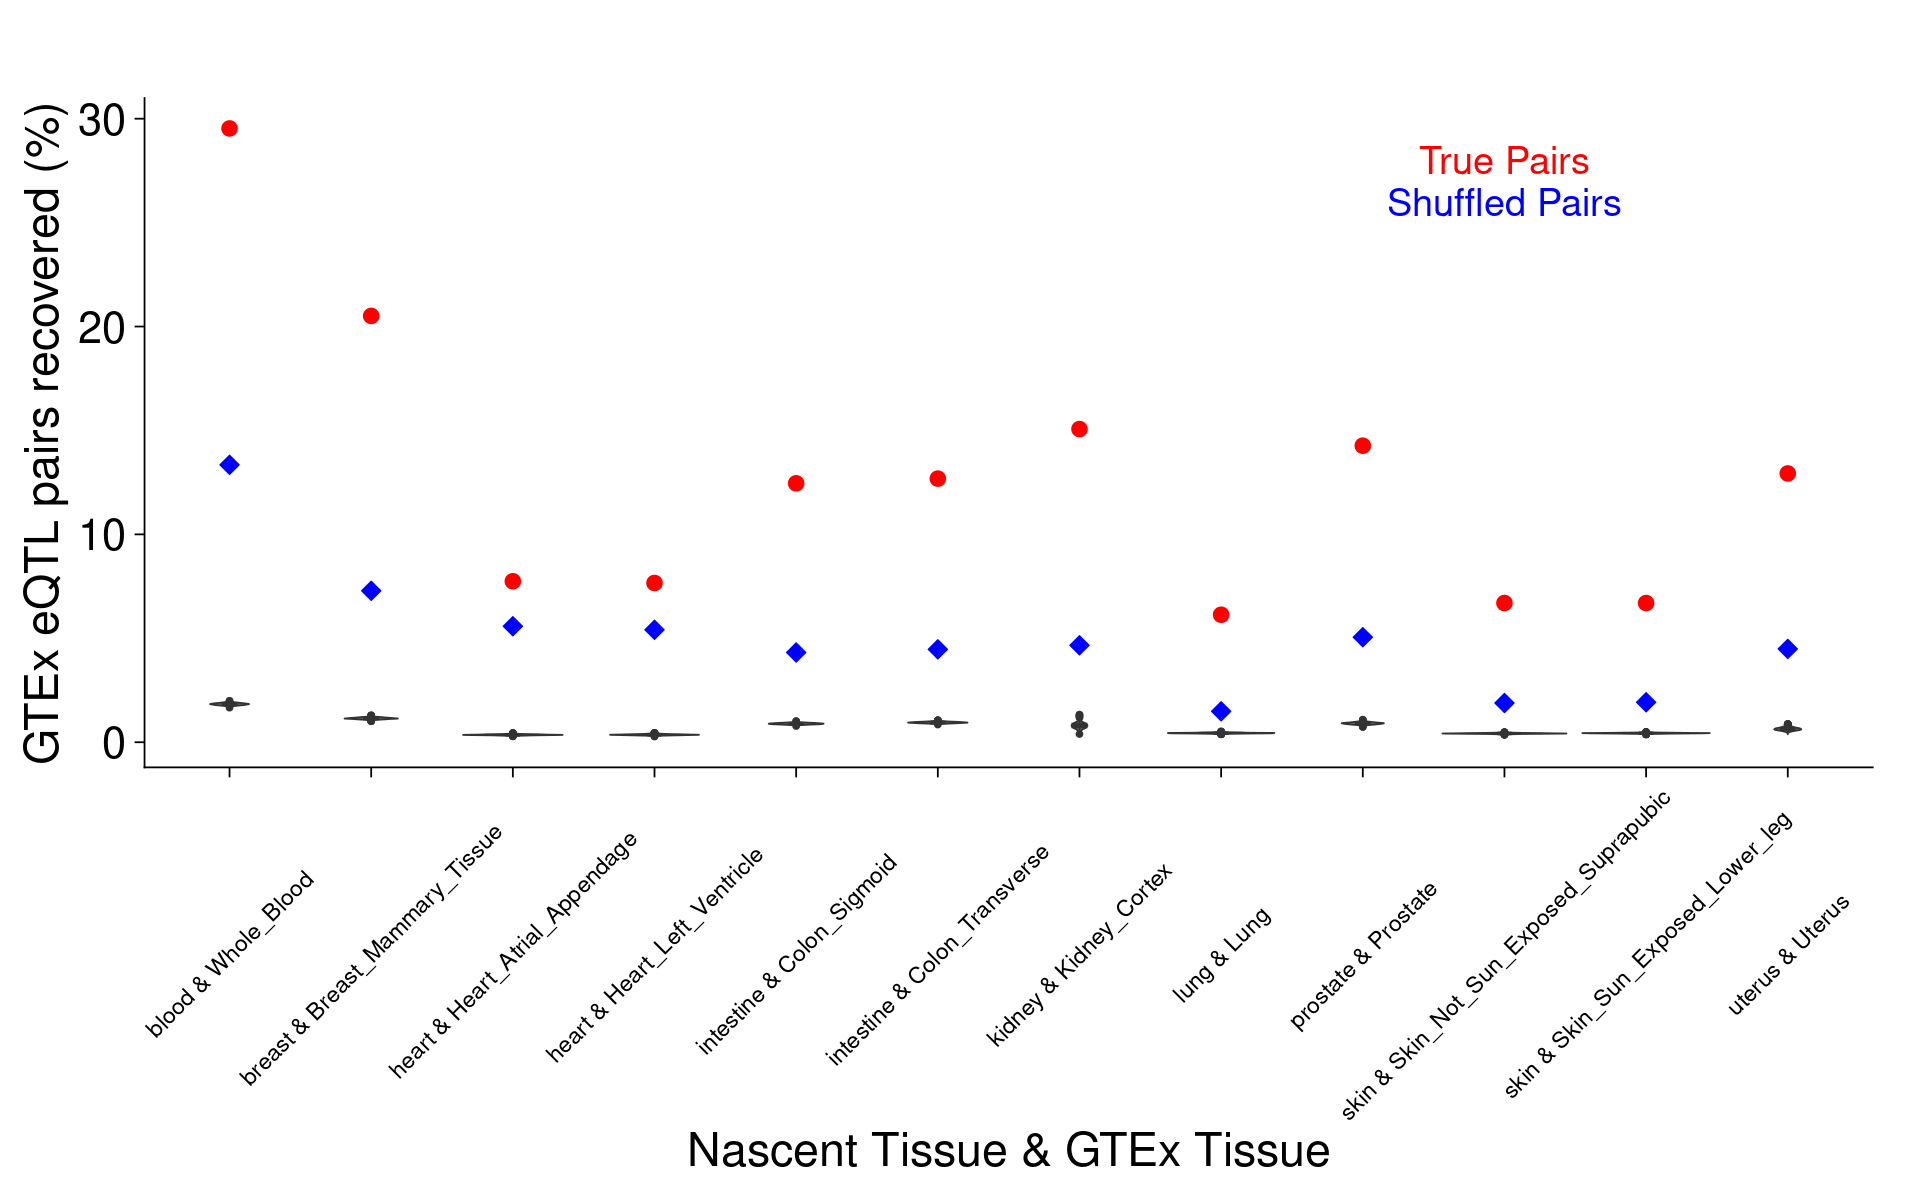

In [14]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot1 <- ggplot(overlap_bed_DT, aes(x=tissues, y=percent_eqtl)) +
  geom_violin(trim=FALSE, fill='gray40', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=percent_eqtl),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=percent_eqtl),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
labs(title = " ", 
       y = "GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=10, 
         y=28, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=10, 
         y=26, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot1

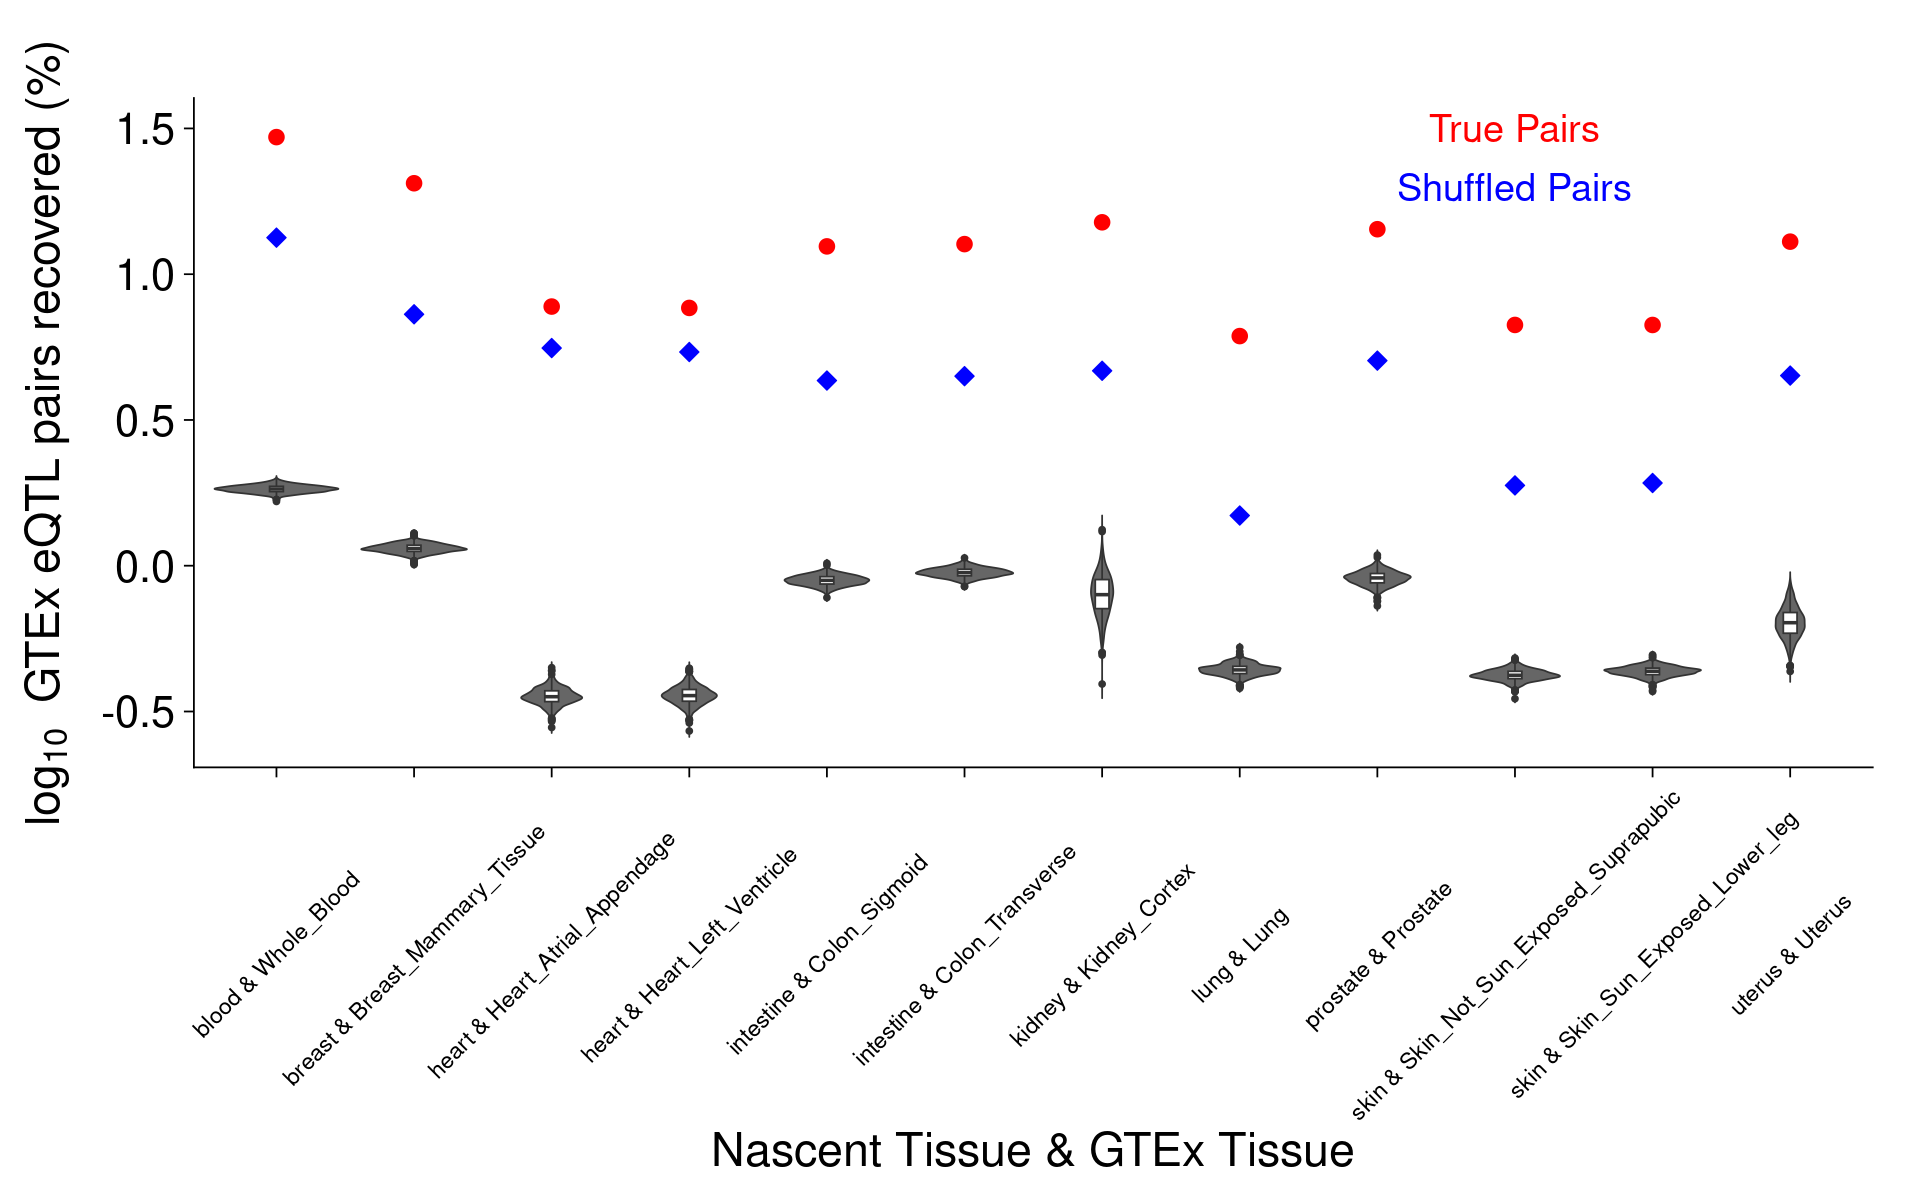

In [15]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray40', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=10, 
         y=1.5, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=10, 
         y=1.3, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log

In [16]:
overlap_bed_DT$tissues <- factor(overlap_bed_DT$tissues,
                                 levels=unique(overlap_bed_DT[(order(overlap_bed_DT$percent_eqtl)),]$tissues))

true_overlap_bed_DT$tissues <- factor(true_overlap_bed_DT$tissues,
                                 levels=unique(overlap_bed_DT[(order(overlap_bed_DT$percent_eqtl)),]$tissues))

swapped_true_overlap_bed_DT$tissues <- factor(swapped_true_overlap_bed_DT$tissues,
                                 levels=unique(overlap_bed_DT[(order(overlap_bed_DT$percent_eqtl)),]$tissues))

In [17]:
head(swapped_true_overlap_bed_DT, 3)

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1 28241        23606                13.346156    6.790846             
2 10039         8137                 7.285566    5.652186             
3  8212         7081                 5.580131    5.430298             
  p_value_nascent p_value_eqtl tissues                       
1 0.000999001     0.000999001  blood & Whole_Blood           
2 0.000999001     0.000999001  breast & Breast_Mammary_Tissue
3 0.000999001     0.000999001  heart & Heart_Atrial_Appendage

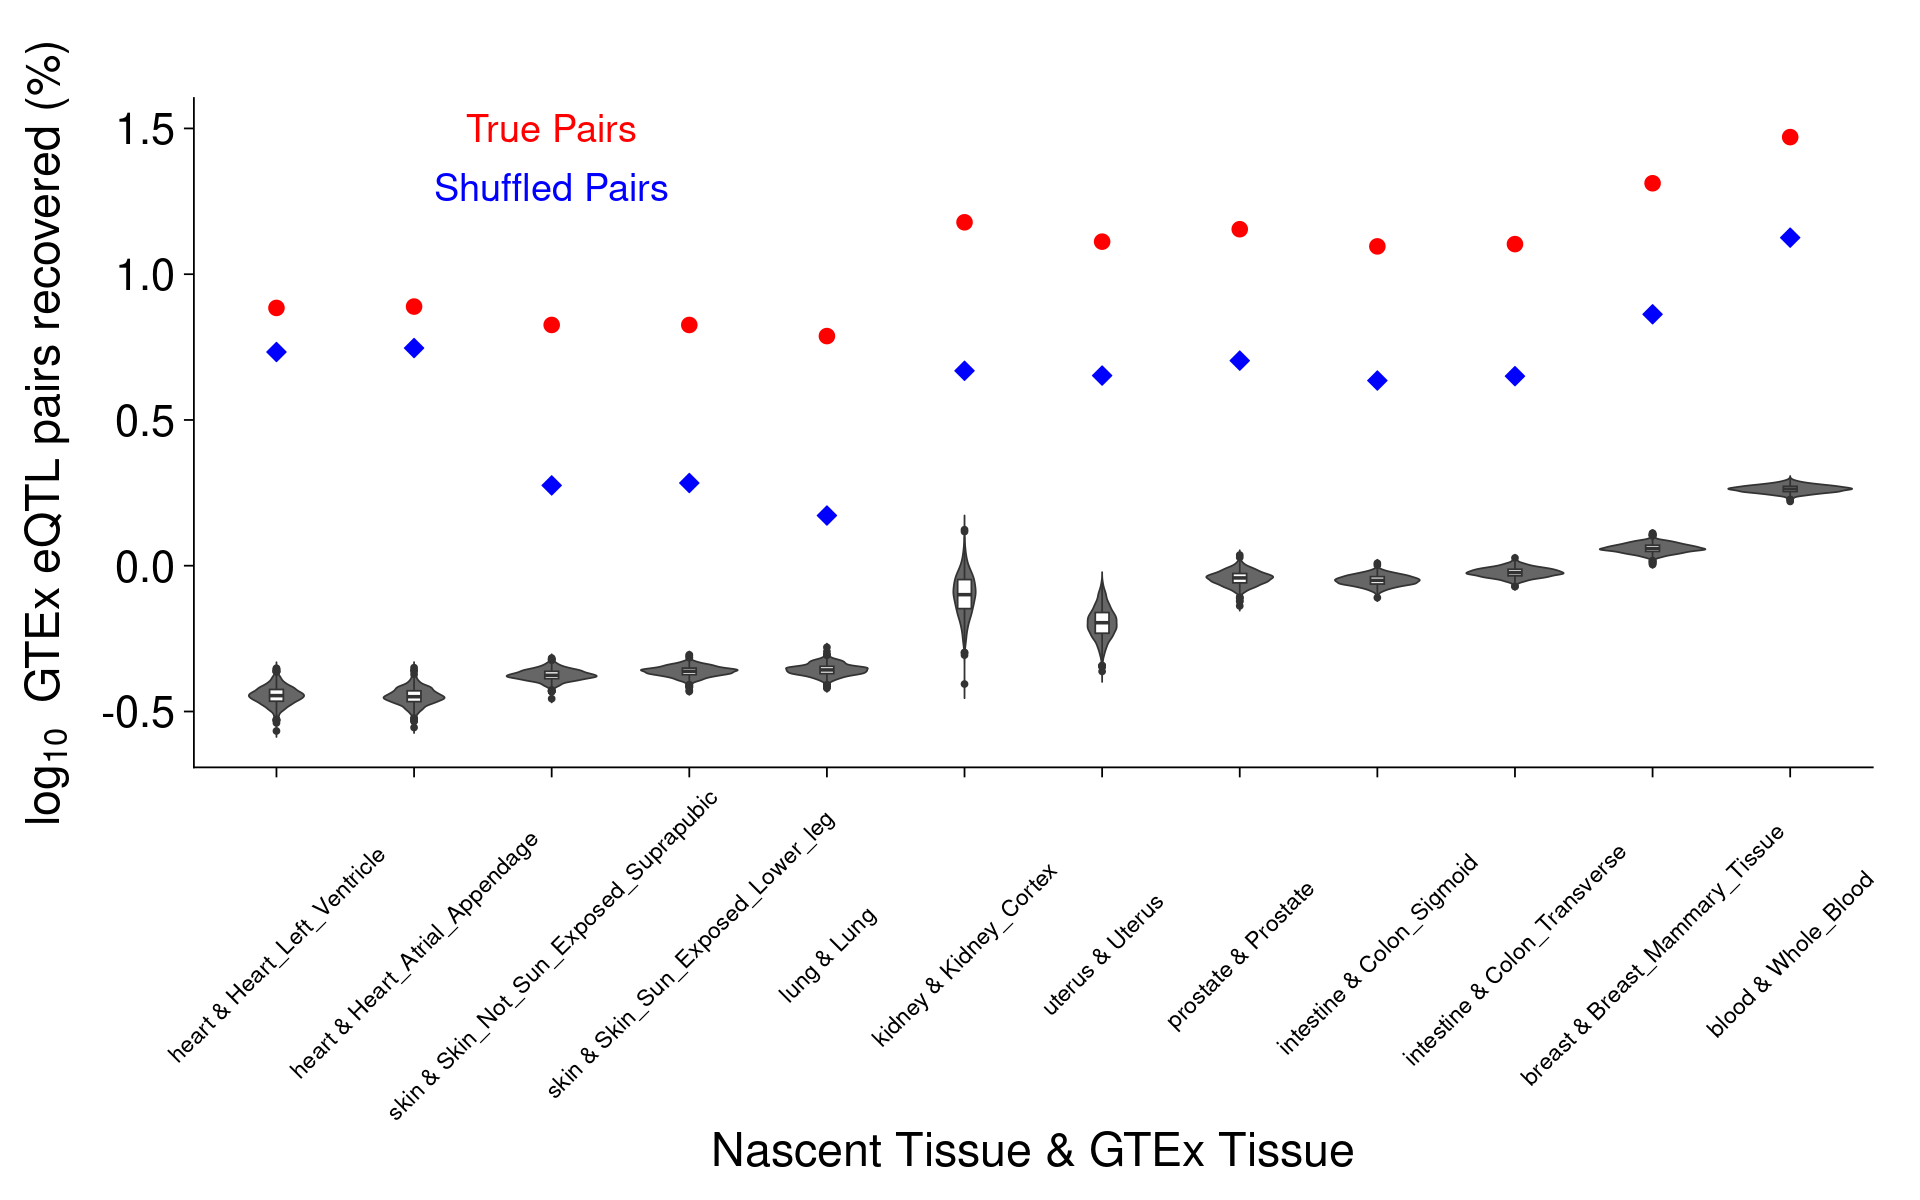

In [18]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sort <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray40', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=3, 
         y=1.5, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=3, 
         y=1.3, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sort

In [19]:
#order the tissues by number of samples
tissue_counts_sort <- tissue_counts[order(tissue_counts$Freq, decreasing = TRUE),]
tissue_counts_sort$tissues <- as.character(tissue_counts_sort$Var1)
tissue_counts_sort

Var1           Freq tissues       
1  blood          222  blood         
4  breast         159  breast        
9  kidney          63  kidney        
19 uterus          58  uterus        
8  intestine       47  intestine     
15 prostate        41  prostate      
5  embryo          27  embryo        
11 lung            27  lung          
16 skin            27  skin          
7  heart           22  heart         
18 umbilical cord  19  umbilical cord
12 multiple        10  multiple      
10 liver            7  liver         
3  brain            6  brain         
13 muscle           5  muscle        
14 ovary            5  ovary         
2  bone             4  bone          
6  eye              1  eye           
17 testis           1  testis

In [20]:
tissue_levels <- c("blood & Whole_Blood","breast & Breast_Mammary_Tissue",
            "kidney & Kidney_Cortex","uterus & Uterus","intestine & Colon_Sigmoid",
            "intestine & Colon_Transverse", "prostate & Prostate","lung & Lung",
           "skin & Skin_Not_Sun_Exposed_Suprapubic","skin & Skin_Sun_Exposed_Lower_leg",
           "heart & Heart_Atrial_Appendage","heart & Heart_Left_Ventricle")
tissue_levels

[1] "blood & Whole_Blood"                   
 [2] "breast & Breast_Mammary_Tissue"        
 [3] "kidney & Kidney_Cortex"                
 [4] "uterus & Uterus"                       
 [5] "intestine & Colon_Sigmoid"             
 [6] "intestine & Colon_Transverse"          
 [7] "prostate & Prostate"                   
 [8] "lung & Lung"                           
 [9] "skin & Skin_Not_Sun_Exposed_Suprapubic"
[10] "skin & Skin_Sun_Exposed_Lower_leg"     
[11] "heart & Heart_Atrial_Appendage"        
[12] "heart & Heart_Left_Ventricle"

In [21]:
tissue_names <- c("Blood & Whole Blood","Breast & Breast Mammary Tissue",
            "Kidney & Kidney Cortex","Uterus & Uterus","Intestine & Colon Sigmoid",
            "Intestine & Colon Transverse", "Prostate & Prostate","Lung & Lung",
           "Skin & Skin Not Sun Exposed Suprapubic","Skin & Skin Sun Exposed Lower Leg",
           "Heart & Heart Atrial Appendage","Heart & Heart Left Ventricle")
tissue_names

[1] "Blood & Whole Blood"                   
 [2] "Breast & Breast Mammary Tissue"        
 [3] "Kidney & Kidney Cortex"                
 [4] "Uterus & Uterus"                       
 [5] "Intestine & Colon Sigmoid"             
 [6] "Intestine & Colon Transverse"          
 [7] "Prostate & Prostate"                   
 [8] "Lung & Lung"                           
 [9] "Skin & Skin Not Sun Exposed Suprapubic"
[10] "Skin & Skin Sun Exposed Lower Leg"     
[11] "Heart & Heart Atrial Appendage"        
[12] "Heart & Heart Left Ventricle"

In [22]:
overlap_bed_DT$tissues <- factor(overlap_bed_DT$tissues,
                                 levels=tissue_levels)

true_overlap_bed_DT$tissues <- factor(true_overlap_bed_DT$tissues,
                                 levels=tissue_levels)

swapped_true_overlap_bed_DT$tissues <- factor(swapped_true_overlap_bed_DT$tissues,
                                 levels=tissue_levels)

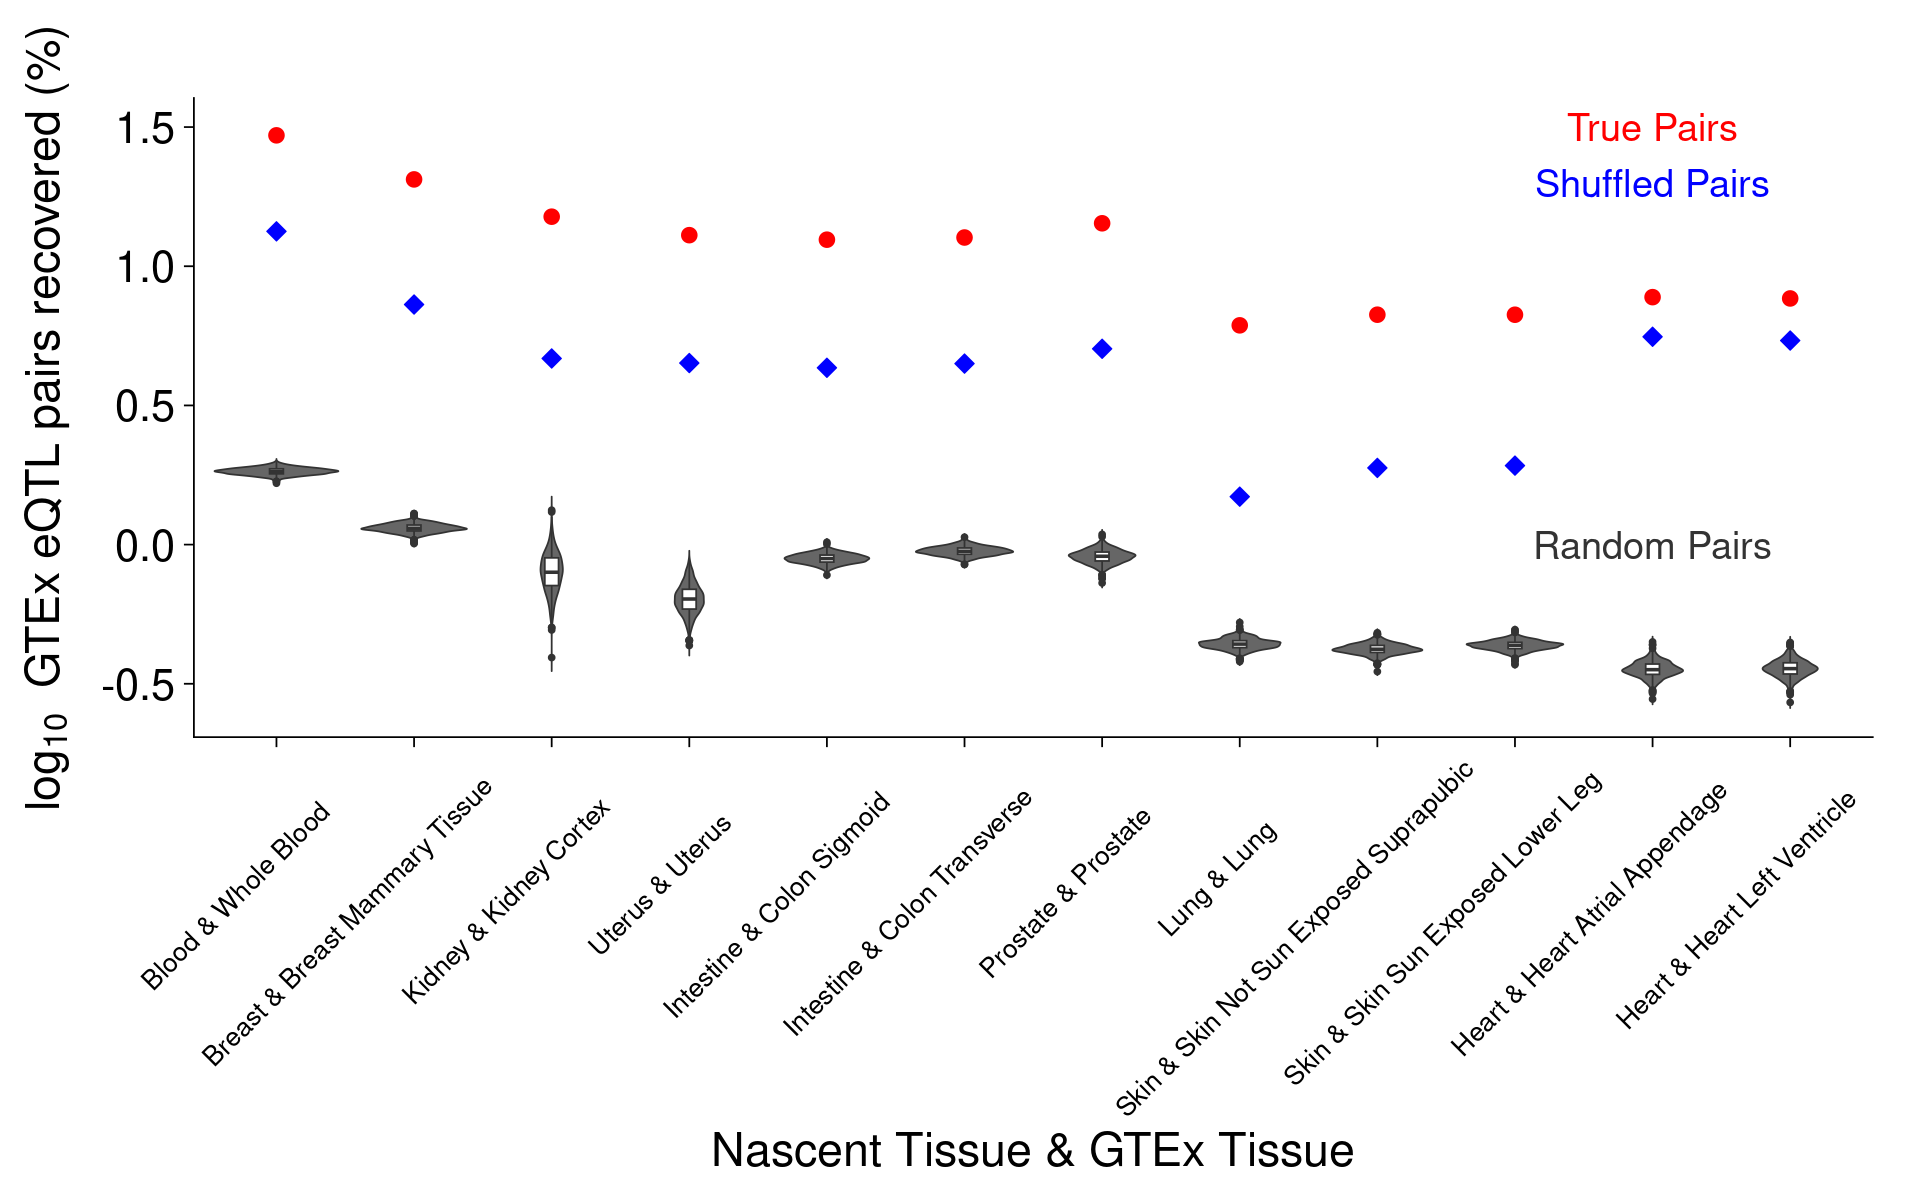

In [23]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sortB <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray40', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=11, 
         y=1.5, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=11, 
         y=1.3, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
annotate(geom="text",
         x=11, 
         y=0, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sortB

In [24]:
tissue_namesC <- c("Blood \n Whole Blood","Breast \n Breast Mammary Tissue",
                   "Kidney \n Kidney Cortex","Uterus \n Uterus",
                   "Intestine \n Colon Sigmoid", "Intestine \n Colon Transverse", 
                   "Prostate \n Prostate","Lung \n Lung",
                   "Skin \n Skin Not Sun Exposed Suprapubic","Skin \n Skin Sun Exposed Lower Leg",
                   "Heart \n Heart Atrial Appendage","Heart \n Heart Left Ventricle")
tissue_namesC

[1] "Blood \n Whole Blood"                   
 [2] "Breast \n Breast Mammary Tissue"        
 [3] "Kidney \n Kidney Cortex"                
 [4] "Uterus \n Uterus"                       
 [5] "Intestine \n Colon Sigmoid"             
 [6] "Intestine \n Colon Transverse"          
 [7] "Prostate \n Prostate"                   
 [8] "Lung \n Lung"                           
 [9] "Skin \n Skin Not Sun Exposed Suprapubic"
[10] "Skin \n Skin Sun Exposed Lower Leg"     
[11] "Heart \n Heart Atrial Appendage"        
[12] "Heart \n Heart Left Ventricle"

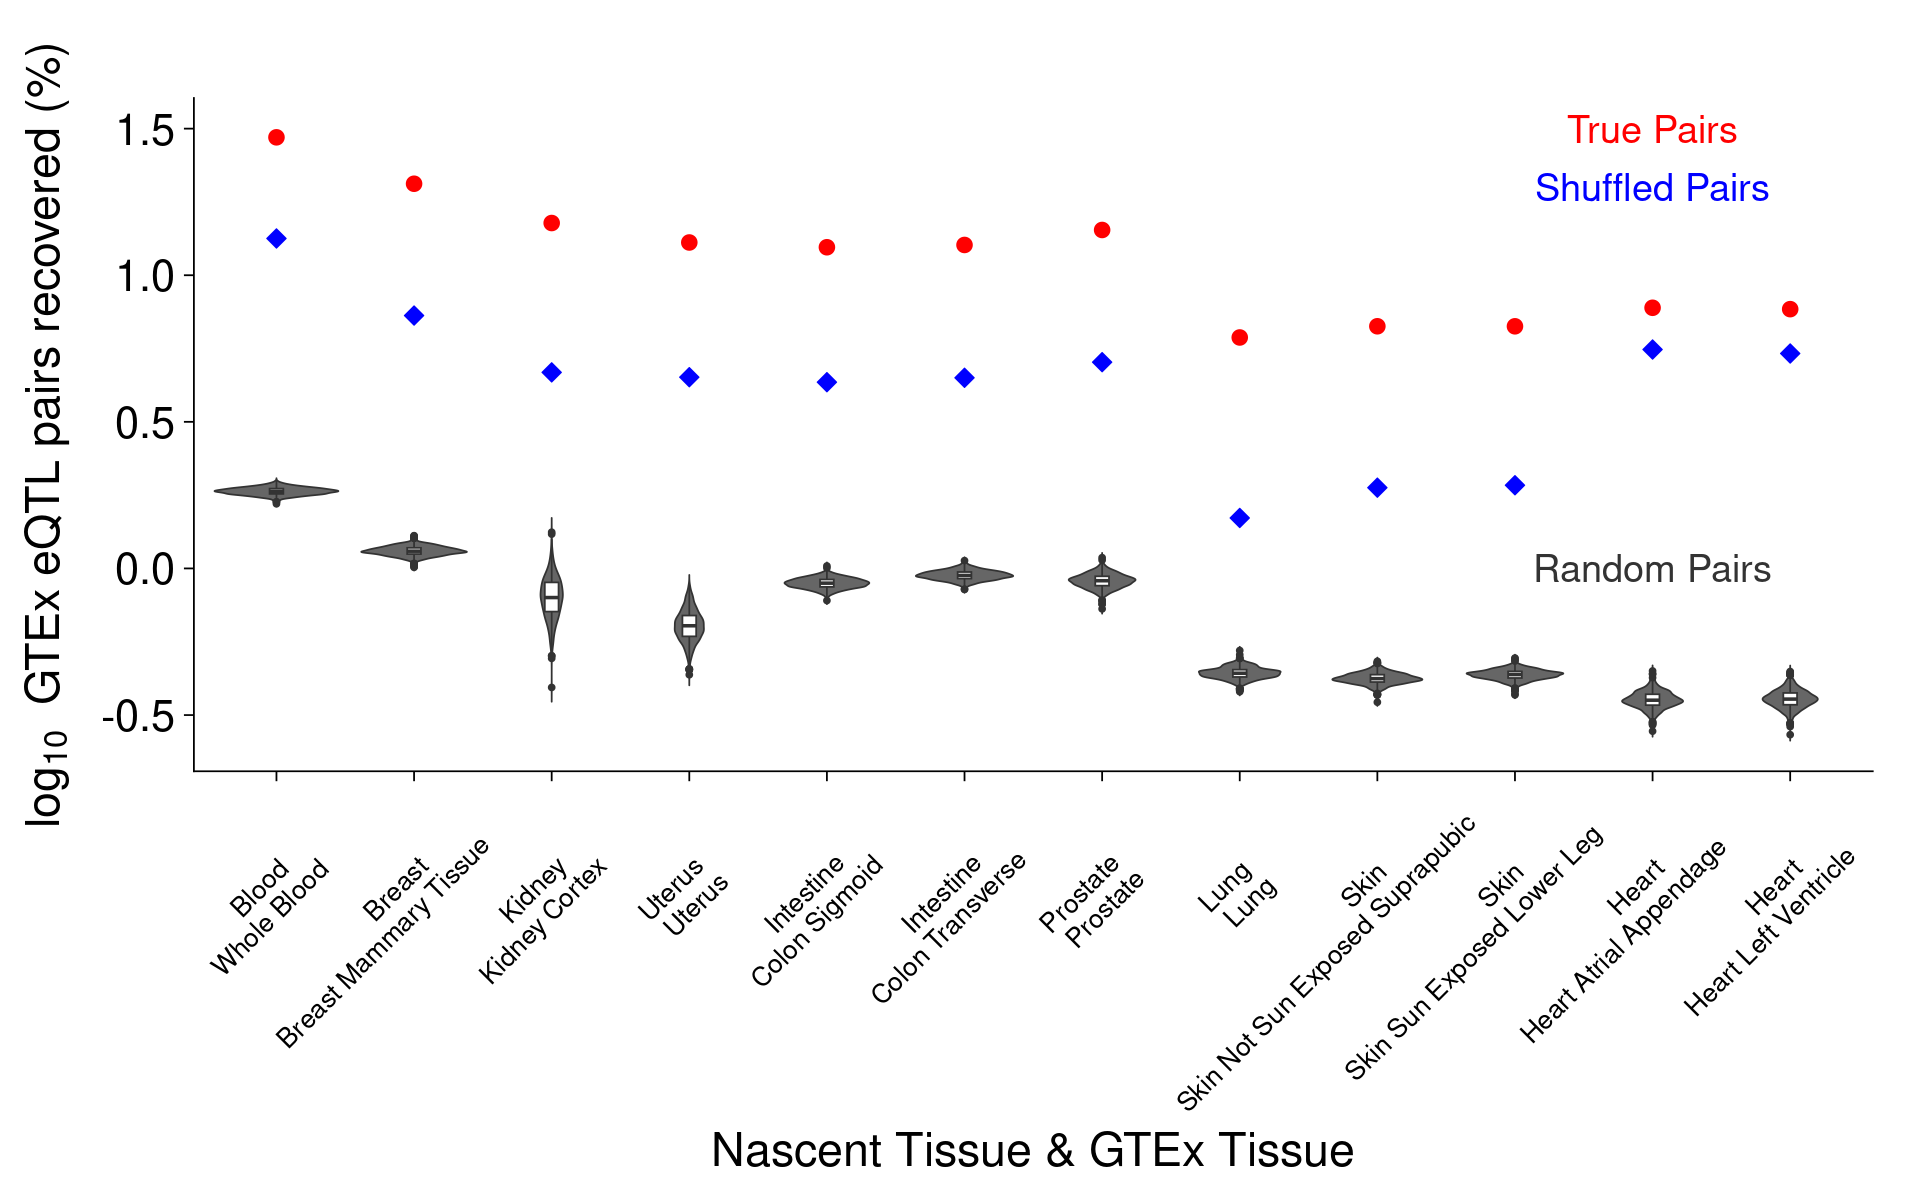

In [25]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sortC <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray40', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=11, 
         y=1.5, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=11, 
         y=1.3, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
annotate(geom="text",
         x=11, 
         y=0, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_namesC) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sortC

## Mixed tissues

In [26]:
## Loading all overlaps
mixed_overlap_path <- '/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/nascent_mixed_tissues_gtex_pair_overlaps'

##get paths
mixed_overlap_files <- list.files(path=mixed_overlap_path, 
                                    pattern="*_shuffled_pair*", 
                                    full.names=TRUE)

length(mixed_overlap_files)

[1] 96

In [27]:
##get paths
mixed_true_overlap_files <- list.files(path=mixed_overlap_path, 
                              pattern="*_true_", 
                                   full.names=TRUE)

length(mixed_true_overlap_files)

[1] 96

In [28]:
mixed_true_overlap_base <- list.files(path=mixed_overlap_path, 
                                      pattern="*_true_")

tissues_clean_mix <- gsub("_true_pair_overlap_summary_2024_September_[0-9]+_[0-9]+_[0-9]+_[0-9]+.tsv.gz", 
     "\\1", 
     mixed_true_overlap_base)

tissues_clean_mix

[1] "blood_Breast_Mammary_Tissue"              
 [2] "blood_Colon_Sigmoid"                      
 [3] "blood_Colon_Transverse"                   
 [4] "blood_Heart_Atrial_Appendage"             
 [5] "blood_Heart_Left_Ventricle"               
 [6] "blood_Kidney_Cortex"                      
 [7] "blood_Lung"                               
 [8] "blood_Prostate"                           
 [9] "blood_Skin_Not_Sun_Exposed_Suprapubic"    
[10] "blood_Skin_Sun_Exposed_Lower_leg"         
[11] "blood_Uterus"                             
[12] "breast_Colon_Sigmoid"                     
[13] "breast_Colon_Transverse"                  
[14] "breast_Heart_Atrial_Appendage"            
[15] "breast_Heart_Left_Ventricle"              
[16] "breast_Kidney_Cortex"                     
[17] "breast_Lung"                              
[18] "breast_Prostate"                          
[19] "breast_Skin_Not_Sun_Exposed_Suprapubic"   
[20] "breast_Skin_Sun_Exposed_Lower_leg"        
[21] "breast_Uterus"                            
[22] "breast_Whole_Blood"                       
[23] "heart_Breast_Mammary_Tissue"              
[24] "heart_Colon_Sigmoid"                      
[25] "heart_Colon_Transverse"                   
[26] "heart_Kidney_Cortex"                      
[27] "heart_Lung"                               
[28] "heart_Prostate"                           
[29] "heart_Skin_Not_Sun_Exposed_Suprapubic"    
[30] "heart_Skin_Sun_Exposed_Lower_leg"         
[31] "heart_Uterus"                             
[32] "heart_Whole_Blood"                        
[33] "intestine_Breast_Mammary_Tissue"          
[34] "intestine_Heart_Atrial_Appendage"         
[35] "intestine_Heart_Left_Ventricle"           
[36] "intestine_Kidney_Cortex"                  
[37] "intestine_Lung"                           
[38] "intestine_Prostate"                       
[39] "intestine_Skin_Not_Sun_Exposed_Suprapubic"
[40] "intestine_Skin_Sun_Exposed_Lower_leg"     
[41] "intestine_Uterus"                         
[42] "intestine_Whole_Blood"                    
[43] "kidney_Breast_Mammary_Tissue"             
[44] "kidney_Colon_Sigmoid"                     
[45] "kidney_Colon_Transverse"                  
[46] "kidney_Heart_Atrial_Appendage"            
[47] "kidney_Heart_Left_Ventricle"              
[48] "kidney_Lung"                              
[49] "kidney_Prostate"                          
[50] "kidney_Skin_Not_Sun_Exposed_Suprapubic"   
[51] "kidney_Skin_Sun_Exposed_Lower_leg"        
[52] "kidney_Uterus"                            
[53] "kidney_Whole_Blood"                       
[54] "lung_Breast_Mammary_Tissue"               
[55] "lung_Colon_Sigmoid"                       
[56] "lung_Colon_Transverse"                    
[57] "lung_Heart_Atrial_Appendage"              
[58] "lung_Heart_Left_Ventricle"                
[59] "lung_Kidney_Cortex"                       
[60] "lung_Prostate"                            
[61] "lung_Skin_Not_Sun_Exposed_Suprapubic"     
[62] "lung_Skin_Sun_Exposed_Lower_leg"          
[63] "lung_Uterus"                              
[64] "lung_Whole_Blood"                         
[65] "prostate_Breast_Mammary_Tissue"           
[66] "prostate_Colon_Sigmoid"                   
[67] "prostate_Colon_Transverse"                
[68] "prostate_Heart_Atrial_Appendage"          
[69] "prostate_Heart_Left_Ventricle"            
[70] "prostate_Kidney_Cortex"                   
[71] "prostate_Lung"                            
[72] "prostate_Skin_Not_Sun_Exposed_Suprapubic" 
[73] "prostate_Skin_Sun_Exposed_Lower_leg"      
[74] "prostate_Uterus"                          
[75] "prostate_Whole_Blood"                     
[76] "skin_Breast_Mammary_Tissue"               
[77] "skin_Colon_Sigmoid"                       
[78] "skin_Colon_Transverse"                    
[79] "skin_Heart_Atrial_Appendage"              
[80] "skin_Heart_Left_Ventricle"                
[81] "skin_Kidney_Cortex"                       
[82] "skin_Lung"                

In [29]:
##load overlaps
mixed_true_overlap_bed_DT_list <- lapply(mixed_true_overlap_files, 
                                   data.table::fread) 

##merge overlaps
mixed_true_overlap_bed_DT <- do.call(rbind, 
                          mixed_true_overlap_bed_DT_list)

mixed_true_overlap_bed_DT$tissues <- tissues_clean_mix
dim(mixed_true_overlap_bed_DT)
head(mixed_true_overlap_bed_DT)

[1] 96  7

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1 16997        13752                12.33517     5.445539             
2 15964        13001                12.13992     5.396084             
3 17799        14578                12.45269     5.609879             
4 18004        14628                12.23389     5.626760             
5 16470        13050                12.19765     5.466266             
6  1108          839                11.15923     3.431914             
  p_value_nascent p_value_eqtl tissues                     
1 0.000999001     0.000999001  blood_Breast_Mammary_Tissue 
2 0.000999001     0.000999001  blood_Colon_Sigmoid         
3 0.000999001     0.000999001  blood_Colon_Transverse      
4 0.000999001     0.000999001  blood_Heart_Atrial_Appendage
5 0.000999001     0.000999001  blood_Heart_Left_Ventricle  
6 0.000999001     0.000999001  blood_Kidney_Cortex

### Example blood and breast

In [30]:
blood_mixed_true_overlap_bed_DT <- rbind(true_overlap_bed_DT[1:2,1:7], mixed_true_overlap_bed_DT[1:22,])
blood_mixed_true_overlap_bed_DT$tissues_mixed <- c("Same", "Same", rep("Different", 22))
blood_mixed_true_overlap_bed_DT

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1  62488        56050                29.530633    7.868798             
2  28262        24184                20.510476    6.206596             
3  16997        13752                12.335169    5.445539             
4  15964        13001                12.139924    5.396084             
5  17799        14578                12.452688    5.609879             
6  18004        14628                12.233887    5.626760             
7  16470        13050                12.197651    5.466266             
8   1108          839                11.159231    3.431914             
9  24052        20028                12.602501    6.169998             
10  8447         6599                11.711125    4.270534             
11 27896        23854                12.789759    6.648846             
12 32599        28159                12.999043    7.082190             
13  3250         2475                10.848883    3.497195             
14  9589         7764                 7.292015    5.643877             
15 10486         8494                 7.336304    5.734269             
16 10760         8725                 7.311521    5.853387             
17  9795         7773                 7.254158    5.671280             
18   627          467                 6.314835    3.361889             
19 14369        11860                 7.528910    6.376687             
20  4873         3816                 6.756045    4.363936             
21 16651        14158                 7.634151    6.929971             
22 19591        16998                 7.812026    7.458240             
23  1891         1468                 6.312381    3.619240             
24 16524        13818                 7.808926    6.986339             
   p_value_nascent p_value_eqtl tissues                               
1  0.000999001     0.000999001  blood & Whole_Blood                   
2  0.000999001     0.000999001  breast & Breast_Mammary_Tissue        
3  0.000999001     0.000999001  blood_Breast_Mammary_Tissue           
4  0.000999001     0.000999001  blood_Colon_Sigmoid                   
5  0.000999001     0.000999001  blood_Colon_Transverse                
6  0.000999001     0.000999001  blood_Heart_Atrial_Appendage          
7  0.000999001     0.000999001  blood_Heart_Left_Ventricle            
8  0.000999001     0.000999001  blood_Kidney_Cortex                   
9  0.000999001     0.000999001  blood_Lung                            
10 0.000999001     0.000999001  blood_Prostate                        
11 0.000999001     0.000999001  blood_Skin_Not_Sun_Exposed_Suprapubic 
12 0.000999001     0.000999001  blood_Skin_Sun_Exposed_Lower_leg      
13 0.000999001     0.000999001  blood_Uterus                          
14 0.000999001     0.000999001  breast_Colon_Sigmoid                  
15 0.000999001     0.000999001  breast_Colon_Transverse               
16 0.000999001     0.000999001  breast_Heart_Atrial_Appendage         
17 0.000999001     0.000999001  breast_Heart_Left_Ventricle           
18 0.000999001     0.000999001  breast_Kidney_Cortex                  
19 0.000999001     0.000999001  breast_Lung                           
20 0.000999001     0.000999001  breast_Prostate                       
21 0.000999001     0.000999001  breast_Skin_Not_Sun_Exposed_Suprapubic
22 0.000999001     0.000999001  breast_Skin_Sun_Exposed_Lower_leg     
23 0.000999001     0.000999001  breast_Uterus                         
24 0.000999001     0.000999001  breast_Whole_Blood                    
   tissues_mixed
1  Same         
2  Same         
3  Different    
4  Different    
5  Different    
6  Different    
7  Different    
8  Different    
9  Different    
10 Different    
11 Different    
12 Different    
13 Different    
14 Different    
15 Different    
16 Different    
17 Different    
18 Different    
19 Different    
20 Different    
21 Different    
22 Different    
23 Different    
24 Different

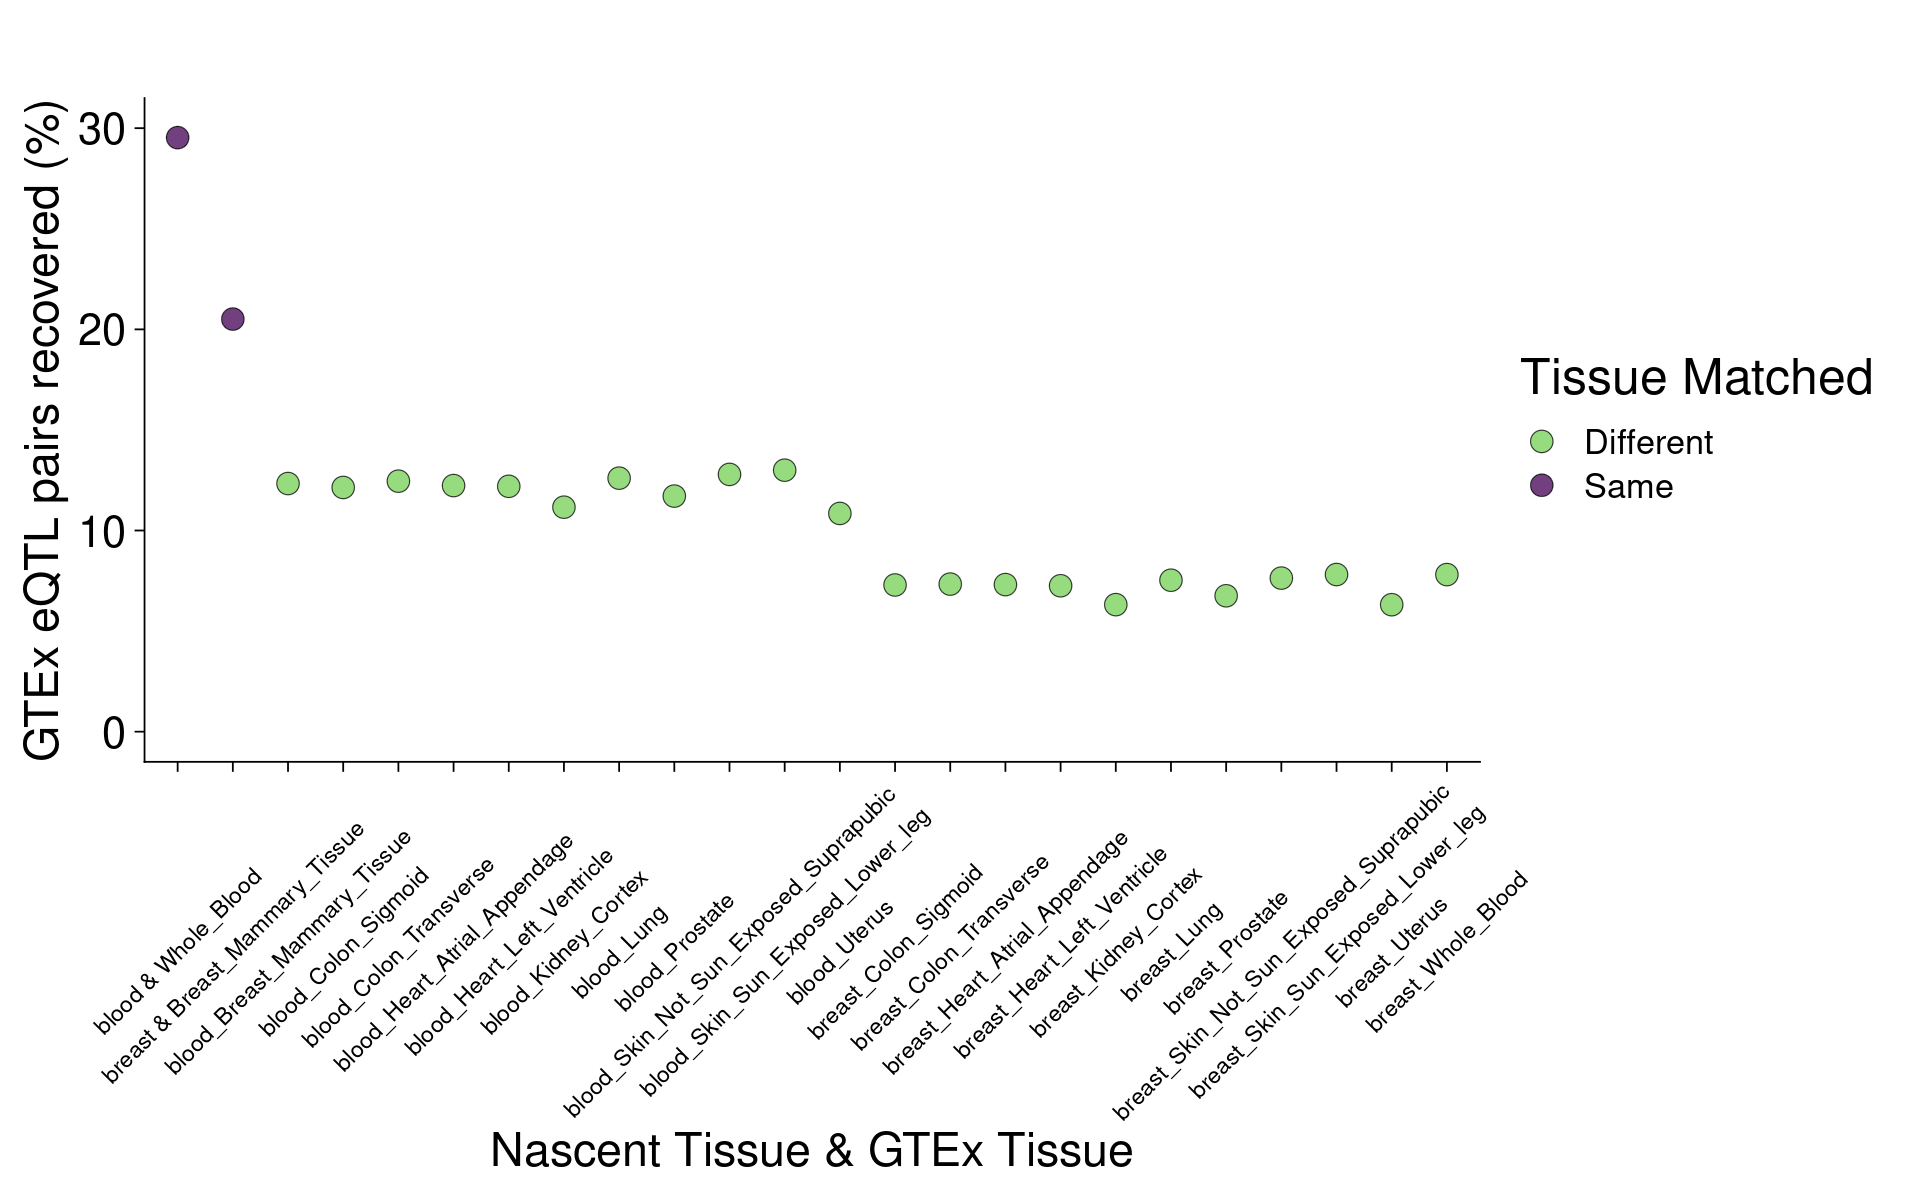

In [31]:
options(repr.plot.width=16, repr.plot.height=10)

mixed_overlap_plot <- ggplot(blood_mixed_true_overlap_bed_DT, 
                       aes(x=tissues, y=percent_eqtl, fill=tissues_mixed)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=6, 
          color='black') +
labs(title = " ", 
       x = "Nascent Tissue & GTEx Tissue",
       y = "GTEx eQTL pairs recovered (%)",
    fill="Tissue Matched") +
theme_cowplot(24) +
scale_fill_manual(values=c("#73D055FF","#440154FF")) +
scale_y_continuous(limits = c(0,30)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

mixed_overlap_plot

### Distribution for all tissues

In [32]:
true_overlap_bed_DT$tissues_mixed <- "Same"
mixed_true_overlap_bed_DT$tissues_mixed <- "Different"

In [33]:
tissues_mixed_true_overlap_bed_DT <- rbind(true_overlap_bed_DT, mixed_true_overlap_bed_DT)
head(tissues_mixed_true_overlap_bed_DT)

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1 62488        56050                29.530633    7.868798             
2 28262        24184                20.510476    6.206596             
3 11397         9294                 7.744369    5.969708             
4 10345         8217                 7.661487    5.712637             
5 16381        13615                12.457034    5.356356             
6 18128        15184                12.682865    5.545897             
  p_value_nascent p_value_eqtl tissues                        tissues_mixed
1 0.000999001     0.000999001  blood & Whole_Blood            Same         
2 0.000999001     0.000999001  breast & Breast_Mammary_Tissue Same         
3 0.000999001     0.000999001  heart & Heart_Atrial_Appendage Same         
4 0.000999001     0.000999001  heart & Heart_Left_Ventricle   Same         
5 0.000999001     0.000999001  intestine & Colon_Sigmoid      Same         
6 0.000999001     0.000999001  intestine & Colon_Transverse   Same

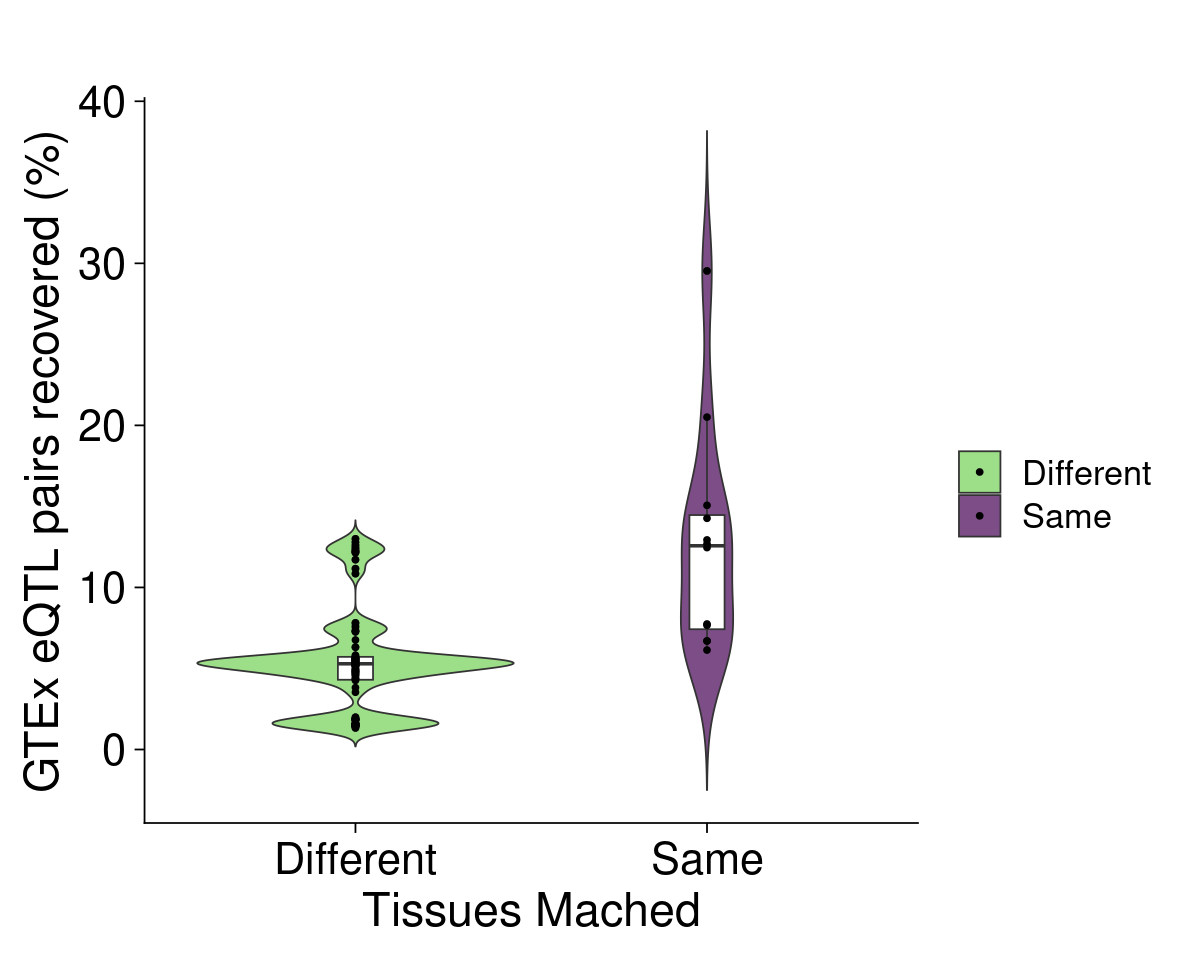

In [34]:
options(repr.plot.width=10, repr.plot.height=8)

# Use single color
mixed_tissues_overlap_plot <- ggplot(tissues_mixed_true_overlap_bed_DT, 
                                     aes(x=tissues_mixed, y=percent_eqtl, fill=tissues_mixed)) +
  geom_violin(trim=FALSE, color="gray20", alpha=0.7)+
  geom_boxplot(width=0.1, fill="white") + 
geom_point() +
labs(title = " ", 
       y = "GTEx eQTL pairs recovered (%)",
       x = "Tissues Mached",
    fill=" ") +
scale_fill_manual(values=c("#73D055FF","#440154FF")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

mixed_tissues_overlap_plot

In [35]:
wrt <- wilcox.test(as.numeric(true_overlap_bed_DT$percent_eqtl), 
            as.numeric(mixed_true_overlap_bed_DT$percent_eqtl),
           paired=FALSE) #paired is FALSE, since the number of samples is not matched

wrt


	Wilcoxon rank sum test with continuity correction

data:  as.numeric(true_overlap_bed_DT$percent_eqtl) and as.numeric(mixed_true_overlap_bed_DT$percent_eqtl)
W = 1058, p-value = 2.513e-06
alternative hypothesis: true location shift is not equal to 0


In [36]:
wrt$p.value

[1] 2.513458e-06

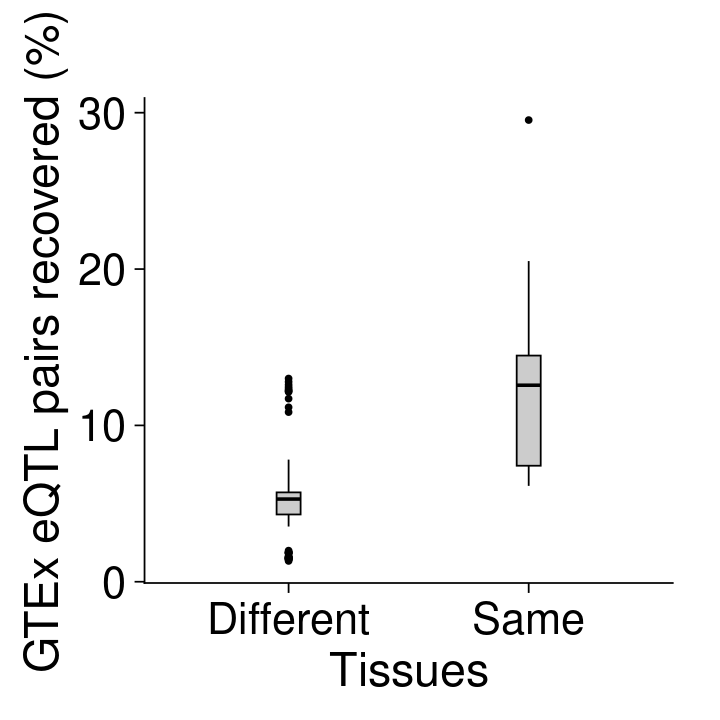

In [37]:
options(repr.plot.width=6, repr.plot.height=6)

# Use single color
mixed_tissues_overlap_plotA <- ggplot(tissues_mixed_true_overlap_bed_DT, 
                                     aes(x=tissues_mixed, y=percent_eqtl)) +
#geom_jitter(alpha=0.25, width=0.1) +
geom_boxplot(width=0.1, fill="gray80", color="black") + 
labs(title = " ", 
       y = "GTEx eQTL pairs recovered (%)",
       x = "Tissues",
    fill=" ") +
scale_fill_manual(values=c("#73D055FF","#440154FF")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

mixed_tissues_overlap_plotA

In [38]:
summary(true_overlap_bed_DT$percent_eqtl)
summary(mixed_true_overlap_bed_DT$percent_eqt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.134   7.420  12.570  12.698  14.466  29.531 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.329   4.303   5.288   5.407   5.716  12.999 

In [39]:
ggsave(mixed_tissues_overlap_plotA, width = 6, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_same_diff_tissues_boxplot_reviews.pdf',
      bg = "transparent")

ggsave(mixed_tissues_overlap_plotA, width = 6, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_same_diff_tissues_boxplot_reviews.png',
      bg = "transparent")

ggsave(mixed_tissues_overlap_plotA, width = 6, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_same_diff_tissues_boxplot_reviews.svg',
      bg = "transparent")

### Individual tissues

In [40]:
bidir_tissue_unique <- unique(bidir_tissue)
bidir_tissue_unique

[1] "blood"     "breast"    "heart"     "intestine" "kidney"    "lung"     
[7] "prostate"  "skin"      "uterus"

In [41]:
tissues_clean

[1] "blood & Whole_Blood"                   
 [2] "breast & Breast_Mammary_Tissue"        
 [3] "heart & Heart_Atrial_Appendage"        
 [4] "heart & Heart_Left_Ventricle"          
 [5] "intestine & Colon_Sigmoid"             
 [6] "intestine & Colon_Transverse"          
 [7] "kidney & Kidney_Cortex"                
 [8] "lung & Lung"                           
 [9] "prostate & Prostate"                   
[10] "skin & Skin_Not_Sun_Exposed_Suprapubic"
[11] "skin & Skin_Sun_Exposed_Lower_leg"     
[12] "uterus & Uterus"

In [42]:
lapply(tissues_clean, grep, pattern="^blood*", value = TRUE)

[[1]]
[1] "blood & Whole_Blood"

[[2]]
character(0)

[[3]]
character(0)

[[4]]
character(0)

[[5]]
character(0)

[[6]]
character(0)

[[7]]
character(0)

[[8]]
character(0)

[[9]]
character(0)

[[10]]
character(0)

[[11]]
character(0)

[[12]]
character(0)

In [43]:
tissue_dot_plot_list <- vector(mode='list', 
                               length=length(bidir_tissue_unique))

for (i in 1:length(bidir_tissue_unique)){
    
    print("-----------------------")
    print(paste0("-----Tissue: ", i, "-----"))
    #1: filter the tissue DTs
    tissue_matched_DT <- true_overlap_bed_DT[grep(true_overlap_bed_DT$tissues, 
                                                  pattern=bidir_tissue_unique[[i]]),]
    
    tissue_unmatched_DT <- mixed_true_overlap_bed_DT[grep(mixed_true_overlap_bed_DT$tissues,
                                                          pattern=bidir_tissue_unique[[i]]),]
    
    #2: combine the DT
    explore_matched_tissues_DT <- rbind(tissue_matched_DT,
                                       tissue_unmatched_DT)
    
    print(paste0("- totals overlaps = ", nrow(explore_matched_tissues_DT)))

    tissue_mixed_overlap_plot <- ggplot(explore_matched_tissues_DT, 
                           aes(x=tissues, y=percent_eqtl, fill=tissues_mixed)) + 
    geom_point(shape=21, 
               alpha=0.75, 
               size=6, 
              color='black') +
    labs(title = bidir_tissue_unique[[i]], 
           x = "Nascent Tissue & GTEx Tissue",
           y = "GTEx eQTL pairs recovered (%)",
        fill="Tissue Matched") +
    theme_cowplot(24) +
    scale_fill_manual(values=c("#73D055FF","#440154FF")) +
    #scale_y_continuous(limits = c(0,30)) +
    theme(plot.title = element_text(hjust = 0.5, face="plain"),
          title = element_text(size = 30), 
          axis.title = element_text(size = 28),
          axis.text.y = element_text(size = 26),
          axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
    theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))
    
    
    tissue_dot_plot_list[[i]] <- tissue_mixed_overlap_plot
    
    
}

[1] "-----------------------"
[1] "-----Tissue: 1-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 2-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 3-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 4-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 5-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 6-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 7-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 8-----"
[1] "- totals overlaps = 12"
[1] "-----------------------"
[1] "-----Tissue: 9-----"
[1] "- totals overlaps = 12"


In [44]:
length(tissue_dot_plot_list)
length(bidir_tissue_unique)

[1] 9

[1] 9

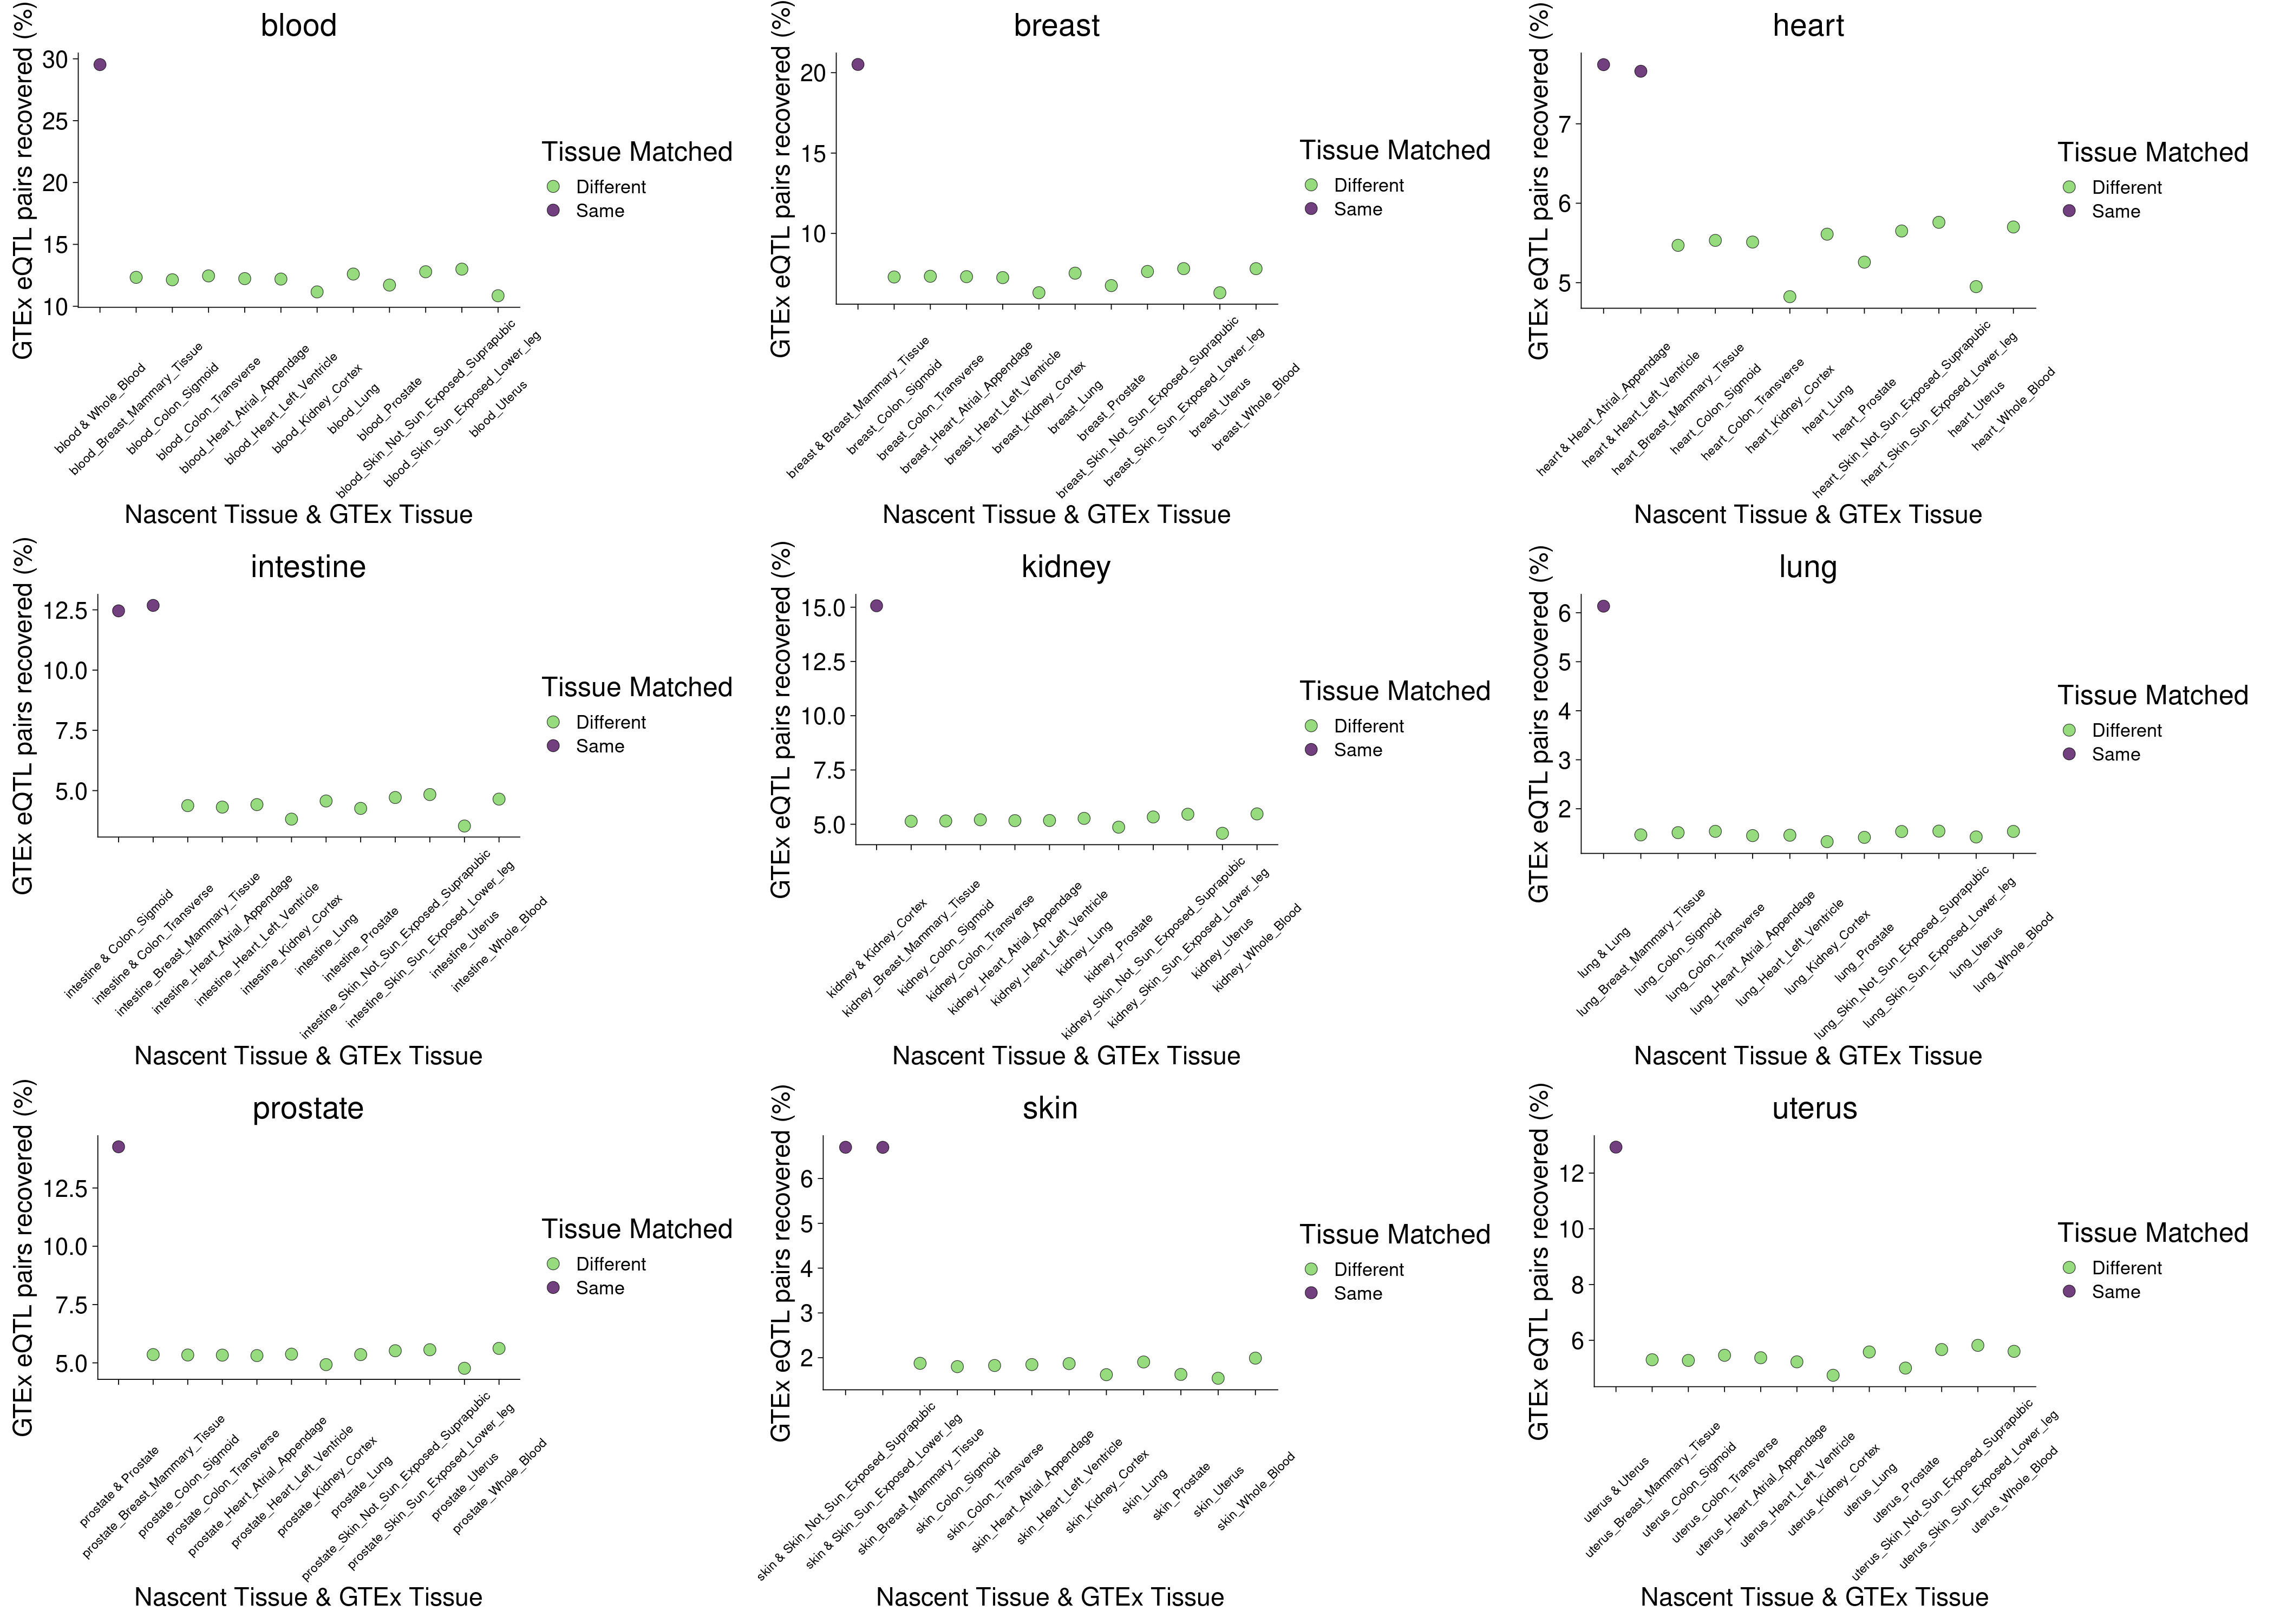

In [45]:
options(repr.plot.width=35, repr.plot.height=25)
tissue_dot_plot <- cowplot::plot_grid(plotlist = tissue_dot_plot_list, ncol = 3)
tissue_dot_plot

In [46]:
ggsave(tissue_dot_plot, width = 35, height = 25,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_same_diff_tissues_plot_reviews.pdf',
      bg = "transparent")

ggsave(tissue_dot_plot, width = 35, height = 25,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_same_diff_tissues_plot_reviews.png',
      bg = "transparent")

ggsave(tissue_dot_plot, width = 35, height = 25,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_same_diff_tissues_plot_reviews.svg',
      bg = "transparent")

In [47]:
#1: filter the tissue DTs
blood_matched_DT <- true_overlap_bed_DT[grep(true_overlap_bed_DT$tissues, pattern="blood"),]
blood_unmatched_DT <- mixed_true_overlap_bed_DT[grep(mixed_true_overlap_bed_DT$tissues, pattern="blood"),]

#2: combine the DT
blood_explore_matched_tissues_DT <- rbind(blood_matched_DT,
                                          blood_unmatched_DT)

blood_explore_matched_tissues_DT

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1  62488        56050                29.53063     7.868798             
2  16997        13752                12.33517     5.445539             
3  15964        13001                12.13992     5.396084             
4  17799        14578                12.45269     5.609879             
5  18004        14628                12.23389     5.626760             
6  16470        13050                12.19765     5.466266             
7   1108          839                11.15923     3.431914             
8  24052        20028                12.60250     6.169998             
9   8447         6599                11.71112     4.270534             
10 27896        23854                12.78976     6.648846             
11 32599        28159                12.99904     7.082190             
12  3250         2475                10.84888     3.497195             
   p_value_nascent p_value_eqtl tissues                              
1  0.000999001     0.000999001  blood & Whole_Blood                  
2  0.000999001     0.000999001  blood_Breast_Mammary_Tissue          
3  0.000999001     0.000999001  blood_Colon_Sigmoid                  
4  0.000999001     0.000999001  blood_Colon_Transverse               
5  0.000999001     0.000999001  blood_Heart_Atrial_Appendage         
6  0.000999001     0.000999001  blood_Heart_Left_Ventricle           
7  0.000999001     0.000999001  blood_Kidney_Cortex                  
8  0.000999001     0.000999001  blood_Lung                           
9  0.000999001     0.000999001  blood_Prostate                       
10 0.000999001     0.000999001  blood_Skin_Not_Sun_Exposed_Suprapubic
11 0.000999001     0.000999001  blood_Skin_Sun_Exposed_Lower_leg     
12 0.000999001     0.000999001  blood_Uterus                         
   tissues_mixed
1  Same         
2  Different    
3  Different    
4  Different    
5  Different    
6  Different    
7  Different    
8  Different    
9  Different    
10 Different    
11 Different    
12 Different

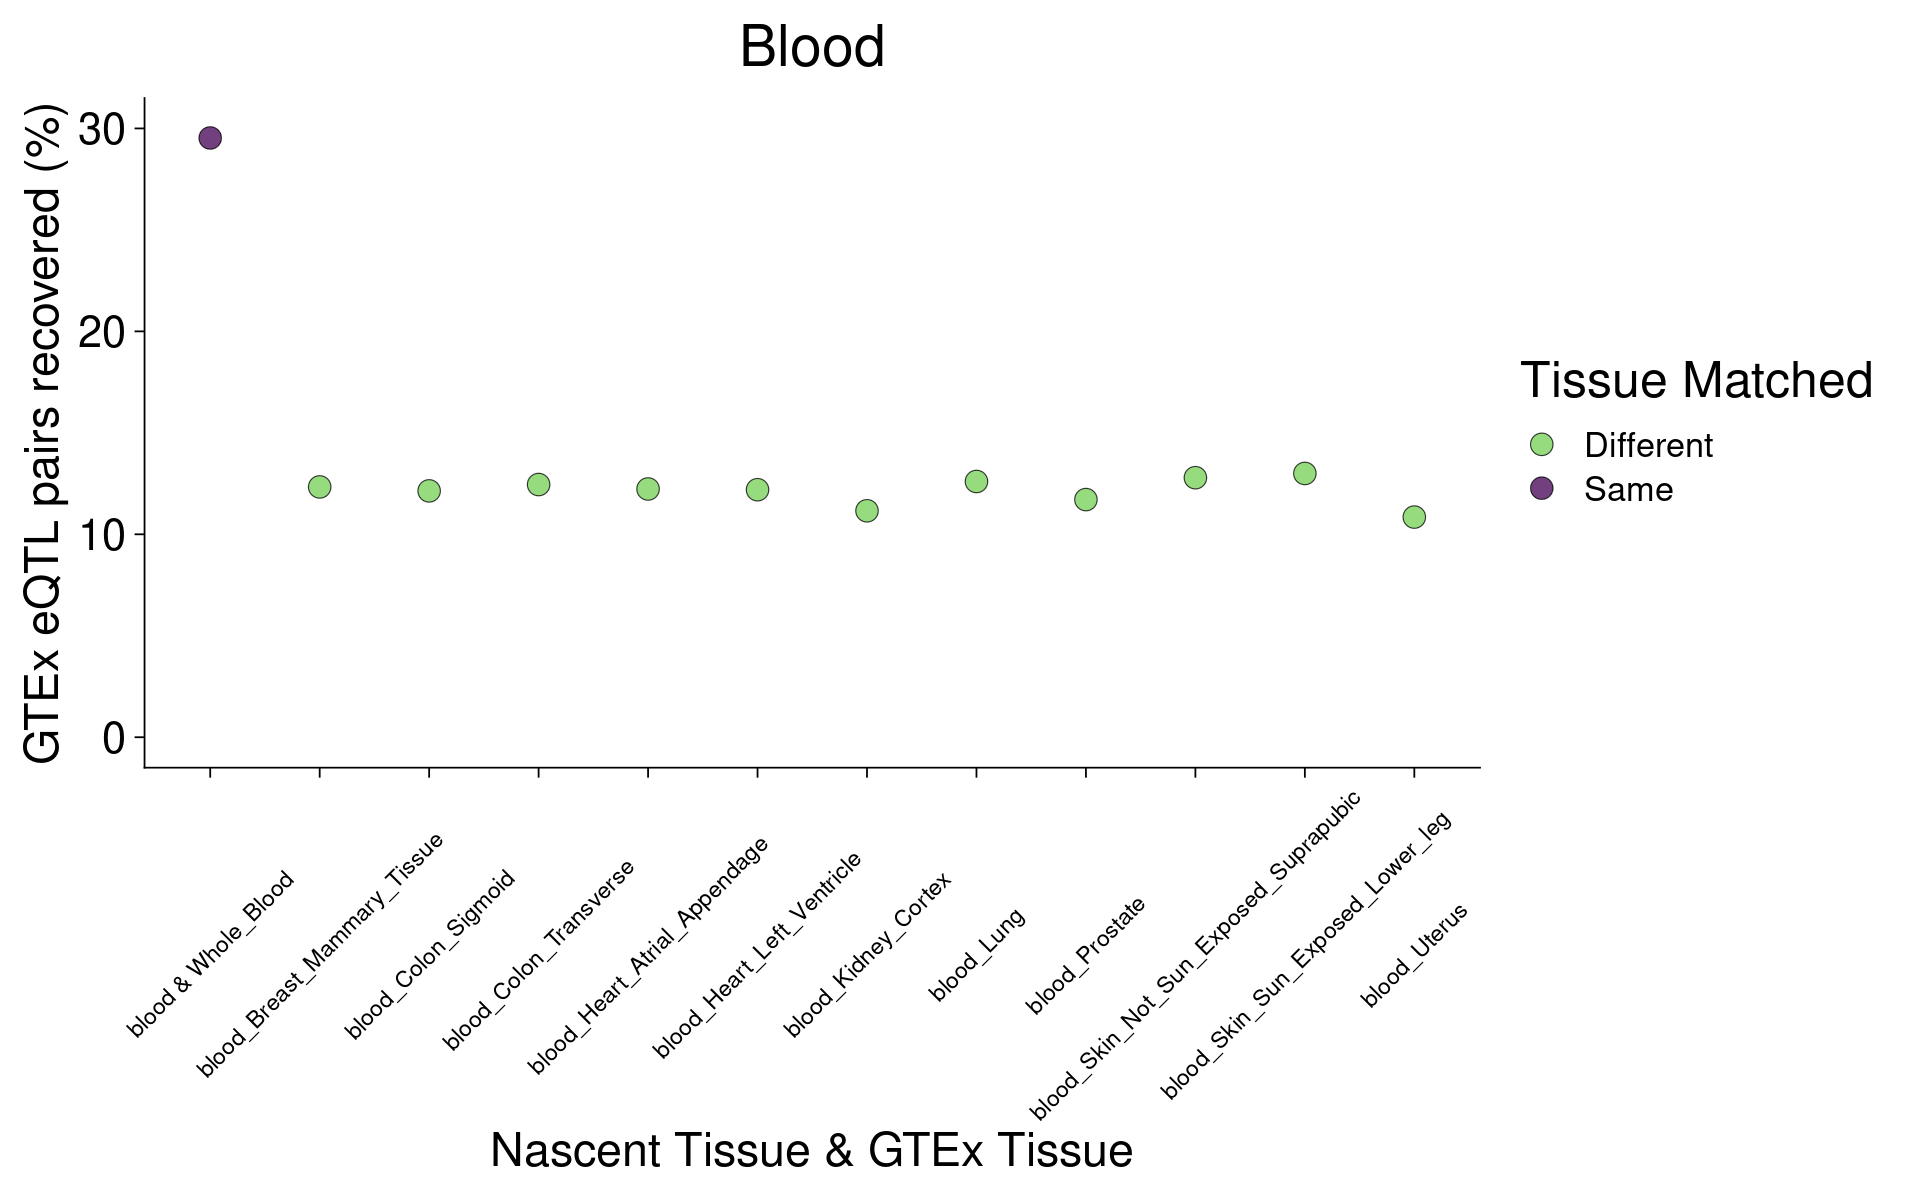

In [48]:
options(repr.plot.width=16, repr.plot.height=10)

blood_mixed_overlap_plot <- ggplot(blood_explore_matched_tissues_DT, 
                       aes(x=tissues, y=percent_eqtl, fill=tissues_mixed)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=6, 
          color='black') +
labs(title = "Blood", 
       x = "Nascent Tissue & GTEx Tissue",
       y = "GTEx eQTL pairs recovered (%)",
    fill="Tissue Matched") +
theme_cowplot(24) +
scale_fill_manual(values=c("#73D055FF","#440154FF")) +
scale_y_continuous(limits = c(0,30)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 14, angle=45, vjust=0.5, hjust=0.5)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

blood_mixed_overlap_plot

# Closest bidirectionals assigned

## Get bidir-gene distances

In [49]:
bidir_gene_dist <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/annotations/hg38_tfit_dreg_bidirectionals_genesTSS_distances.bed") 
colnames(bidir_gene_dist) <- c('bidir_chrom','bidir_start','bidir_end','bidirs',
                             'bidir_score','bidir_strand', 'gene_chrom',
                             'gene_start','gene_end','gene_id',
                             'gene_score','gene_strand','bidir_gene_dist')

bidir_gene_dist$bidir_id <- paste0(bidir_gene_dist$bidir_chrom,':',
                              bidir_gene_dist$bidir_start,'-',
                              bidir_gene_dist$bidir_end)

bidir_gene_dist$pair_id <- paste0(bidir_gene_dist$gene_id,
                                "~",
                                bidir_gene_dist$bidir_id)
bidir_gene_dist$abs_dist <- abs(bidir_gene_dist$bidir_gene_dist)

bidir_gene_dist$nascent_gene_id <- as.character(lapply(strsplit(bidir_gene_dist$gene_id, ':'),
                                                      `[`, 1))
dim(bidir_gene_dist)
head(bidir_gene_dist)

[1] 962865     17

bidir_chrom bidir_start bidir_end bidirs    bidir_score bidir_strand
1 chr1         3917        4919     dreg      14          .           
2 chr1         5632        6042     dreg      14          .           
3 chr1         6132        6486     dreg       7          .           
4 chr1         7207        7841     dreg       7          .           
5 chr1        10945       11371     tfit,dreg  1          .           
6 chr1        12182       12456     tfit,dreg  1          .           
  gene_chrom gene_start gene_end gene_id             gene_score gene_strand
1 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
2 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
3 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
4 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
5 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
6 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
  bidir_gene_dist bidir_id         pair_id                             
1 6955            chr1:3917-4919   DDX11L1:NR_046018.2~chr1:3917-4919  
2 5832            chr1:5632-6042   DDX11L1:NR_046018.2~chr1:5632-6042  
3 5388            chr1:6132-6486   DDX11L1:NR_046018.2~chr1:6132-6486  
4 4033            chr1:7207-7841   DDX11L1:NR_046018.2~chr1:7207-7841  
5  503            chr1:10945-11371 DDX11L1:NR_046018.2~chr1:10945-11371
6 -309            chr1:12182-12456 DDX11L1:NR_046018.2~chr1:12182-12456
  abs_dist nascent_gene_id
1 6955     DDX11L1        
2 5832     DDX11L1        
3 5388     DDX11L1        
4 4033     DDX11L1        
5  503     DDX11L1        
6  309     DDX11L1

In [50]:
summary(abs(bidir_gene_dist$abs_dist))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0     8801    27747    72191    72930 20282304 

In [51]:
bidir_gene_dist_near <- subset(bidir_gene_dist, abs_dist < 1000000)
dim(bidir_gene_dist_near)
head(bidir_gene_dist_near)

[1] 959614     17

bidir_chrom bidir_start bidir_end bidirs    bidir_score bidir_strand
1 chr1         3917        4919     dreg      14          .           
2 chr1         5632        6042     dreg      14          .           
3 chr1         6132        6486     dreg       7          .           
4 chr1         7207        7841     dreg       7          .           
5 chr1        10945       11371     tfit,dreg  1          .           
6 chr1        12182       12456     tfit,dreg  1          .           
  gene_chrom gene_start gene_end gene_id             gene_score gene_strand
1 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
2 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
3 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
4 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
5 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
6 chr1       11873      11874    DDX11L1:NR_046018.2 .          +          
  bidir_gene_dist bidir_id         pair_id                             
1 6955            chr1:3917-4919   DDX11L1:NR_046018.2~chr1:3917-4919  
2 5832            chr1:5632-6042   DDX11L1:NR_046018.2~chr1:5632-6042  
3 5388            chr1:6132-6486   DDX11L1:NR_046018.2~chr1:6132-6486  
4 4033            chr1:7207-7841   DDX11L1:NR_046018.2~chr1:7207-7841  
5  503            chr1:10945-11371 DDX11L1:NR_046018.2~chr1:10945-11371
6 -309            chr1:12182-12456 DDX11L1:NR_046018.2~chr1:12182-12456
  abs_dist nascent_gene_id
1 6955     DDX11L1        
2 5832     DDX11L1        
3 5388     DDX11L1        
4 4033     DDX11L1        
5  503     DDX11L1        
6  309     DDX11L1

## Filter the transcribed 

In [52]:
gene_bidir_tpm_summary_allBidirs_filteredSamples <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/summary_gene_bidir_tpm_filtered.tsv.gz')
dim(gene_bidir_tpm_summary_allBidirs_filteredSamples)
head(gene_bidir_tpm_summary_allBidirs_filteredSamples, 3)

[1] 876410     19

chrom start stop  gene_transcript       score strand length stdev     
1 chr1  12623 14409 DDX11L1:NR_046018.2   .     +       1787  0.07496376
2 chr1  14361 28620 WASH7P:NR_024540.1    .     -      14260  0.20321583
3 chr1  17368 17436 MIR6859-1:NR_106918.1 .     -         69  0.00000000
  variance    sum        mean       median    coefvar   max      min
1 0.005619565   7.345779 0.00978133 0.0000000 7.6639642 1.256177 0  
2 0.041296674 186.403807 0.24820747 0.1942185 0.8187338 1.417130 0  
3 0.000000000   0.000000 0.00000000 0.0000000        NA 0.000000 0  
  num_transcribed percent_transcribed transcript_type bidirectional_type
1  29              3.861518           genes           genes             
2 749             99.733688           genes           genes             
3   0              0.000000           genes           genes

In [53]:
gene_bidir_txpt <- subset(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                          num_transcribed >=3)
dim(gene_bidir_txpt)

[1] 866772     19

In [54]:
bidir_gene_dist_near_txpt <- bidir_gene_dist_near[gene_id %in% gene_bidir_txpt$gene_transcript & 
                                                  bidir_id %in% gene_bidir_txpt$gene_transcript,]

dim(bidir_gene_dist_near)
dim(bidir_gene_dist_near_txpt)

[1] 959614     17

[1] 436564     17

## Functions

### Map overlaps

In [55]:
map_overlaps <- function(overlap_DT, egene_ids, nascent_pairs){
    
    #1: merge the GTEx overlaps with gene ids
    overlap_bed_DT_genename <- merge(overlap_DT, 
                                     egene_ids,
                                     by='gene_id')
    
    #2: merge the overlap bed file with the nascent pairs
    overlap_bed_DT_genename_bidirs <- merge(overlap_bed_DT_genename,
                                            nascent_pairs,
                                            by = 'bidir_id',
                                            all = TRUE, 
                                            allow.cartesian=TRUE) ##for duplicate keys

    #3: get overlapping bidirectionals and match gene pairs
    overlap_bed_DT_nascent_gtex <- subset(overlap_bed_DT_genename_bidirs,
                                          gene_name==nascent_gene_id)
    
    #4: summarize overlaps
    overlaps <- list(length(unique(overlap_bed_DT_nascent_gtex$variant_id)),
                    length(unique(overlap_bed_DT_nascent_gtex$pair_id)))

    names(overlaps) <- c("eqtl_overlap","nascent_pair_overlap")
    return(overlaps)
    
}

## Load data

### Significant pairs loose filter

In [56]:
sig_pairs_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 

In [57]:
#combine pairs
corr_sig_DT <- do.call(rbind, corr_sig_DT_list)

#add pair id
corr_sig_DT$pair_id <- paste0(corr_sig_DT$transcript_1, 
                             "~",
                             corr_sig_DT$transcript_2)

#add gene id
corr_sig_DT$gene_id <- as.character(lapply(strsplit(corr_sig_DT$transcript_1, ':'),
                                                    `[`, 1))
length(unique(corr_sig_DT$pair_id))

[1] 6700460

### RefSeq

In [58]:
refseq <- data.table::fread("/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_diff53prime_with_putatives.bed")
colnames(refseq) <- c("chrom","start","end","gene_transcript","score","strand")
refseq$gene_name <-as.character(lapply(strsplit(refseq$gene_transcript, ':'),
                                                    `[`, 1)) 
dim(refseq)
head(refseq, 3)

[1] 83826     7

chrom start end   gene_transcript       score strand gene_name
1 chr1  11873 14409 DDX11L1:NR_046018.2   .     +      DDX11L1  
2 chr1  14361 29370 WASH7P:NR_024540.1    .     -      WASH7P   
3 chr1  17368 17436 MIR6859-1:NR_106918.1 .     -      MIR6859-1

### GTEx significant pairs

In [59]:
gtex_blood <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Whole_Blood.v8.signif_variant_gene_pairs.txt.gz", 
                               nThread=4)
dim(gtex_blood)
head(gtex_blood, 3)

[1] 2414653      12

variant_id          gene_id           tss_distance ma_samples ma_count
1 chr1_64764_C_T_b38  ENSG00000227232.5  35211        79         80     
2 chr1_665098_G_A_b38 ENSG00000227232.5 635545       140        146     
3 chr1_666028_G_A_b38 ENSG00000227232.5 636475       125        131     
  maf       pval_nominal slope    slope_se  pval_nominal_threshold
1 0.0597015 1.72756e-09  0.516614 0.0844652 0.000393213           
2 0.1089550 8.84898e-13  0.462697 0.0633368 0.000393213           
3 0.0977612 3.85133e-13  0.489662 0.0659359 0.000393213           
  min_pval_nominal pval_beta  
1 3.85133e-13      1.05258e-09
2 3.85133e-13      1.05258e-09
3 3.85133e-13      1.05258e-09

In [60]:
## Loading all overlaps
gtex_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL'

##get paths
gtex_files <- list.files(path=gtex_path, 
                              pattern="*signif_variant_gene_pairs.txt.gz", 
                                   full.names=TRUE)

gtex_pattern <- "Whole_Blood|Breast_Mammary_Tissue|Heart_Atrial_Appendage|Heart_Left_Ventricle|Colon_Sigmoid|Colon_Transverse|Kidney_Cortex|Lung|Prostate|Skin_Not_Sun_Exposed_Suprapubic|Skin_Sun_Exposed_Lower_leg|Uterus"

gtex_files_matched <- grep(gtex_files,
                           pattern=gtex_pattern,
                           value = TRUE)

gtex_files_matched

[1] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Breast_Mammary_Tissue.v8.signif_variant_gene_pairs.txt.gz"          
 [2] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Colon_Sigmoid.v8.signif_variant_gene_pairs.txt.gz"                  
 [3] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Colon_Transverse.v8.signif_variant_gene_pairs.txt.gz"               
 [4] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Heart_Atrial_Appendage.v8.signif_variant_gene_pairs.txt.gz"         
 [5] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Heart_Left_Ventricle.v8.signif_variant_gene_pairs.txt.gz"           
 [6] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Kidney_Cortex.v8.signif_variant_gene_pairs.txt.gz"                  
 [7] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Lung.v8.signif_variant_gene_pairs.txt.gz"                           
 [8] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Prostate.v8.signif_variant_gene_pairs.txt.gz"                       
 [9] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Skin_Not_Sun_Exposed_Suprapubic.v8.signif_variant_gene_pairs.txt.gz"
[10] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Skin_Sun_Exposed_Lower_leg.v8.signif_variant_gene_pairs.txt.gz"     
[11] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Uterus.v8.signif_variant_gene_pairs.txt.gz"                         
[12] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Whole_Blood.v8.signif_variant_gene_pairs.txt.gz"

In [61]:
gtex_tissues_only <- as.character(lapply(strsplit(basename(gtex_files_matched), '\\.'), `[`, 1))
gtex_tissues_only

[1] "Breast_Mammary_Tissue"           "Colon_Sigmoid"                  
 [3] "Colon_Transverse"                "Heart_Atrial_Appendage"         
 [5] "Heart_Left_Ventricle"            "Kidney_Cortex"                  
 [7] "Lung"                            "Prostate"                       
 [9] "Skin_Not_Sun_Exposed_Suprapubic" "Skin_Sun_Exposed_Lower_leg"     
[11] "Uterus"                          "Whole_Blood"

In [62]:
##load overlaps
gtex_sig_DT_list <- lapply(gtex_files_matched, 
                           data.table::fread,
                          nThread=4) 


In [63]:
names(gtex_sig_DT_list) <- gtex_tissues_only

In [64]:
gtex_sig_DT <- do.call(rbind, gtex_sig_DT_list)
num_gtex_sig <- nrow(unique(gtex_sig_DT[,c("variant_id","gene_id")]))
num_gtex_sig
nrow(gtex_sig_DT)
head(gtex_sig_DT, 3)

[1] 6910535

[1] 19805695

variant_id          gene_id           tss_distance ma_samples ma_count
1 chr1_64764_C_T_b38  ENSG00000227232.5  35211       56         56      
2 chr1_665098_G_A_b38 ENSG00000227232.5 635545       88         92      
3 chr1_666028_G_A_b38 ENSG00000227232.5 636475       78         82      
  maf       pval_nominal slope    slope_se  pval_nominal_threshold
1 0.0707071 2.91467e-05  0.523044 0.1233590 0.000210371           
2 0.1161620 2.67521e-08  0.562544 0.0986822 0.000210371           
3 0.1035350 6.67760e-07  0.528564 0.1042490 0.000210371           
  min_pval_nominal pval_beta  
1 2.67521e-08      2.45793e-05
2 2.67521e-08      2.45793e-05
3 2.67521e-08      2.45793e-05

### SNP-bidir overlap

In [65]:
load_snp_bidir_overlaps <- function(overlap_path, nThread=4){
    
    overlap_DT <- data.table::fread(overlap_path,
                                       nThread=nThread)

    ##Relabel the columns
    colnames(overlap_DT) <- c('chr_variant','start_variant','end_variant',
                                 'ref_variant','alt_variant','ref', 'gene_id',
                                 'chr_bidir','start_bidir','end_bidir')

    #Add a new column with a bidirectional ID
    overlap_DT[,("bidir_id"):=paste0(chr_bidir,':',
                                         start_bidir,'-',
                                         end_bidir)]

    #Add a new column with a gtex SNP ID
    overlap_DT[,("gtex_snp_id"):=paste0(chr_variant,':',
                                         start_variant,'-',
                                         end_variant)]

    #Add a new column with a variant ID
    overlap_DT[,("variant_id"):=paste0(chr_variant,'_',
                                           end_variant,'_',
                                           ref_variant,'_',
                                          alt_variant,'_',
                                          ref)]

    return(overlap_DT)
    
}

In [66]:
## Loading all overlaps
overlap_path <- '/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect'

##get ALL paths
overlap_files <- list.files(path=overlap_path, 
                              pattern="*.bed", 
                                   full.names=TRUE)


In [67]:
# get all teh NascentPair tissues
bidir_tissues_order <- c("breast", "intestine","intestine", "heart", "heart",  
               "kidney","lung", "prostate", "skin", "skin", "uterus", "blood")

# combine with the GTEx tissues
gtex_bidir_tissues_order <- paste(gtex_tissues_only, bidir_tissues_order, sep="_")
gtex_bidir_tissues_order

[1] "Breast_Mammary_Tissue_breast"        
 [2] "Colon_Sigmoid_intestine"             
 [3] "Colon_Transverse_intestine"          
 [4] "Heart_Atrial_Appendage_heart"        
 [5] "Heart_Left_Ventricle_heart"          
 [6] "Kidney_Cortex_kidney"                
 [7] "Lung_lung"                           
 [8] "Prostate_prostate"                   
 [9] "Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "Skin_Sun_Exposed_Lower_leg_skin"     
[11] "Uterus_uterus"                       
[12] "Whole_Blood_blood"

In [68]:
#combine all the possible options separated by |
#that way I can grep the appropricate overlapping tissues
gtex_bidir_tissue_pattern <- paste(gtex_bidir_tissues_order,
                                   collapse="|")

## Loading all overlaps
# get paths for the overlaps of GTEx and NascentPairs
overlap_matched_paths <- grep(overlap_files, grep, pattern=gtex_bidir_tissue_pattern, value = TRUE)


# load all the files
overlap_matched_list <- lapply(overlap_matched_paths, 
                               load_snp_bidir_overlaps,
                              nThread=4)

# rename the lists
names(overlap_matched_list) <- gtex_bidir_tissues_order

In [69]:
##names to search tables with
tissue_option_pattern <- paste(bidir_tissues_order,
                               gtex_tissues_only,
                               gtex_bidir_tissues_order, sep=":")
tissue_option_pattern

[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"                
 [2] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"                          
 [3] "intestine:Colon_Transverse:Colon_Transverse_intestine"                    
 [4] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"                
 [5] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"                    
 [6] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"                                
 [7] "lung:Lung:Lung_lung"                                                      
 [8] "prostate:Prostate:Prostate_prostate"                                      
 [9] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"          
[11] "uterus:Uterus:Uterus_uterus"                                              
[12] "blood:Whole_Blood:Whole_Blood_blood"

In [70]:
lapply(overlap_matched_list, nrow)

$Breast_Mammary_Tissue_breast
[1] 299895

$Colon_Sigmoid_intestine
[1] 275236

$Colon_Transverse_intestine
[1] 310775

$Heart_Atrial_Appendage_heart
[1] 299676

$Heart_Left_Ventricle_heart
[1] 263133

$Kidney_Cortex_kidney
[1] 20381

$Lung_lung
[1] 441592

$Prostate_prostate
[1] 153672

$Skin_Not_Sun_Exposed_Suprapubic_skin
[1] 500773

$Skin_Sun_Exposed_Lower_leg_skin
[1] 599914

$Uterus_uterus
[1] 62288

$Whole_Blood_blood
[1] 460407

In [71]:
##add column with tissue IDs
overlap_matched_list <- mapply(cbind,
                           overlap_matched_list, 
                           "tissue_id_gtx_bidir"= bidir_tissues_order, # gtex_bidir_tissues_order, #bidir_tissues_order,
                           SIMPLIFY=F)

head(overlap_matched_list[[1]], 2)
head(overlap_matched_list[[2]], 2)

chr_variant start_variant end_variant ref_variant alt_variant ref
1 chr1        666027        666028      G           A           b38
2 chr1        502652        502653      G           T           b38
  gene_id           chr_bidir start_bidir end_bidir bidir_id          
1 ENSG00000227232.5 chr1      665707      666413    chr1:665707-666413
2 ENSG00000269981.1 chr1      502565      502741    chr1:502565-502741
  gtex_snp_id        variant_id          tissue_id_gtx_bidir
1 chr1:666027-666028 chr1_666028_G_A_b38 breast             
2 chr1:502652-502653 chr1_502653_G_T_b38 breast

chr_variant start_variant end_variant ref_variant alt_variant ref
1 chr1         666027        666028     G           A           b38
2 chr1        1001106       1001107     C           G           b38
  gene_id           chr_bidir start_bidir end_bidir bidir_id            
1 ENSG00000227232.5 chr1       665707      666413   chr1:665707-666413  
2 ENSG00000227232.5 chr1      1001085     1001579   chr1:1001085-1001579
  gtex_snp_id          variant_id           tissue_id_gtx_bidir
1 chr1:666027-666028   chr1_666028_G_A_b38  intestine          
2 chr1:1001106-1001107 chr1_1001107_C_G_b38 intestine

In [72]:
#combine all the SNP-bidir overlap files 
overlap_matched_DT <- do.call(rbind, overlap_matched_list)
nrow(unique(overlap_matched_DT[,c("gene_id","variant_id")]))
nrow(overlap_matched_DT)
head(overlap_matched_DT, 2)


[1] 1260962

[1] 3687742

chr_variant start_variant end_variant ref_variant alt_variant ref
1 chr1        666027        666028      G           A           b38
2 chr1        502652        502653      G           T           b38
  gene_id           chr_bidir start_bidir end_bidir bidir_id          
1 ENSG00000227232.5 chr1      665707      666413    chr1:665707-666413
2 ENSG00000269981.1 chr1      502565      502741    chr1:502565-502741
  gtex_snp_id        variant_id          tissue_id_gtx_bidir
1 chr1:666027-666028 chr1_666028_G_A_b38 breast             
2 chr1:502652-502653 chr1_502653_G_T_b38 breast

In [73]:
num_gtex_sig_overlap <- nrow(unique(overlap_matched_DT[,c("variant_id","gene_id")]))
num_gtex_sig_overlap


[1] 1260962

### eGenes

In [74]:
#path to GTEx 
egene_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL'

#load egenes files
egene_files <- list.files(path=egene_path, 
                              pattern="*.egenes.txt.gz", 
                                   full.names=TRUE)
#store files in lists
egene_files_DT_list <- lapply(egene_files, 
                           data.table::fread)

#combine all egenes files
egene_files_DT <- do.call(rbind, egene_files_DT_list)

#get unique gene names and gene ids
egene_files_DT_uniq <- unique(egene_files_DT[,c('gene_id','gene_name')])
print(paste("GTEx Genes = ", nrow(egene_files_DT_uniq)))
head(egene_files_DT_uniq, 2)

[1] "GTEx Genes =  39832"


gene_id           gene_name    
1 ENSG00000227232.5 WASH7P       
2 ENSG00000268903.1 RP11-34P13.15

## Summarize the overlaps

### Getting the overlaps

In [75]:
#1: merge the eGene IDs to the SNP-bidir overlap table
#this makes sure the ENSEMBL gene IDs and gene names match
overlap_matched_DT_geneID <- merge(overlap_matched_DT,
                                   egene_files_DT_uniq,
                                  by="gene_id")
nrow(overlap_matched_DT_geneID)
head(overlap_matched_DT_geneID, 2)

[1] 3687742

gene_id            chr_variant start_variant end_variant ref_variant
1 ENSG00000000003.14 chrX        100596678     100596679   C          
2 ENSG00000000003.14 chrX        100596962     100596963   A          
  alt_variant ref chr_bidir start_bidir end_bidir bidir_id                
1 T           b38 chrX      100596077   100596859 chrX:100596077-100596859
2 C           b38 chrX      100596917   100597747 chrX:100596917-100597747
  gtex_snp_id              variant_id             tissue_id_gtx_bidir gene_name
1 chrX:100596678-100596679 chrX_100596679_C_T_b38 breast              TSPAN6   
2 chrX:100596962-100596963 chrX_100596963_A_C_b38 breast              TSPAN6

In [76]:
#2: Get overlaps for between correlated pairs and the bidirectionals with eQTL SNP
# This will get the pairs in DBNascent with eQTL variant
sig_pair_gtex_overlaps <- merge(corr_sig_DT,
                                overlap_matched_DT_geneID,
                               by.x="transcript_2",
                               by.y="bidir_id",
                               allow.cartesian = TRUE)
nrow(sig_pair_gtex_overlaps)

[1] 133707327

In [77]:
#3: Make sure the gene IDs also match
sig_pair_gtex_overlaps_matched <- subset(sig_pair_gtex_overlaps, 
                                         gene_name==gene_id.x)
nrow(sig_pair_gtex_overlaps_matched)
head(sig_pair_gtex_overlaps_matched, 3)

[1] 2963202

transcript_2              transcript1_chrom transcript1_start
1 chr10:100001829-100002093 chr10             99927954         
2 chr10:100005357-100005829 chr10             99875570         
3 chr10:100005357-100005829 chr10             99875570         
  transcript1_stop transcript_1          transcript1_score transcript1_strand
1 99958998         DNMBP-AS1:NR_024130.3 .                 +                 
2 99913342         DNMBP:NM_001318327.1  .                 -                 
3 99913342         DNMBP:NM_001318327.1  .                 -                 
  transcript2_chrom transcript2_start transcript2_stop ⋯ ref_variant
1 chr10             100001829         100002093        ⋯ T          
2 chr10             100005357         100005829        ⋯ G          
3 chr10             100005357         100005829        ⋯ G          
  alt_variant ref chr_bidir start_bidir end_bidir gtex_snp_id              
1 C           b38 chr10     100001829   100002093 chr10:100002011-100002012
2 C           b38 chr10     100005357   100005829 chr10:100005357-100005358
3 A           b38 chr10     100005357   100005829 chr10:100005710-100005711
  variant_id              tissue_id_gtx_bidir gene_name
1 chr10_100002012_T_C_b38 intestine           DNMBP-AS1
2 chr10_100005358_G_C_b38 breast              DNMBP    
3 chr10_100005711_G_A_b38 breast              DNMBP

In [78]:
#4: Lastly, ensure that the tissues for the pairs match the tissues from GTEx
sig_pair_gtex_overlaps_matched_tissue <- subset(sig_pair_gtex_overlaps_matched,
                                               tissue==tissue_id_gtx_bidir)
nrow(unique(sig_pair_gtex_overlaps_matched_tissue[, c("gene_name","variant_id")]))
nrow(sig_pair_gtex_overlaps_matched_tissue)
head(sig_pair_gtex_overlaps_matched_tissue, 3)

[1] 164554

[1] 269106

transcript_2              transcript1_chrom transcript1_start
1 chr10:100005357-100005829 chr10             99875570         
2 chr10:100005357-100005829 chr10             99875570         
3 chr10:100005357-100005829 chr10             99875570         
  transcript1_stop transcript_1         transcript1_score transcript1_strand
1 99913342         DNMBP:NM_001318327.1 .                 -                 
2 99913342         DNMBP:NM_001318327.1 .                 -                 
3 99913342         DNMBP:NM_001318327.1 .                 -                 
  transcript2_chrom transcript2_start transcript2_stop ⋯ ref_variant
1 chr10             100005357         100005829        ⋯ G          
2 chr10             100005357         100005829        ⋯ G          
3 chr10             100005357         100005829        ⋯ G          
  alt_variant ref chr_bidir start_bidir end_bidir gtex_snp_id              
1 C           b38 chr10     100005357   100005829 chr10:100005357-100005358
2 A           b38 chr10     100005357   100005829 chr10:100005710-100005711
3 C           b38 chr10     100005357   100005829 chr10:100005357-100005358
  variant_id              tissue_id_gtx_bidir gene_name
1 chr10_100005358_G_C_b38 breast              DNMBP    
2 chr10_100005711_G_A_b38 breast              DNMBP    
3 chr10_100005358_G_C_b38 heart               DNMBP

In [79]:
#5: assign close bidirectionals as promoters
sig_pair_gtex_overlaps_matched_tissue$promoter_enhancer <- ifelse(abs(sig_pair_gtex_overlaps_matched_tissue$distance_tss)<2000, 
                                                                  "promoter","enhancer")
head(sig_pair_gtex_overlaps_matched_tissue, 3)

transcript_2              transcript1_chrom transcript1_start
1 chr10:100005357-100005829 chr10             99875570         
2 chr10:100005357-100005829 chr10             99875570         
3 chr10:100005357-100005829 chr10             99875570         
  transcript1_stop transcript_1         transcript1_score transcript1_strand
1 99913342         DNMBP:NM_001318327.1 .                 -                 
2 99913342         DNMBP:NM_001318327.1 .                 -                 
3 99913342         DNMBP:NM_001318327.1 .                 -                 
  transcript2_chrom transcript2_start transcript2_stop ⋯ alt_variant ref
1 chr10             100005357         100005829        ⋯ C           b38
2 chr10             100005357         100005829        ⋯ A           b38
3 chr10             100005357         100005829        ⋯ C           b38
  chr_bidir start_bidir end_bidir gtex_snp_id              
1 chr10     100005357   100005829 chr10:100005357-100005358
2 chr10     100005357   100005829 chr10:100005710-100005711
3 chr10     100005357   100005829 chr10:100005357-100005358
  variant_id              tissue_id_gtx_bidir gene_name promoter_enhancer
1 chr10_100005358_G_C_b38 breast              DNMBP     enhancer         
2 chr10_100005711_G_A_b38 breast              DNMBP     enhancer         
3 chr10_100005358_G_C_b38 heart               DNMBP     enhancer

In [80]:
## number of NascentPairs found
length(unique(sig_pair_gtex_overlaps_matched$pair_id))

## number of NascentPairs found with matching tissues
length(unique(sig_pair_gtex_overlaps_matched_tissue$pair_id))

[1] 255828

[1] 104388

In [81]:
## number of eQTLs recovered
nrow(unique(sig_pair_gtex_overlaps_matched[,c("variant_id","gene_id.x")]))

## number of eQTLs recovered with matching tissues
nrow(unique(sig_pair_gtex_overlaps_matched_tissue[,c("variant_id","gene_id.x")]))

[1] 415093

[1] 164554

In [82]:
## percent of eQTLs recovered (Looking at pairs with overlapping bidirectionals ONLY)
100*(nrow(unique(sig_pair_gtex_overlaps_matched[,c("variant_id","gene_id.x")]))/num_gtex_sig_overlap)

## percent of eQTLs recovered with matching tissues
100*(nrow(unique(sig_pair_gtex_overlaps_matched_tissue[,c("variant_id","gene_id.x")]))/num_gtex_sig_overlap)

[1] 32.91876

[1] 13.04988

### Plot distributions of pairs

Warning message:
“Removed 89 rows containing missing values or values outside the scale range
(`geom_tile()`).”


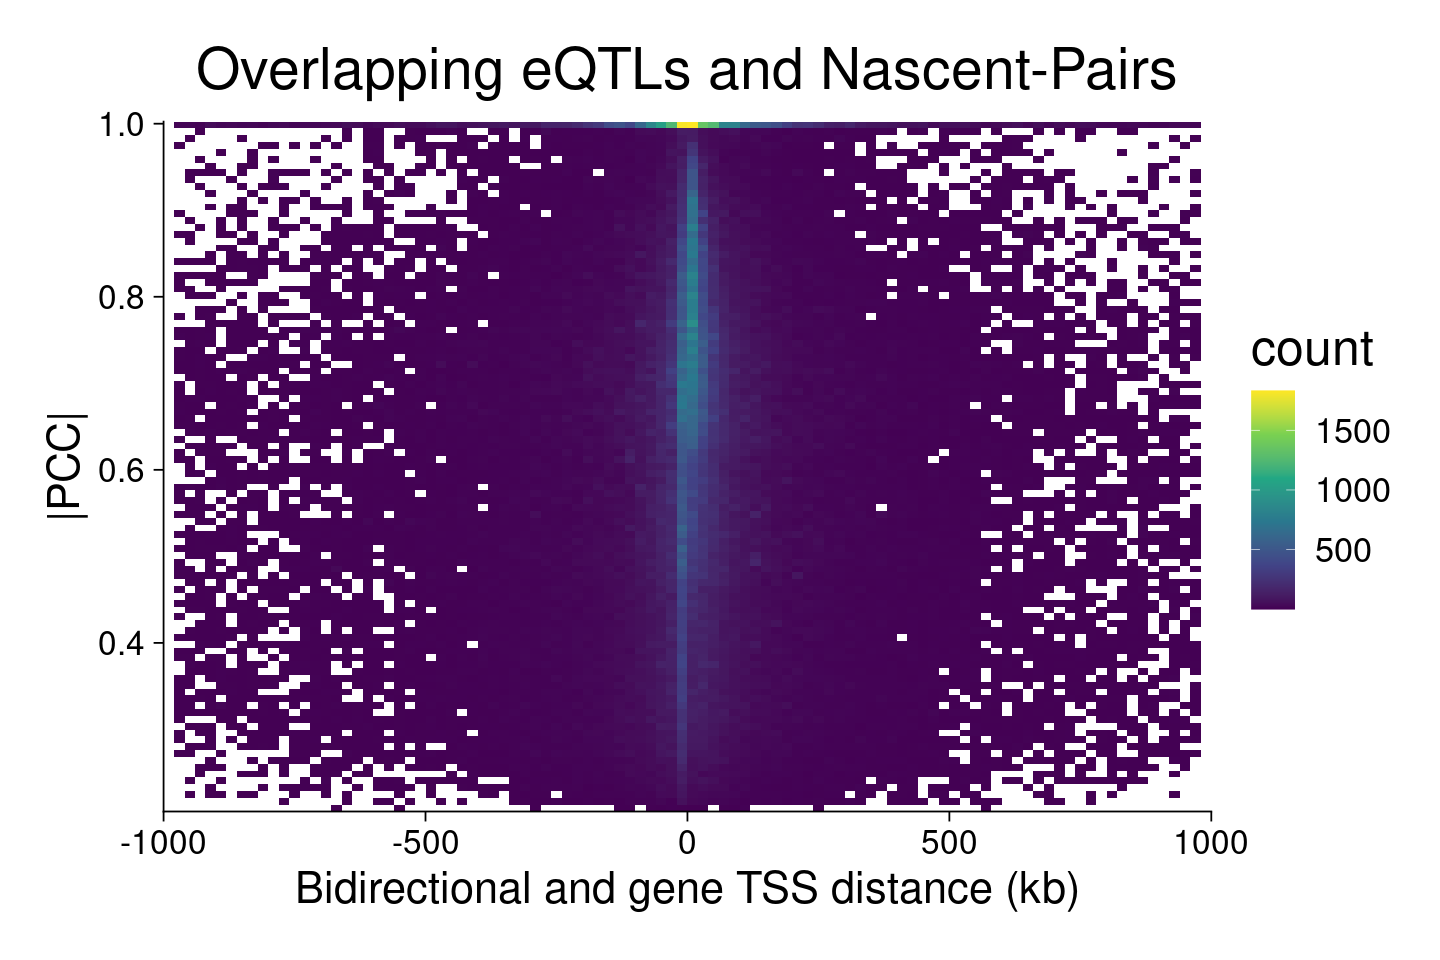

In [83]:
options(repr.plot.width=12, repr.plot.height=8)

##78,616 nascent pairs
##123,919 gtex eQTLs
gtex_nascent_overlap_plot <- ggplot(sig_pair_gtex_overlaps_matched_tissue, 
       aes(x = distance_tss/1000, y = abs(pcc))) + 
geom_bin2d(bins = 100) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0),
                  limits = c(-1000, 1000)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Overlapping eQTLs and Nascent-Pairs") +
ylab("|PCC|") +
xlab("Bidirectional and gene TSS distance (kb)") +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

gtex_nascent_overlap_plot

In [84]:
ggsave(gtex_nascent_overlap_plot, width = 12, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_nascent_overlap_distance_pcc_plot_reviews.pdf',
      bg = "transparent")

ggsave(gtex_nascent_overlap_plot, width = 12, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_nascent_overlap_distance_pcc_plot_reviews.png',
      bg = "transparent")

ggsave(gtex_nascent_overlap_plot, width = 12, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_nascent_overlap_distance_pcc_plot_reviews.svg',
      bg = "transparent")

Warning message:
“Removed 89 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 89 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 89 rows containing missing values or values outside the scale range
(`geom_tile()`).”


### Save GTEx supported pairs

In [85]:
gtex_out_dir <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_eqtl_nascent_pairs_matched"
gtex_out_file <- paste0(gtex_out_dir, "/sig_pair_gtex_overlaps_matched_tissue.tsv.gz")

data.table::fwrite(sig_pair_gtex_overlaps_matched_tissue,
                   gtex_out_file,
                   sep='\t')

# Getting overlaps

In [86]:
percent_eqtls <- list()
percent_npairs <- list()

#overlapping genes
shared_genes <- intersect(unique(refseq$gene_name),
                          unique(egene_files_DT$gene_name))

##get pairs where genes and bidirs are shared
gtex_pairs_geneid <- merge(gtex_blood, egene_files_DT_uniq, by="gene_id")

print("------------------------")
print("NascentPair:GTEx:Overlap Tissues")
print("------------------------")
for (i in tissue_option_pattern){
    
    print("............")
    print(i)
    np_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 1))
    gt_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 2))
    ov_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 3))
    
    #get overlap with GTEx
    closest_gtex_tissue_overlaps <- map_overlaps(overlap_DT=overlap_matched_list[[ov_tissue]], 
                                                 egene_ids=egene_files_DT_uniq, 
                                                 nascent_pairs=bidir_gene_dist_near_txpt)
    
    #number of shared GTEx eQTLs 
    gtex_pairs_shared <- gtex_pairs_geneid[gtex_pairs_geneid$gene_name %in% shared_genes & 
                                gtex_pairs_geneid$variant_id %in% unique(overlap_matched_list[[ov_tissue]]$variant_id),]

    #number of shared NascentPairs
    nascent_pairs_shared <- bidir_gene_dist_near_txpt[bidir_gene_dist_near_txpt$nascent_gene_id %in% shared_genes &
                                      bidir_gene_dist_near_txpt$bidir_id %in% unique(overlap_matched_list[[ov_tissue]]$bidir_id) ,]
    
    #save the 
    percent_eqtls[[i]] <- 100*(closest_gtex_tissue_overlaps$eqtl_overlap/length(unique(gtex_pairs_shared$variant_id)))
    percent_npairs[[i]] <- 100*(closest_gtex_tissue_overlaps$nascent_pair_overlap/length(unique(nascent_pairs_shared$pair_id)))

}

[1] "------------------------"
[1] "NascentPair:GTEx:Overlap Tissues"
[1] "------------------------"
[1] "............"
[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"
[1] "............"
[1] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"
[1] "............"
[1] "intestine:Colon_Transverse:Colon_Transverse_intestine"
[1] "............"
[1] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"
[1] "............"
[1] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"
[1] "............"
[1] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"
[1] "............"
[1] "lung:Lung:Lung_lung"
[1] "............"
[1] "prostate:Prostate:Prostate_prostate"
[1] "............"
[1] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[1] "............"
[1] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"
[1] "............"
[1] "uterus:Uterus:Uterus_uterus"
[1] "............"
[1] "blood:Whole_Blood:Whole_Blood_blood"


In [87]:
closest_gtex_overlaps_summary <- data.frame(percent_eqtl=as.numeric(percent_eqtls),
                                            percent_npairs=as.numeric(percent_npairs))

closest_gtex_overlaps_summary$tissues_temp <- names(percent_eqtls)
closest_gtex_overlaps_summary$gtex_tissues <- as.character(lapply(strsplit(closest_gtex_overlaps_summary$tissues_temp,
                                                                           ':'),`[`, 2)) 
closest_gtex_overlaps_summary$bidir_tissues <- as.character(lapply(strsplit(closest_gtex_overlaps_summary$tissues_temp,
                                                                           ':'),`[`, 1)) 
closest_gtex_overlaps_summary$tissues <- paste0(closest_gtex_overlaps_summary$bidir_tissues,
                                               " & ",
                                               closest_gtex_overlaps_summary$gtex_tissues)
closest_gtex_overlaps_summary$tissues <- factor(closest_gtex_overlaps_summary$tissues,
                                 levels=tissue_levels)
closest_gtex_overlaps_summary          

percent_eqtl percent_npairs
1  18.07651     32.68565      
2  17.95540     32.59913      
3  18.81859     33.54103      
4  19.36058     33.96628      
5  18.37948     33.86355      
6  12.50977     27.30936      
7  20.64978     35.65287      
8  14.21988     28.43118      
9  23.27391     36.88307      
10 25.31485     38.32725      
11 12.50271     26.90698      
12 13.77384     37.32677      
   tissues_temp                                                             
1  breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast                
2  intestine:Colon_Sigmoid:Colon_Sigmoid_intestine                          
3  intestine:Colon_Transverse:Colon_Transverse_intestine                    
4  heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart                
5  heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart                    
6  kidney:Kidney_Cortex:Kidney_Cortex_kidney                                
7  lung:Lung:Lung_lung                                                      
8  prostate:Prostate:Prostate_prostate                                      
9  skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin
10 skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin          
11 uterus:Uterus:Uterus_uterus                                              
12 blood:Whole_Blood:Whole_Blood_blood                                      
   gtex_tissues                    bidir_tissues
1  Breast_Mammary_Tissue           breast       
2  Colon_Sigmoid                   intestine    
3  Colon_Transverse                intestine    
4  Heart_Atrial_Appendage          heart        
5  Heart_Left_Ventricle            heart        
6  Kidney_Cortex                   kidney       
7  Lung                            lung         
8  Prostate                        prostate     
9  Skin_Not_Sun_Exposed_Suprapubic skin         
10 Skin_Sun_Exposed_Lower_leg      skin         
11 Uterus                          uterus       
12 Whole_Blood                     blood        
   tissues                               
1  breast & Breast_Mammary_Tissue        
2  intestine & Colon_Sigmoid             
3  intestine & Colon_Transverse          
4  heart & Heart_Atrial_Appendage        
5  heart & Heart_Left_Ventricle          
6  kidney & Kidney_Cortex                
7  lung & Lung                           
8  prostate & Prostate                   
9  skin & Skin_Not_Sun_Exposed_Suprapubic
10 skin & Skin_Sun_Exposed_Lower_leg     
11 uterus & Uterus                       
12 blood & Whole_Blood

# Plot overlaps

## All on single plot

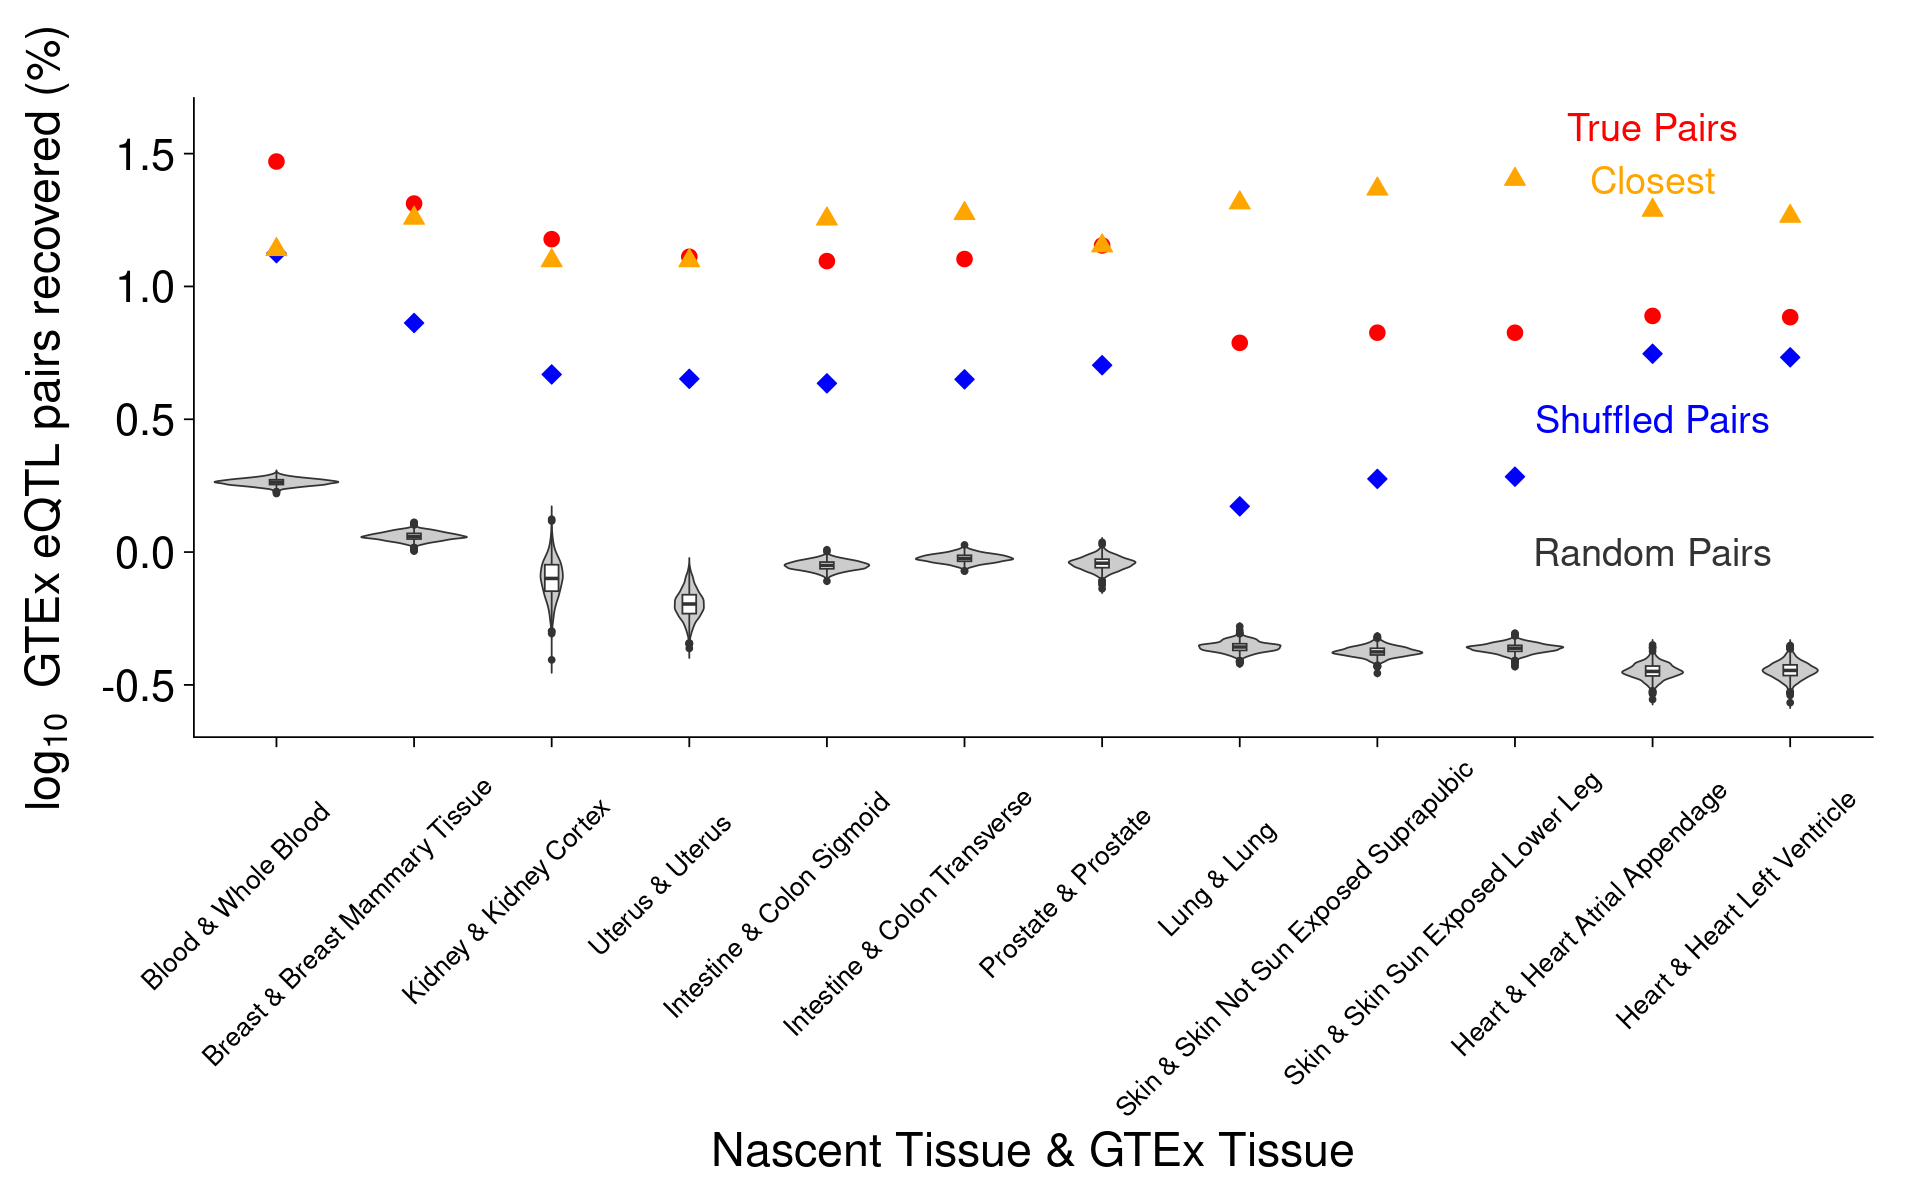

In [88]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sortD <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
geom_point(data=closest_gtex_overlaps_summary, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=24,
           size=4,
           fill="orange", 
           color="orange", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=11, 
         y=1.6, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=11, 
         y=1.4, 
         size=8,
         label="Closest",
         color="orange") +
annotate(geom="text",
         x=11, 
         y=0.5, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
annotate(geom="text",
         x=11, 
         y=0, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sortD

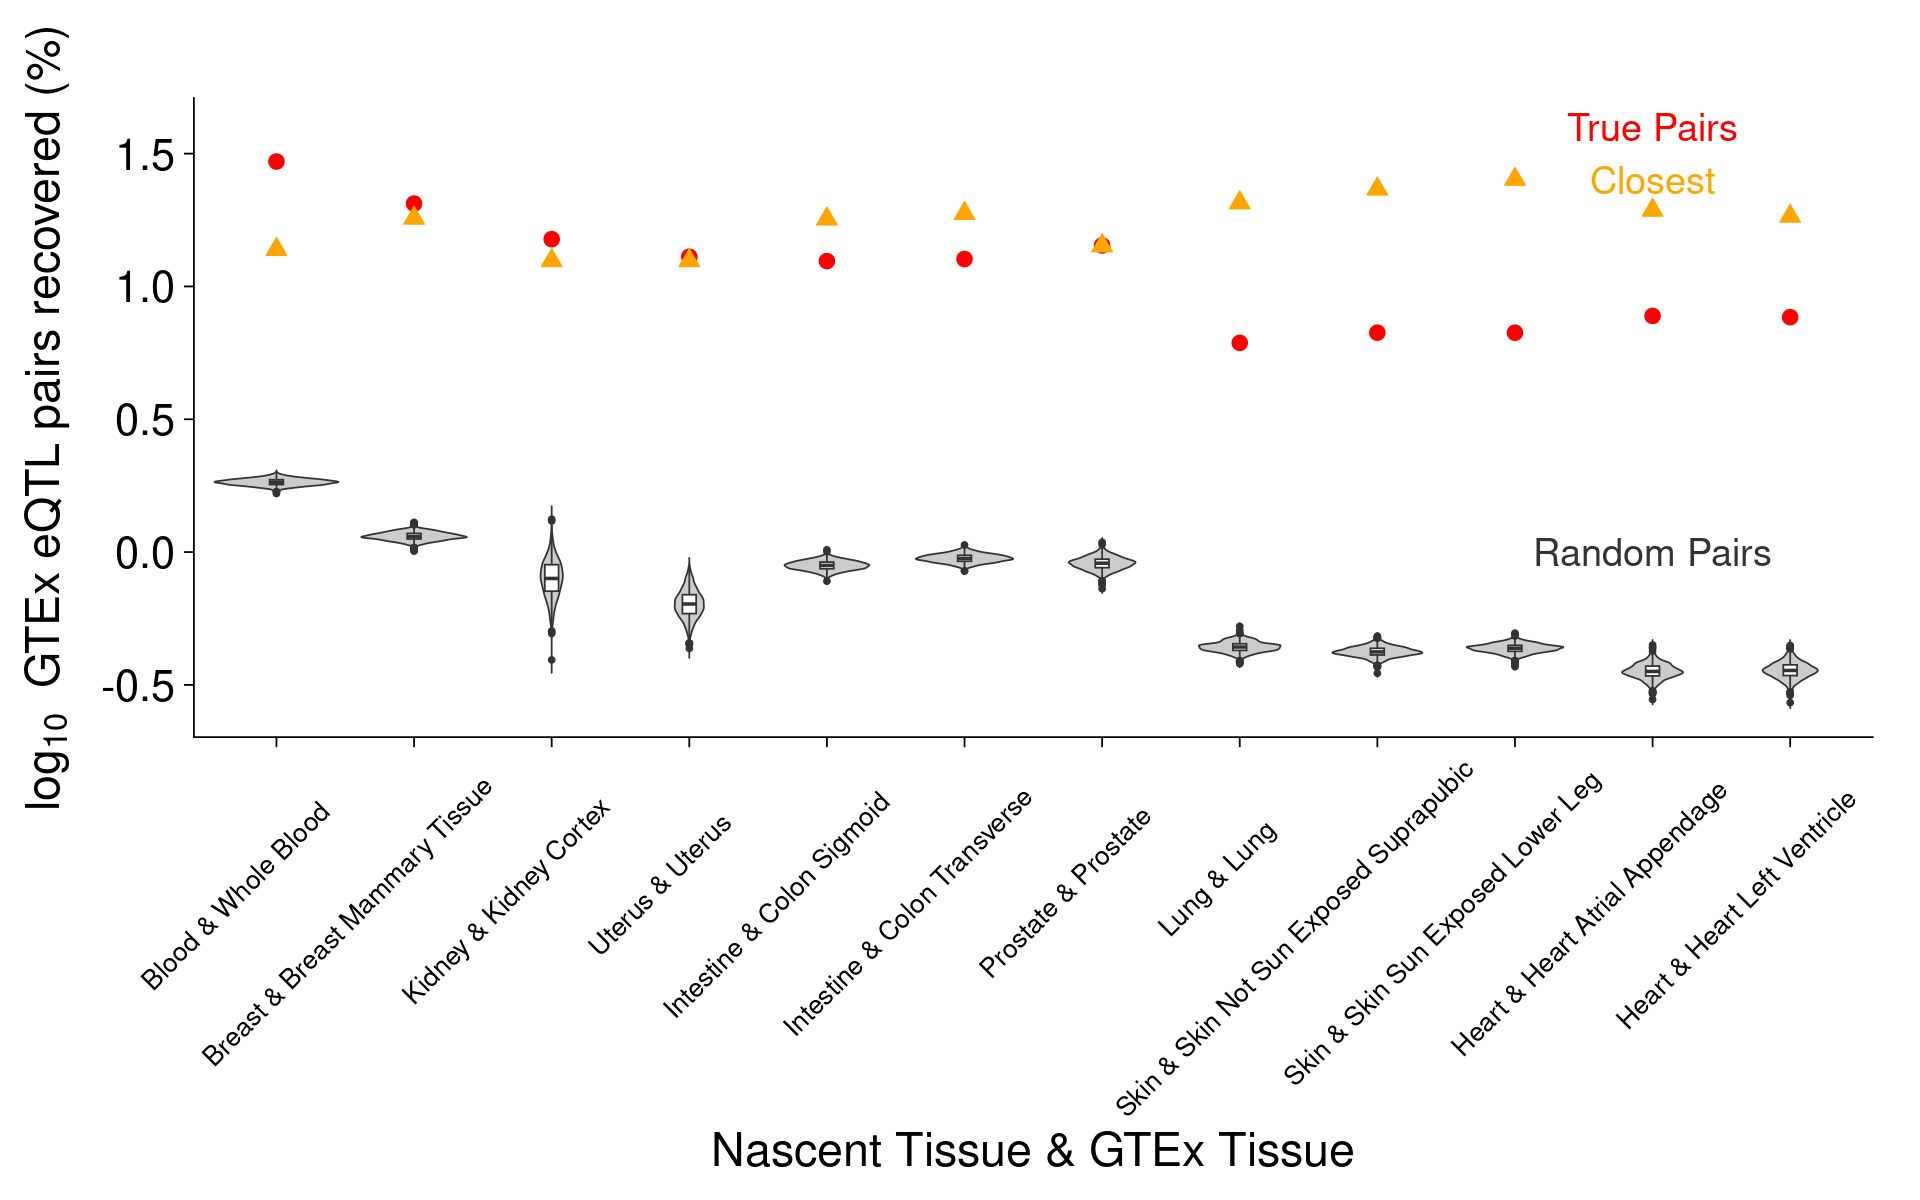

In [89]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sortE <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=closest_gtex_overlaps_summary, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           shape=24,
           size=4,
           fill="orange", 
           color="orange", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=11, 
         y=1.6, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=11, 
         y=1.4, 
         size=8,
         label="Closest",
         color="orange") +
annotate(geom="text",
         x=11, 
         y=0, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sortE

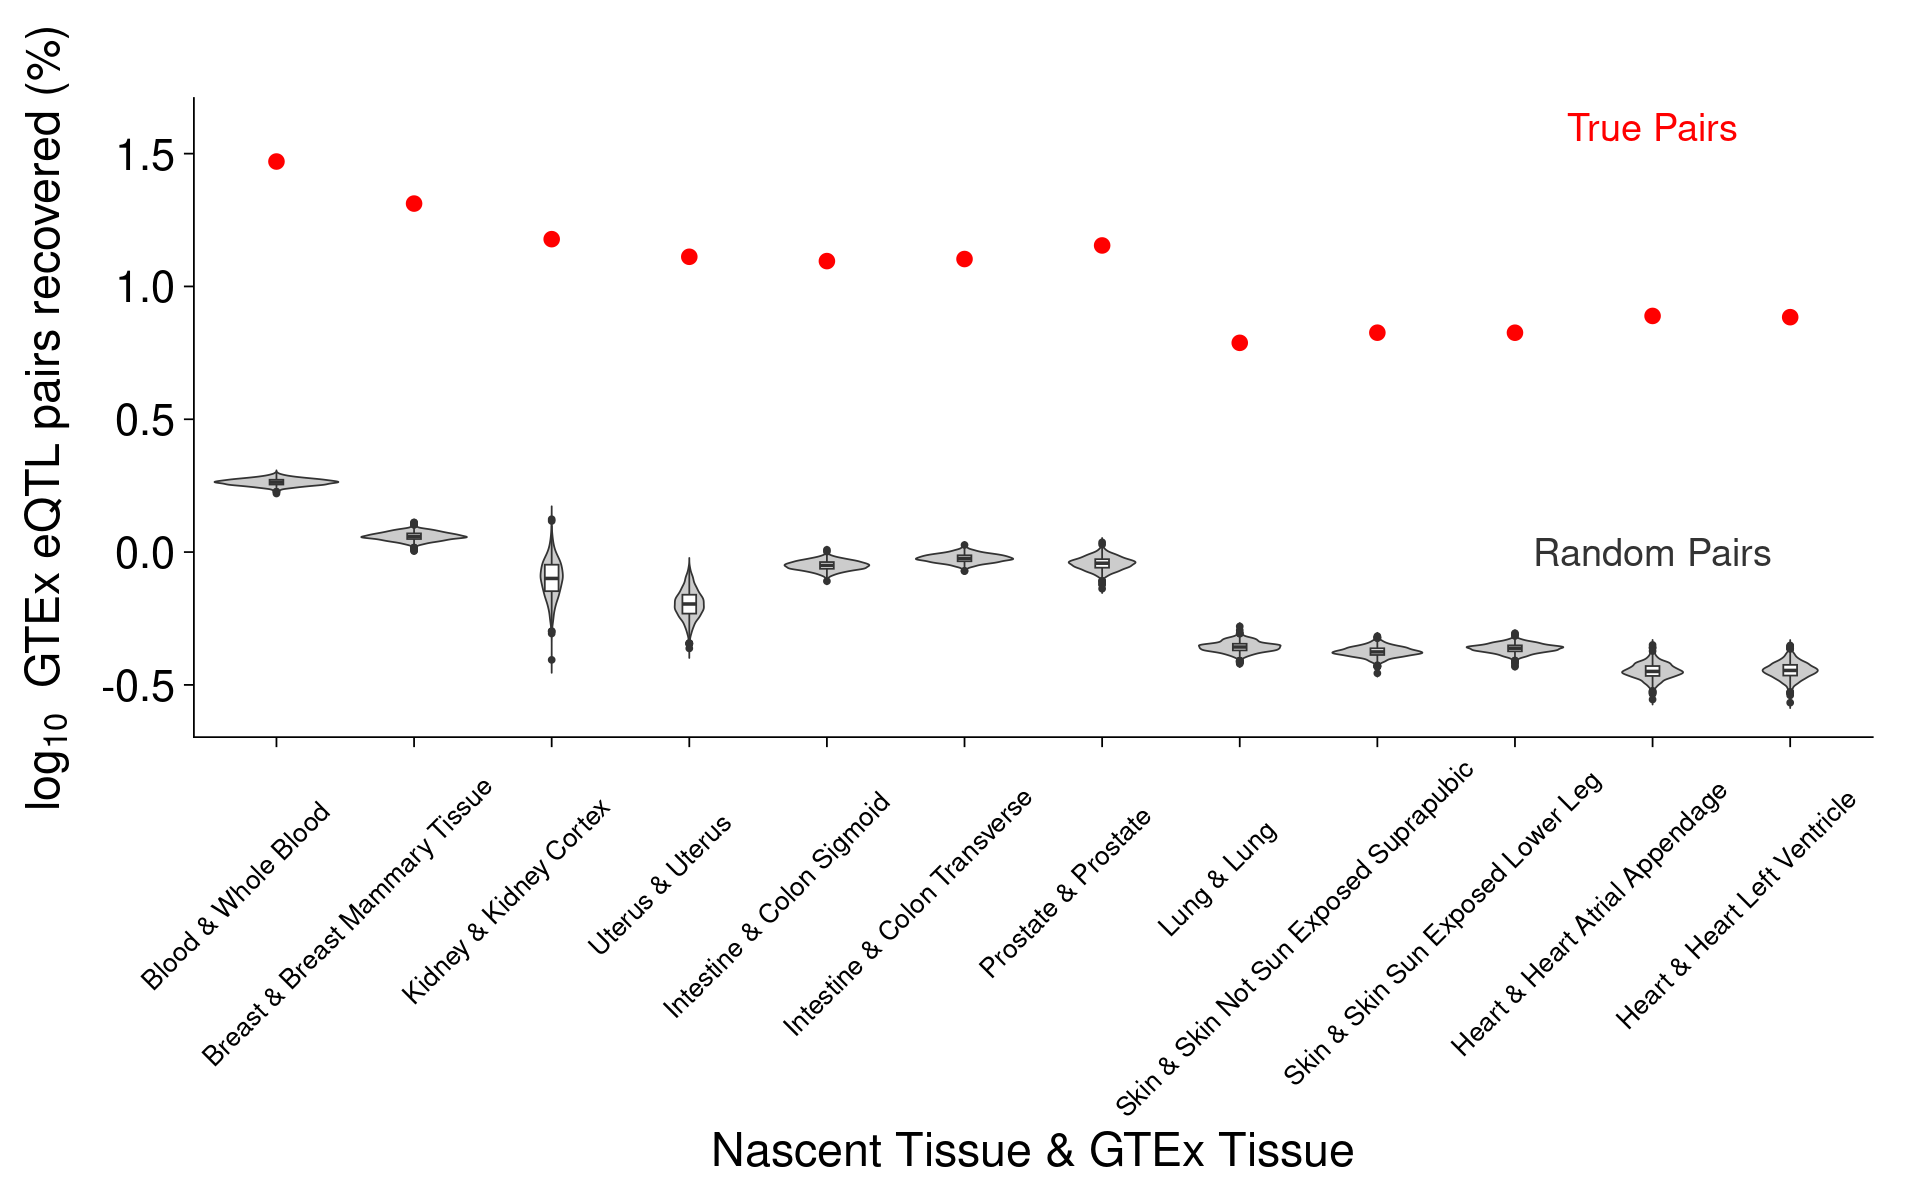

In [90]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sortF <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=log(percent_eqtl, 10)),
           size=4,
           color="red", 
           alpha=1) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=11, 
         y=1.6, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=11, 
         y=0, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sortF

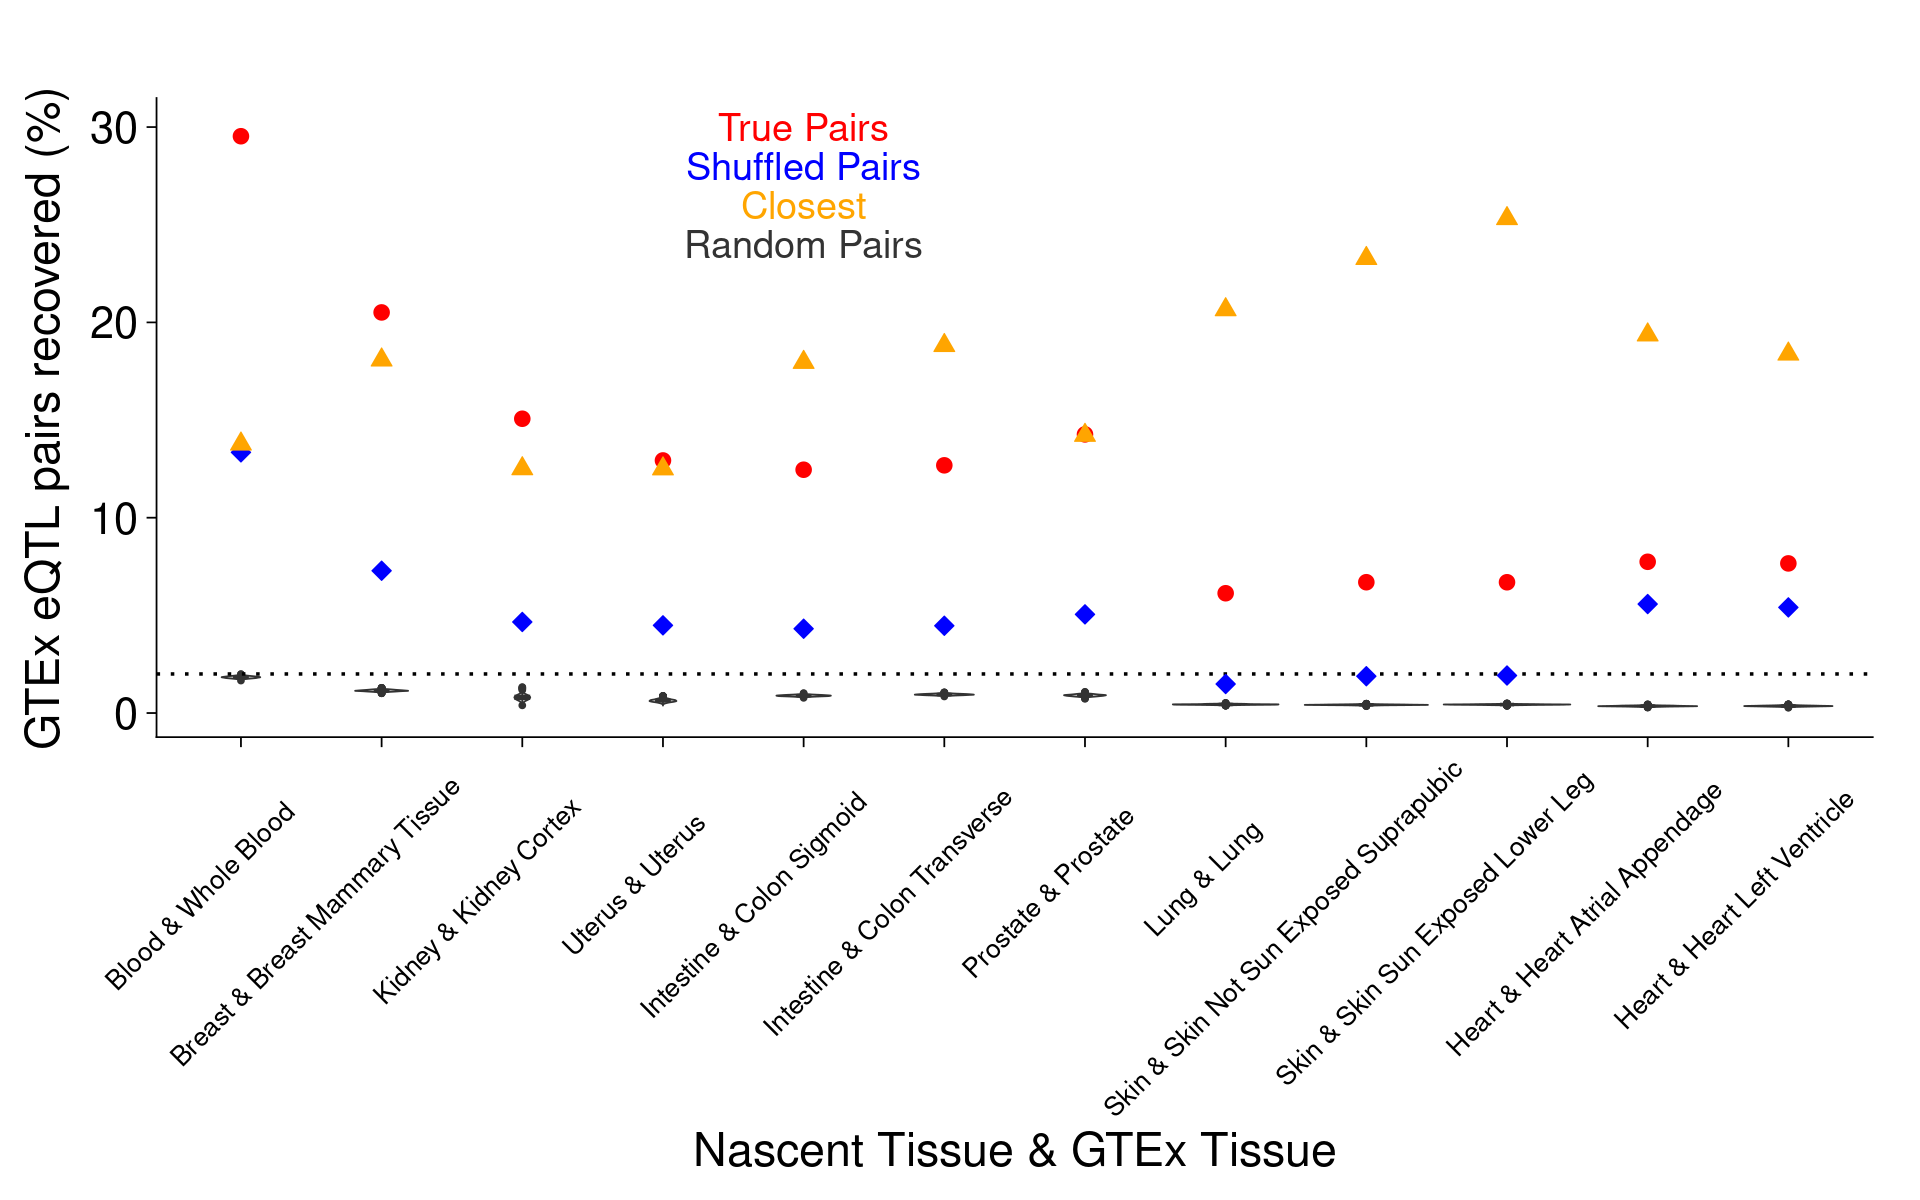

In [91]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_sortD <- ggplot(overlap_bed_DT, aes(x=tissues, y=(percent_eqtl))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_hline(yintercept=2,
          linetype="dotted", 
           color = "black", 
           linewidth=1) +
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
geom_point(data=closest_gtex_overlaps_summary, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=24,
           size=4,
           fill="orange", 
           color="orange", 
           alpha=1) +
labs(title = " ", 
       y =  expression("GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=5, 
         y=30, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=5, 
         y=28, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
annotate(geom="text",
         x=5, 
         y=26, 
         size=8,
         label="Closest",
         color="orange") +
annotate(geom="text",
         x=5, 
         y=24, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_sortD

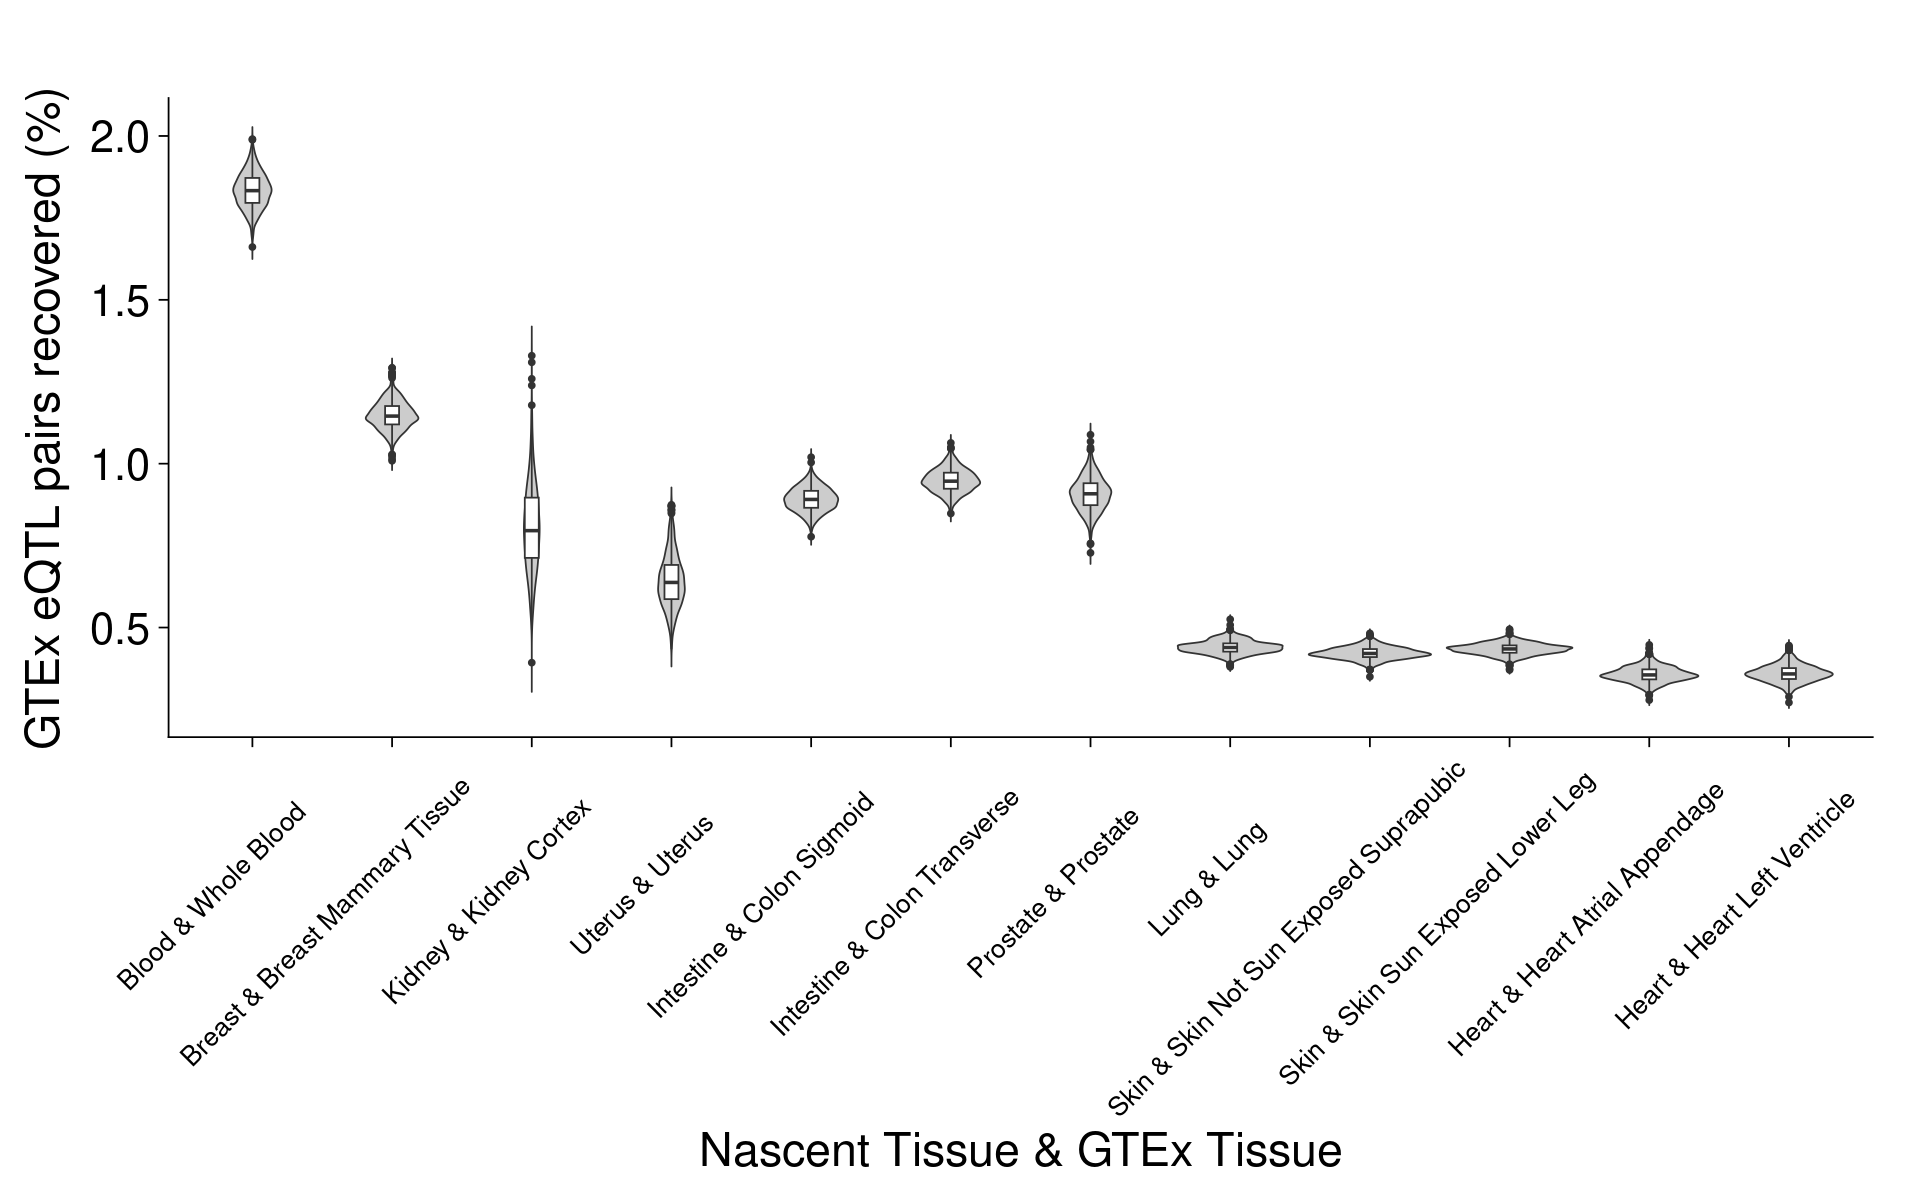

In [92]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_sortD_split <- ggplot(overlap_bed_DT, aes(x=tissues, y=(percent_eqtl))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
labs(title = " ", 
       y =  expression("GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_sortD_split

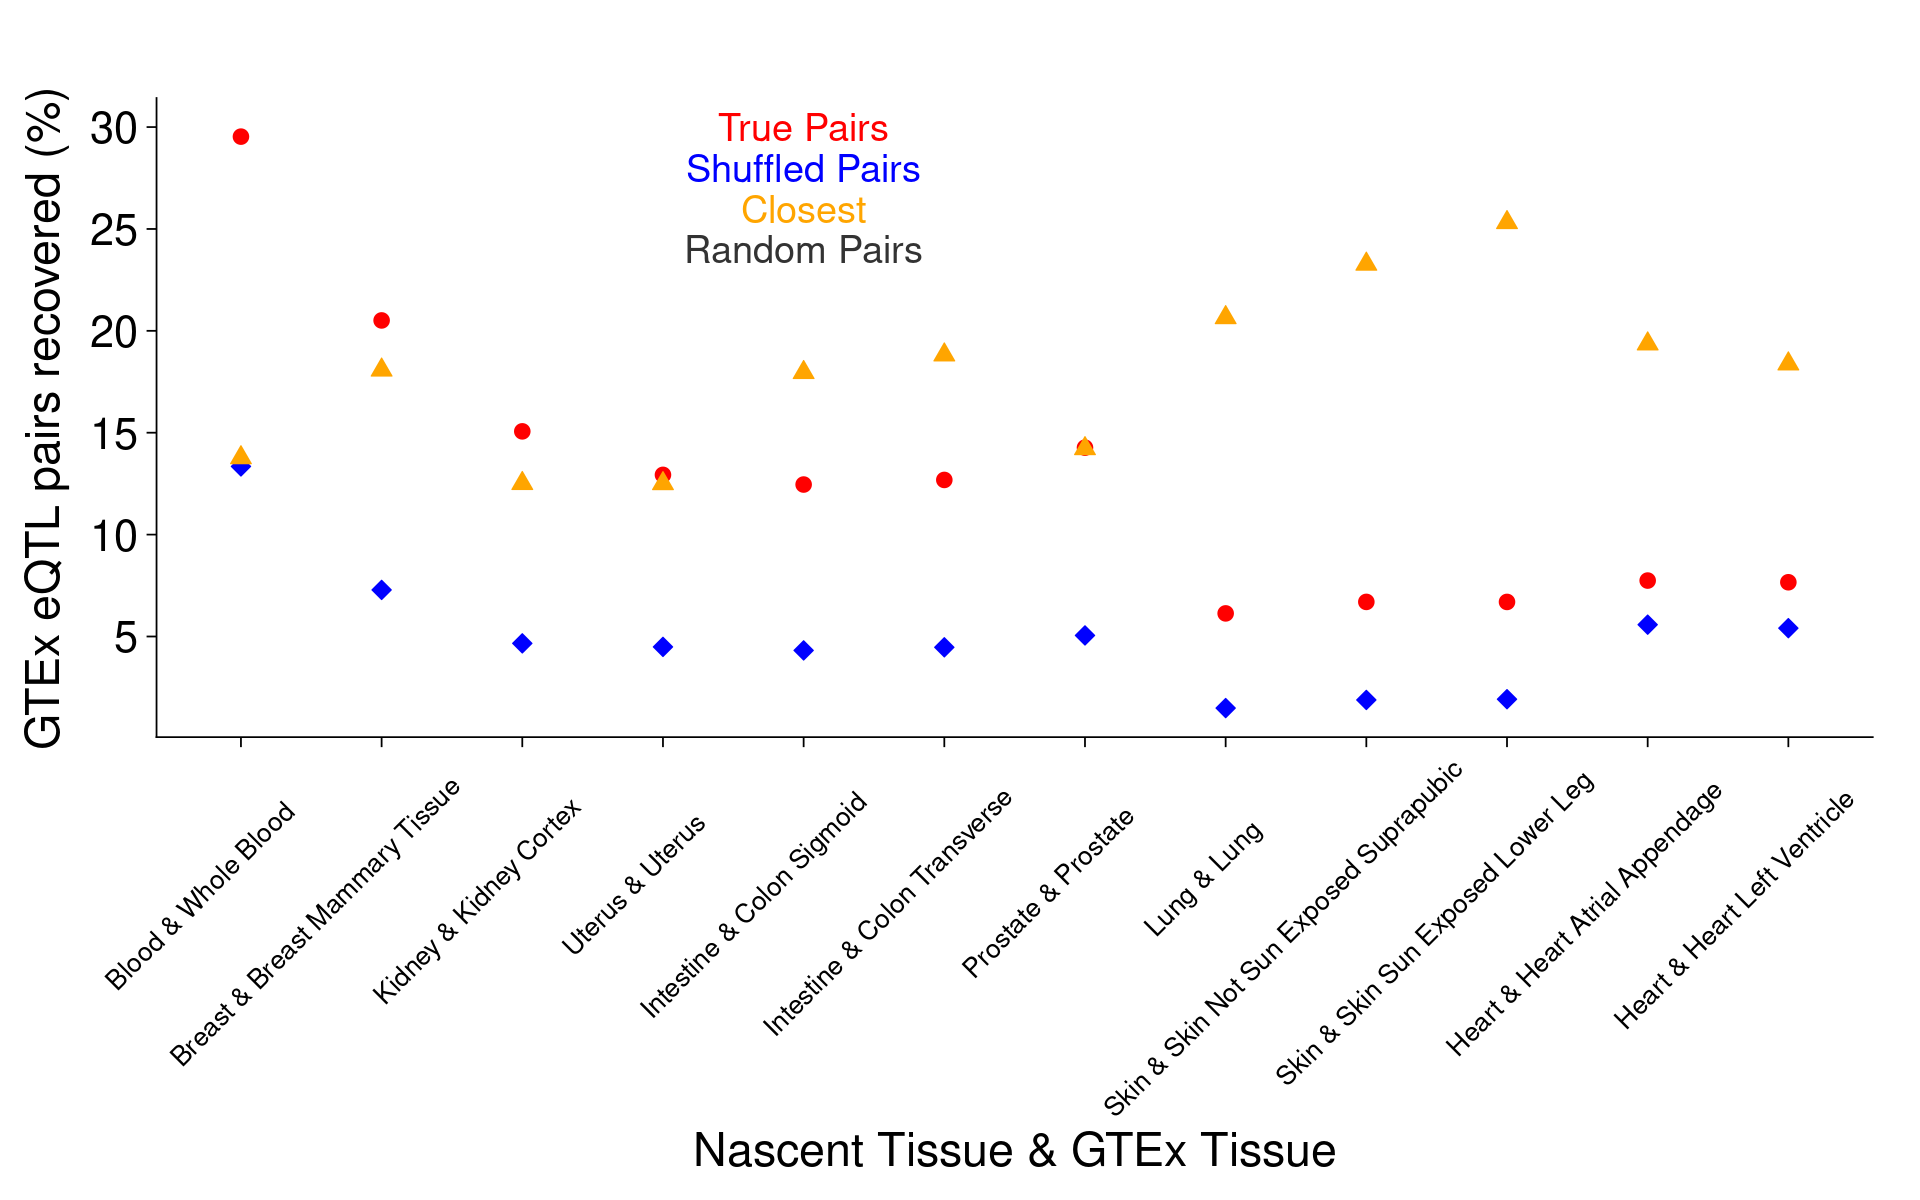

In [93]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_sortD_split_top <- ggplot() +
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
geom_point(data=closest_gtex_overlaps_summary, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=24,
           size=4,
           fill="orange", 
           color="orange", 
           alpha=1) +
labs(title = " ", 
       y =  expression("GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue") +
annotate(geom="text",
         x=5, 
         y=30, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=5, 
         y=28, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
annotate(geom="text",
         x=5, 
         y=26, 
         size=8,
         label="Closest",
         color="orange") +
annotate(geom="text",
         x=5, 
         y=24, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks = seq(0, 30, 5)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_sortD_split_top

## Split plots

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


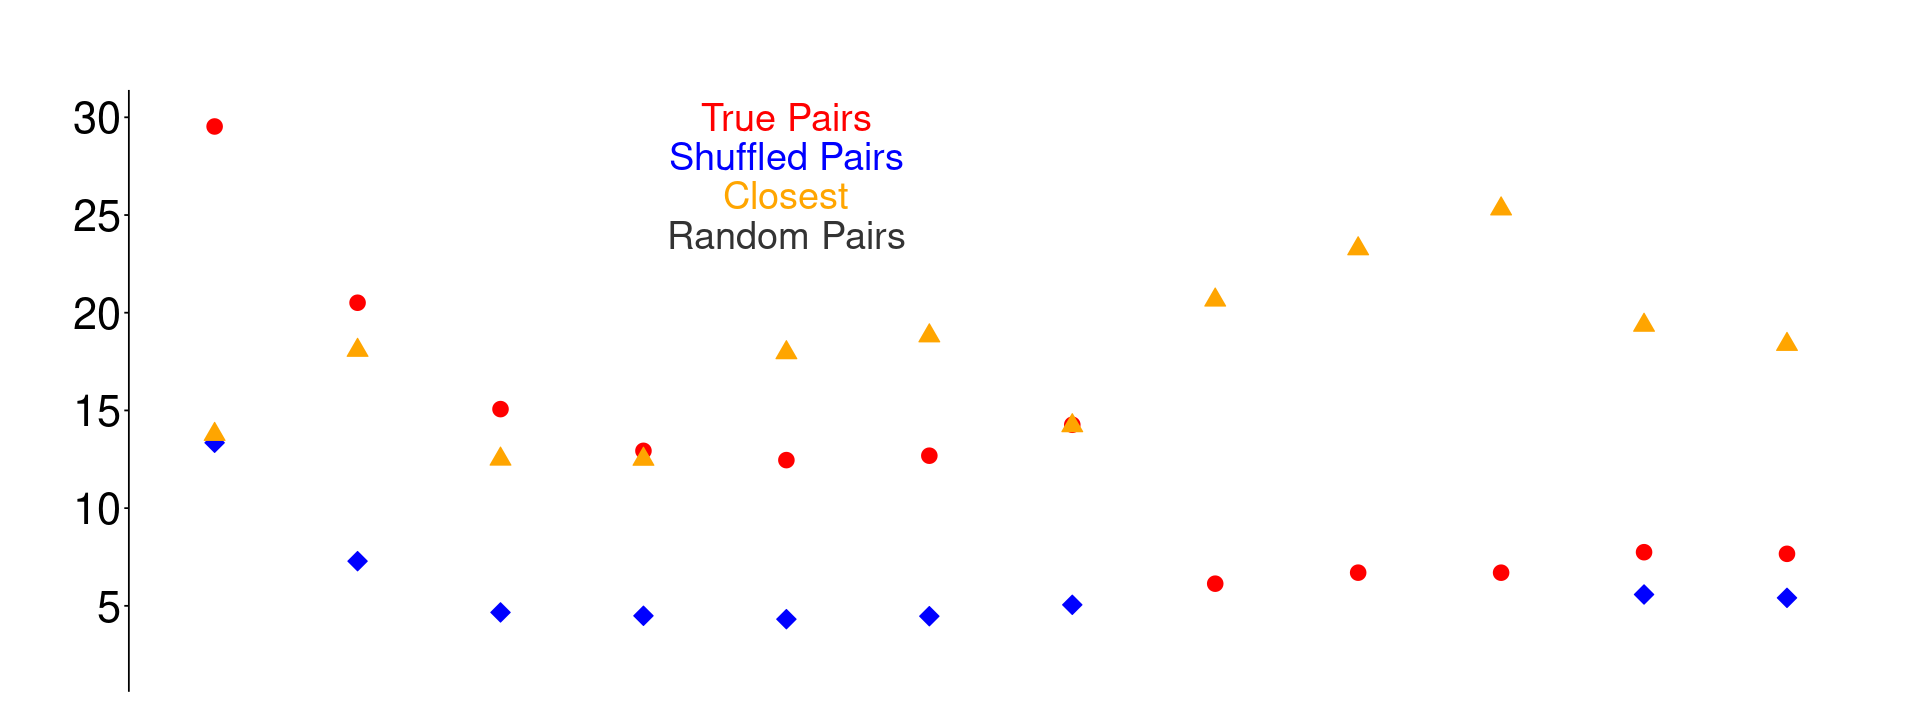

In [94]:
options(repr.plot.width=16, repr.plot.height=6)

# Use single color
overlap_plot_sortD_split_top2 <- ggplot() +
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
geom_point(data=closest_gtex_overlaps_summary, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=24,
           size=4,
           fill="orange", 
           color="orange", 
           alpha=1) +
labs(title = " ", 
       y = " ", 
       x = " ") +
annotate(geom="text",
         x=5, 
         y=30, 
         size=8,
         label="True Pairs",
         color="red") +
annotate(geom="text",
         x=5, 
         y=28, 
         size=8,
         label="Shuffled Pairs",
         color="blue") +
annotate(geom="text",
         x=5, 
         y=26, 
         size=8,
         label="Closest",
         color="orange") +
annotate(geom="text",
         x=5, 
         y=24, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks = seq(0, 30, 5),
                  limits=c(2,30)) +
#theme_cowplot(24) +
theme_bw() +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.title.x=element_blank(),
      axis.text.x=element_blank(),
      axis.ticks.x=element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.grid.minor = element_blank()) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm")) +
theme(axis.line.y = element_line(color = "black"), 
        axis.ticks.y = element_line(color = "black"),
        axis.text.y = element_text(color = "black"), 
        axis.title.y = element_text(color = "black")
        ) 


 #panel.grid.minor = element_blank(),
 #   panel.border = element_blank(
overlap_plot_sortD_split_top2

Warning message:
“Removed 35 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


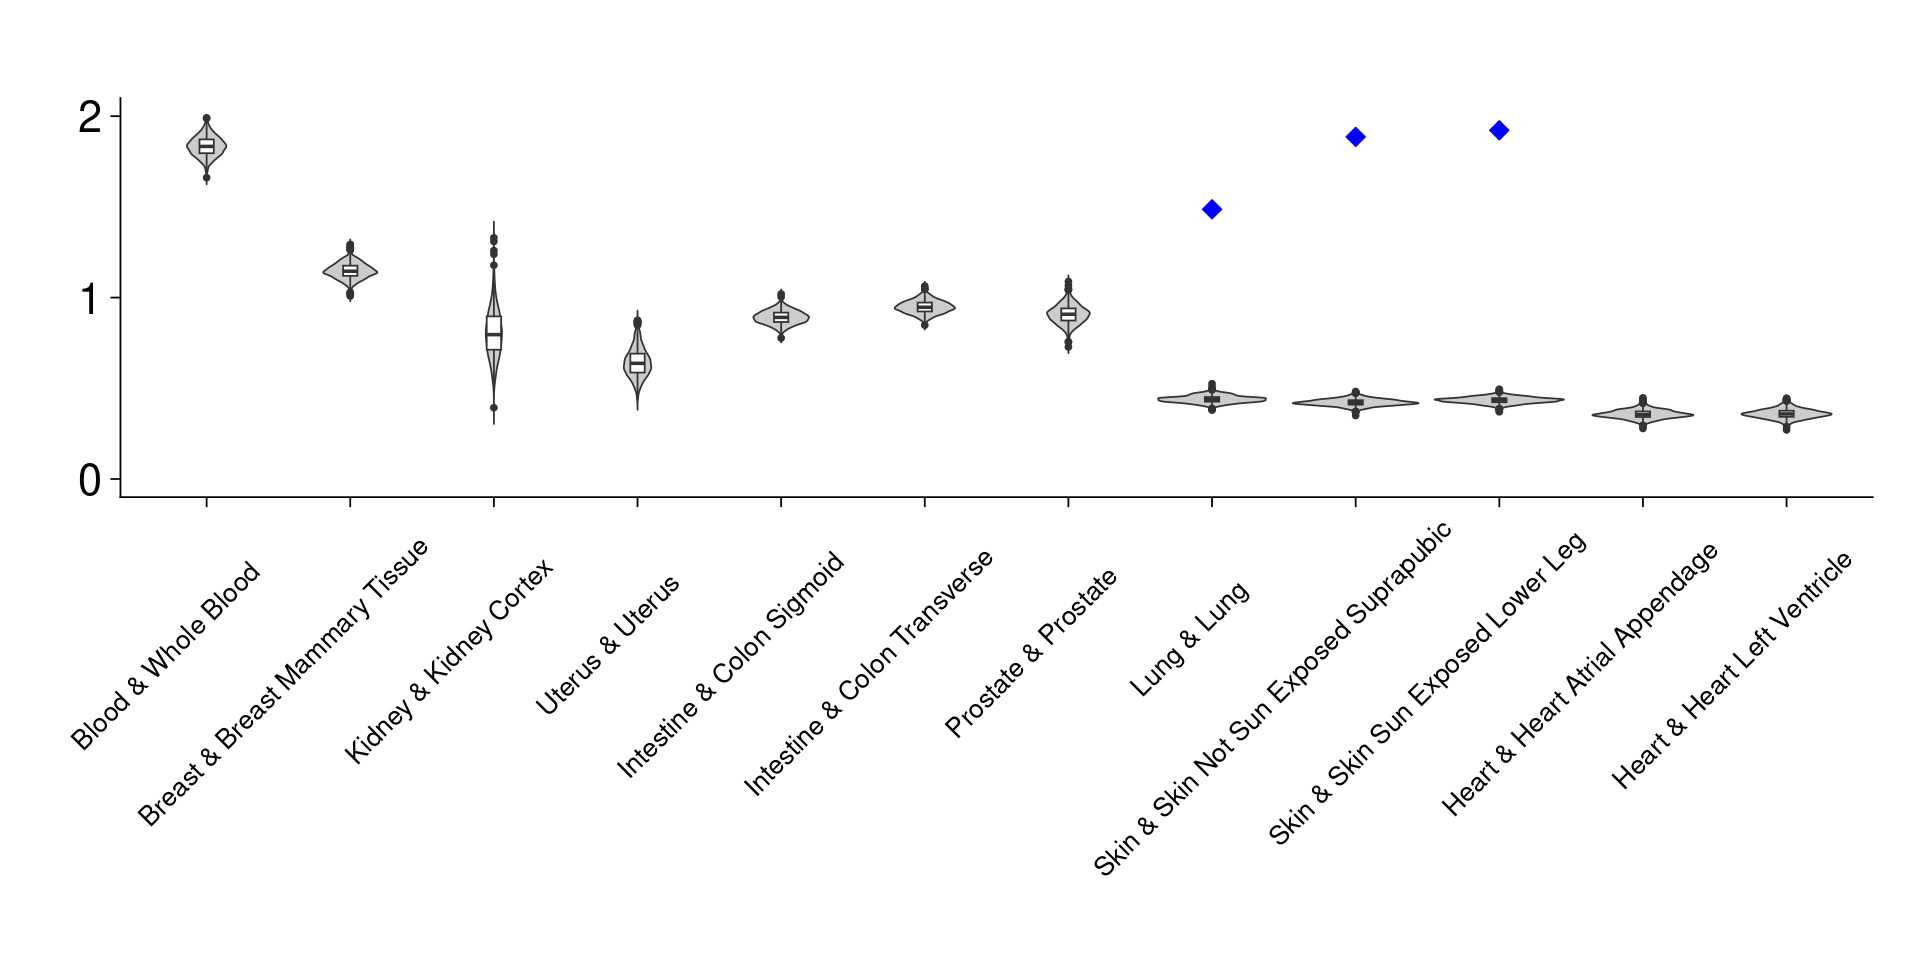

In [95]:
options(repr.plot.width=16, repr.plot.height=8)

# Use single color
overlap_plot_sortD_split2 <- ggplot(overlap_bed_DT, aes(x=tissues, y=(percent_eqtl))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) +
geom_point(data=true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           size=4,
           color="red", 
           alpha=1) +
geom_point(data=swapped_true_overlap_bed_DT, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=23,
           size=4,
           fill="blue", 
           color="blue", 
           alpha=1) +
geom_point(data=closest_gtex_overlaps_summary, 
           aes(x=tissues, y=(percent_eqtl)),
           shape=24,
           size=4,
           fill="orange", 
           color="orange", 
           alpha=1) +
labs(title = " ", 
       y = " ", 
       x = " ") +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks=c(0,1,2),
                   limits=c(0,2)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_sortD_split2

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 35 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


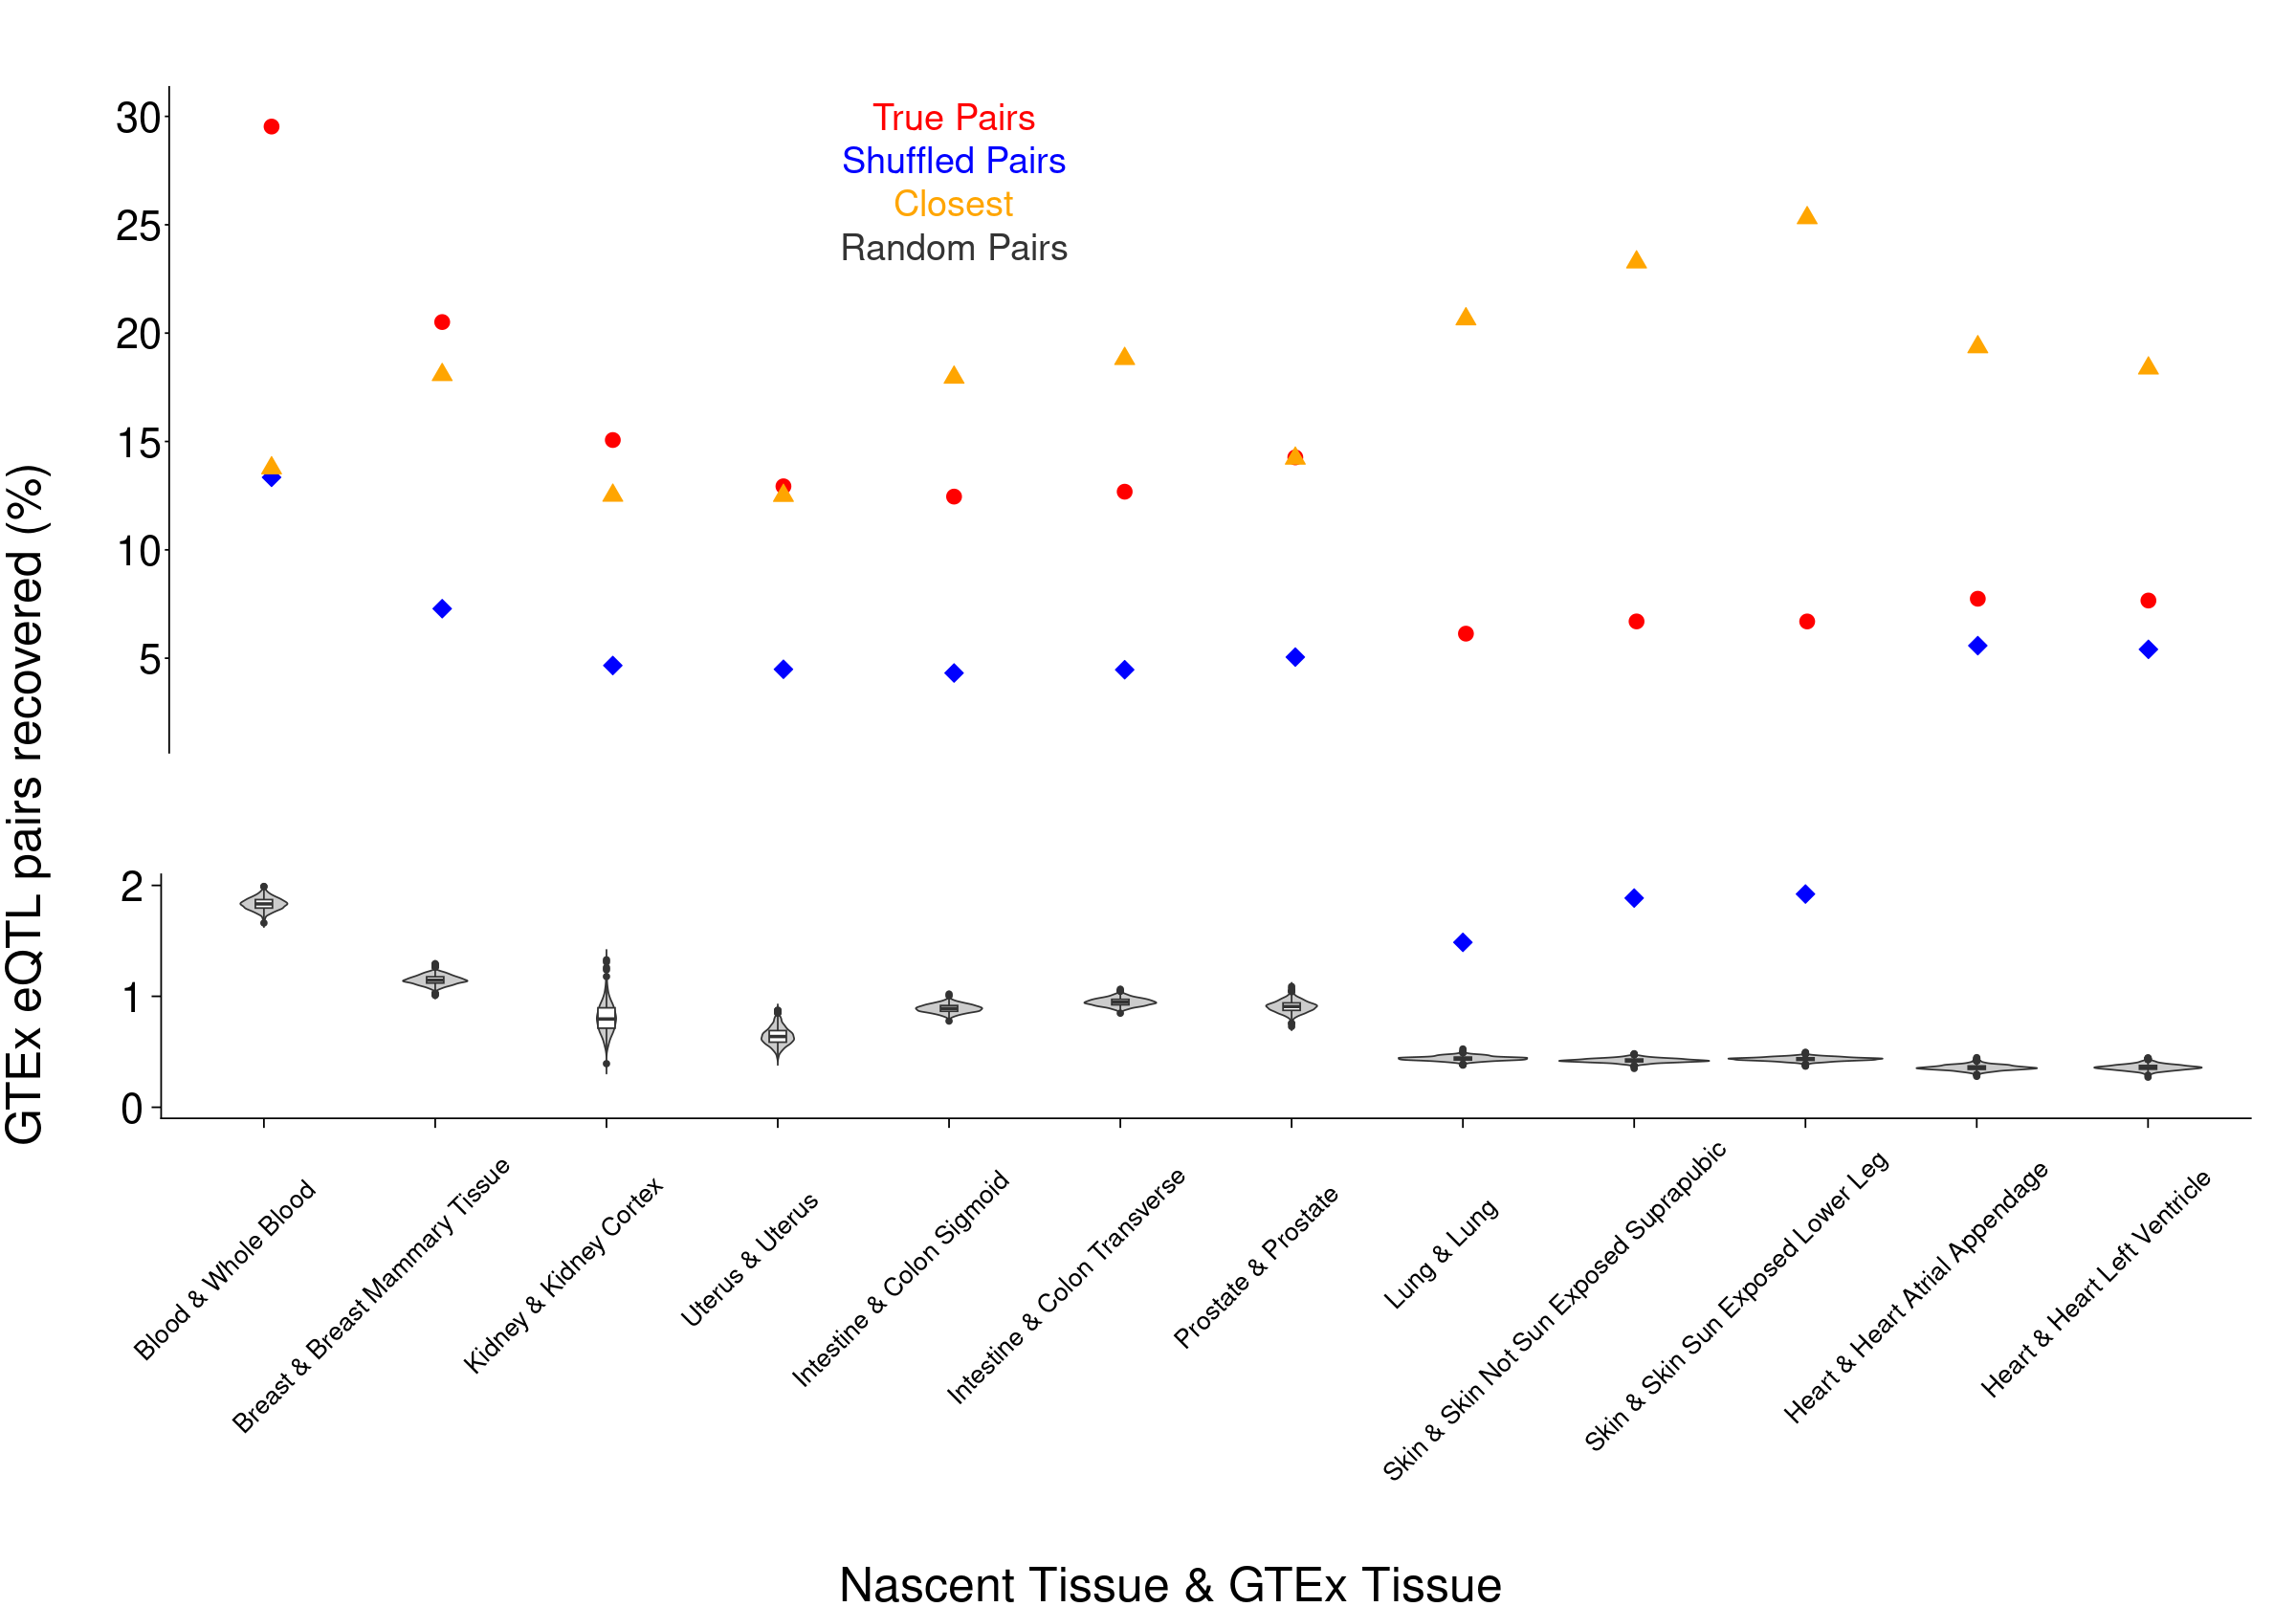

In [96]:
options(repr.plot.width=20, repr.plot.height=14)

plot<-plot_grid(overlap_plot_sortD_split_top2,
                overlap_plot_sortD_split2, ncol = 1,
               rel_heights = c(1, 1))

#create common x and y labels

y.grob <- textGrob("GTEx eQTL pairs recovered (%)", 
                   gp=gpar(fontface="plain", col="black", fontsize=30), rot=90)

x.grob <- textGrob("Nascent Tissue & GTEx Tissue", 
                   gp=gpar(fontface="plain", col="black", fontsize=30))

#add to plot

grid.arrange(arrangeGrob(plot, left = y.grob, bottom = x.grob))

## High sample tissues

In [97]:
true_overlap_bed_DT
swapped_true_overlap_bed_DT
closest_gtex_overlaps_summary

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1  62488        56050                29.530633    7.868798             
2  28262        24184                20.510476    6.206596             
3  11397         9294                 7.744369    5.969708             
4  10345         8217                 7.661487    5.712637             
5  16381        13615                12.457034    5.356356             
6  18128        15184                12.682865    5.545897             
7   1496         1110                15.066976    3.573843             
8  11706         9825                 6.133581    8.152309             
9  10290         8580                14.266304    4.790219             
10 14608        12690                 6.697477    8.594533             
11 16792        14978                 6.695909    9.282292             
12  3874         2770                12.931869    3.911159             
   p_value_nascent p_value_eqtl tissues                               
1  0.000999001     0.000999001  blood & Whole_Blood                   
2  0.000999001     0.000999001  breast & Breast_Mammary_Tissue        
3  0.000999001     0.000999001  heart & Heart_Atrial_Appendage        
4  0.000999001     0.000999001  heart & Heart_Left_Ventricle          
5  0.000999001     0.000999001  intestine & Colon_Sigmoid             
6  0.000999001     0.000999001  intestine & Colon_Transverse          
7  0.000999001     0.000999001  kidney & Kidney_Cortex                
8  0.000999001     0.000999001  lung & Lung                           
9  0.000999001     0.000999001  prostate & Prostate                   
10 0.000999001     0.000999001  skin & Skin_Not_Sun_Exposed_Suprapubic
11 0.000999001     0.000999001  skin & Skin_Sun_Exposed_Lower_leg     
12 0.000999001     0.000999001  uterus & Uterus                       
   tissues_mixed
1  Same         
2  Same         
3  Same         
4  Same         
5  Same         
6  Same         
7  Same         
8  Same         
9  Same         
10 Same         
11 Same         
12 Same

eqtl_overlap nascent_pair_overlap percent_eqtl percent_nascent_pairs
1  28241        23606                13.346156    6.790846             
2  10039         8137                 7.285566    5.652186             
3   8212         7081                 5.580131    5.430298             
4   7303         6238                 5.408588    5.260805             
5   5677         4413                 4.317110    4.816056             
6   6388         4977                 4.469227    5.002463             
7    463          328                 4.663108    3.424157             
8   2837         2220                 1.486500    6.314891             
9   3644         2926                 5.052130    4.469359             
10  4113         3348                 1.885728    6.595225             
11  4820         3993                 1.922003    7.078909             
12  1345         1009                 4.489769    3.585516             
   p_value_nascent p_value_eqtl tissues                               
1  0.000999001     0.000999001  blood & Whole_Blood                   
2  0.000999001     0.000999001  breast & Breast_Mammary_Tissue        
3  0.000999001     0.000999001  heart & Heart_Atrial_Appendage        
4  0.000999001     0.000999001  heart & Heart_Left_Ventricle          
5  0.000999001     0.000999001  intestine & Colon_Sigmoid             
6  0.000999001     0.000999001  intestine & Colon_Transverse          
7  0.000999001     0.000999001  kidney & Kidney_Cortex                
8  0.000999001     0.000999001  lung & Lung                           
9  0.000999001     0.000999001  prostate & Prostate                   
10 0.000999001     0.000999001  skin & Skin_Not_Sun_Exposed_Suprapubic
11 0.000999001     0.000999001  skin & Skin_Sun_Exposed_Lower_leg     
12 0.000999001     0.000999001  uterus & Uterus

percent_eqtl percent_npairs
1  18.07651     32.68565      
2  17.95540     32.59913      
3  18.81859     33.54103      
4  19.36058     33.96628      
5  18.37948     33.86355      
6  12.50977     27.30936      
7  20.64978     35.65287      
8  14.21988     28.43118      
9  23.27391     36.88307      
10 25.31485     38.32725      
11 12.50271     26.90698      
12 13.77384     37.32677      
   tissues_temp                                                             
1  breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast                
2  intestine:Colon_Sigmoid:Colon_Sigmoid_intestine                          
3  intestine:Colon_Transverse:Colon_Transverse_intestine                    
4  heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart                
5  heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart                    
6  kidney:Kidney_Cortex:Kidney_Cortex_kidney                                
7  lung:Lung:Lung_lung                                                      
8  prostate:Prostate:Prostate_prostate                                      
9  skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin
10 skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin          
11 uterus:Uterus:Uterus_uterus                                              
12 blood:Whole_Blood:Whole_Blood_blood                                      
   gtex_tissues                    bidir_tissues
1  Breast_Mammary_Tissue           breast       
2  Colon_Sigmoid                   intestine    
3  Colon_Transverse                intestine    
4  Heart_Atrial_Appendage          heart        
5  Heart_Left_Ventricle            heart        
6  Kidney_Cortex                   kidney       
7  Lung                            lung         
8  Prostate                        prostate     
9  Skin_Not_Sun_Exposed_Suprapubic skin         
10 Skin_Sun_Exposed_Lower_leg      skin         
11 Uterus                          uterus       
12 Whole_Blood                     blood        
   tissues                               
1  breast & Breast_Mammary_Tissue        
2  intestine & Colon_Sigmoid             
3  intestine & Colon_Transverse          
4  heart & Heart_Atrial_Appendage        
5  heart & Heart_Left_Ventricle          
6  kidney & Kidney_Cortex                
7  lung & Lung                           
8  prostate & Prostate                   
9  skin & Skin_Not_Sun_Exposed_Suprapubic
10 skin & Skin_Sun_Exposed_Lower_leg     
11 uterus & Uterus                       
12 blood & Whole_Blood

In [98]:
all_overlap_summary <- rbind(true_overlap_bed_DT[,c("percent_eqtl","tissues")], 
                             swapped_true_overlap_bed_DT[,c("percent_eqtl","tissues")],
                             closest_gtex_overlaps_summary[,c("percent_eqtl","tissues")])
all_overlap_summary$pair_type <- c(rep("DBNascent Pairs", 12),
                                   rep("Shuffled Pairs", 12),
                                   rep("Closest Pairs", 12))
all_overlap_summary$pair_type <- factor(all_overlap_summary$pair_type, 
                                        levels = c("DBNascent Pairs",
                                                  "Closest Pairs",
                                                  "Shuffled Pairs"))
all_overlap_summary

percent_eqtl tissues                                pair_type      
1  29.530633    blood & Whole_Blood                    DBNascent Pairs
2  20.510476    breast & Breast_Mammary_Tissue         DBNascent Pairs
3   7.744369    heart & Heart_Atrial_Appendage         DBNascent Pairs
4   7.661487    heart & Heart_Left_Ventricle           DBNascent Pairs
5  12.457034    intestine & Colon_Sigmoid              DBNascent Pairs
6  12.682865    intestine & Colon_Transverse           DBNascent Pairs
7  15.066976    kidney & Kidney_Cortex                 DBNascent Pairs
8   6.133581    lung & Lung                            DBNascent Pairs
9  14.266304    prostate & Prostate                    DBNascent Pairs
10  6.697477    skin & Skin_Not_Sun_Exposed_Suprapubic DBNascent Pairs
11  6.695909    skin & Skin_Sun_Exposed_Lower_leg      DBNascent Pairs
12 12.931869    uterus & Uterus                        DBNascent Pairs
13 13.346156    blood & Whole_Blood                    Shuffled Pairs 
14  7.285566    breast & Breast_Mammary_Tissue         Shuffled Pairs 
15  5.580131    heart & Heart_Atrial_Appendage         Shuffled Pairs 
16  5.408588    heart & Heart_Left_Ventricle           Shuffled Pairs 
17  4.317110    intestine & Colon_Sigmoid              Shuffled Pairs 
18  4.469227    intestine & Colon_Transverse           Shuffled Pairs 
19  4.663108    kidney & Kidney_Cortex                 Shuffled Pairs 
20  1.486500    lung & Lung                            Shuffled Pairs 
21  5.052130    prostate & Prostate                    Shuffled Pairs 
22  1.885728    skin & Skin_Not_Sun_Exposed_Suprapubic Shuffled Pairs 
23  1.922003    skin & Skin_Sun_Exposed_Lower_leg      Shuffled Pairs 
24  4.489769    uterus & Uterus                        Shuffled Pairs 
25 18.076511    breast & Breast_Mammary_Tissue         Closest Pairs  
26 17.955396    intestine & Colon_Sigmoid              Closest Pairs  
27 18.818593    intestine & Colon_Transverse           Closest Pairs  
28 19.360584    heart & Heart_Atrial_Appendage         Closest Pairs  
29 18.379483    heart & Heart_Left_Ventricle           Closest Pairs  
30 12.509766    kidney & Kidney_Cortex                 Closest Pairs  
31 20.649782    lung & Lung                            Closest Pairs  
32 14.219880    prostate & Prostate                    Closest Pairs  
33 23.273910    skin & Skin_Not_Sun_Exposed_Suprapubic Closest Pairs  
34 25.314854    skin & Skin_Sun_Exposed_Lower_leg      Closest Pairs  
35 12.502711    uterus & Uterus                        Closest Pairs  
36 13.773842    blood & Whole_Blood                    Closest Pairs

In [99]:
all_overlap_summary_tissue_filt <- all_overlap_summary[!all_overlap_summary$tissues %in%
                                                       c("lung & Lung",
                                                         "skin & Skin_Not_Sun_Exposed_Suprapubic",
                                                        "skin & Skin_Sun_Exposed_Lower_leg",
                                                        "heart & Heart_Atrial_Appendage",
                                                        "heart & Heart_Left_Ventricle"),]
all_overlap_summary_tissue_filt

percent_eqtl tissues                        pair_type      
1  29.530633    blood & Whole_Blood            DBNascent Pairs
2  20.510476    breast & Breast_Mammary_Tissue DBNascent Pairs
3  12.457034    intestine & Colon_Sigmoid      DBNascent Pairs
4  12.682865    intestine & Colon_Transverse   DBNascent Pairs
5  15.066976    kidney & Kidney_Cortex         DBNascent Pairs
6  14.266304    prostate & Prostate            DBNascent Pairs
7  12.931869    uterus & Uterus                DBNascent Pairs
8  13.346156    blood & Whole_Blood            Shuffled Pairs 
9   7.285566    breast & Breast_Mammary_Tissue Shuffled Pairs 
10  4.317110    intestine & Colon_Sigmoid      Shuffled Pairs 
11  4.469227    intestine & Colon_Transverse   Shuffled Pairs 
12  4.663108    kidney & Kidney_Cortex         Shuffled Pairs 
13  5.052130    prostate & Prostate            Shuffled Pairs 
14  4.489769    uterus & Uterus                Shuffled Pairs 
15 18.076511    breast & Breast_Mammary_Tissue Closest Pairs  
16 17.955396    intestine & Colon_Sigmoid      Closest Pairs  
17 18.818593    intestine & Colon_Transverse   Closest Pairs  
18 12.509766    kidney & Kidney_Cortex         Closest Pairs  
19 14.219880    prostate & Prostate            Closest Pairs  
20 12.502711    uterus & Uterus                Closest Pairs  
21 13.773842    blood & Whole_Blood            Closest Pairs

In [100]:
overlap_bed_DT_tissue_filt <- overlap_bed_DT[!overlap_bed_DT$tissues %in%
                                             c("lung & Lung",
                                               "skin & Skin_Not_Sun_Exposed_Suprapubic",
                                               "skin & Skin_Sun_Exposed_Lower_leg",
                                                "heart & Heart_Atrial_Appendage",
                                                "heart & Heart_Left_Ventricle"),]
overlap_bed_DT_tissue_filt

seed_value eqtl_overlap nascent_pair_overlap percent_eqtl
1     1         3739         2699                 1.766980    
2     2         3679         2614                 1.738625    
3     3         3930         2693                 1.857243    
4     4         3897         2707                 1.841648    
5     5         3883         2718                 1.835031    
6     6         3783         2648                 1.787773    
7     7         3686         2626                 1.741933    
8     8         3756         2670                 1.775014    
9     9         3780         2658                 1.786356    
10   10         3802         2720                 1.796752    
11   11         3908         2633                 1.846846    
12   12         3737         2645                 1.766035    
13   13         3929         2743                 1.856770    
14   14         4040         2767                 1.909227    
15   15         3809         2654                 1.800060    
16   16         3857         2760                 1.822744    
17   17         3973         2668                 1.877564    
18   18         3967         2798                 1.874728    
19   19         3749         2622                 1.771706    
20   20         3931         2726                 1.857715    
21   21         3927         2719                 1.855825    
22   22         3868         2702                 1.827943    
23   23         3774         2732                 1.783520    
24   24         3977         2716                 1.879454    
25   25         3988         2675                 1.884652    
26   26         3868         2759                 1.827943    
27   27         3987         2746                 1.884180    
28   28         4009         2671                 1.894577    
29   29         3997         2714                 1.888906    
30   30         4069         2757                 1.922932    
⋮    ⋮          ⋮            ⋮                    ⋮           
6971  971       185          125                  0.6175518   
6972  972       242          153                  0.8078245   
6973  973       221          130                  0.7377241   
6974  974       164          119                  0.5474513   
6975  975       193          136                  0.6442568   
6976  976       211          142                  0.7043429   
6977  977       183          119                  0.6108756   
6978  978       177          131                  0.5908469   
6979  979       202          141                  0.6742998   
6980  980       173          134                  0.5774944   
6981  981       180          132                  0.6008612   
6982  982       166          126                  0.5541276   
6983  983       194          134                  0.6475949   
6984  984       202          133                  0.6742998   
6985  985       159          122                  0.5307608   
6986  986       218          150                  0.7277097   
6987  987       163          119                  0.5441132   
6988  988       206          145                  0.6876523   
6989  989       214          148                  0.7143572   
6990  990       157          129                  0.5240845   
6991  991       261          148                  0.8712488   
6992  992       191          144                  0.6375805   
6993  993       183          125                  0.6108756   
6994  994       182          134                  0.6075375   
6995  995       193          155                  0.6442568   
6996  996       217          153                  0.7243716   
6997  997       212          139                  0.7076810   
6998  998       180          113                  0.6008612   
6999  999       194          143                  0.6475949   
7000 1000       254          147                  0.8478820   
     percent_nascent_pairs tissues            
1    0.3789097             blood & Whole_Blood
2    

In [101]:
max(overlap_bed_DT$percent_eqtl)
min(overlap_bed_DT$percent_eqtl)

[1] 1.990511

[1] 0.2710589

In [102]:
all_overlap_summary

percent_eqtl tissues                                pair_type      
1  29.530633    blood & Whole_Blood                    DBNascent Pairs
2  20.510476    breast & Breast_Mammary_Tissue         DBNascent Pairs
3   7.744369    heart & Heart_Atrial_Appendage         DBNascent Pairs
4   7.661487    heart & Heart_Left_Ventricle           DBNascent Pairs
5  12.457034    intestine & Colon_Sigmoid              DBNascent Pairs
6  12.682865    intestine & Colon_Transverse           DBNascent Pairs
7  15.066976    kidney & Kidney_Cortex                 DBNascent Pairs
8   6.133581    lung & Lung                            DBNascent Pairs
9  14.266304    prostate & Prostate                    DBNascent Pairs
10  6.697477    skin & Skin_Not_Sun_Exposed_Suprapubic DBNascent Pairs
11  6.695909    skin & Skin_Sun_Exposed_Lower_leg      DBNascent Pairs
12 12.931869    uterus & Uterus                        DBNascent Pairs
13 13.346156    blood & Whole_Blood                    Shuffled Pairs 
14  7.285566    breast & Breast_Mammary_Tissue         Shuffled Pairs 
15  5.580131    heart & Heart_Atrial_Appendage         Shuffled Pairs 
16  5.408588    heart & Heart_Left_Ventricle           Shuffled Pairs 
17  4.317110    intestine & Colon_Sigmoid              Shuffled Pairs 
18  4.469227    intestine & Colon_Transverse           Shuffled Pairs 
19  4.663108    kidney & Kidney_Cortex                 Shuffled Pairs 
20  1.486500    lung & Lung                            Shuffled Pairs 
21  5.052130    prostate & Prostate                    Shuffled Pairs 
22  1.885728    skin & Skin_Not_Sun_Exposed_Suprapubic Shuffled Pairs 
23  1.922003    skin & Skin_Sun_Exposed_Lower_leg      Shuffled Pairs 
24  4.489769    uterus & Uterus                        Shuffled Pairs 
25 18.076511    breast & Breast_Mammary_Tissue         Closest Pairs  
26 17.955396    intestine & Colon_Sigmoid              Closest Pairs  
27 18.818593    intestine & Colon_Transverse           Closest Pairs  
28 19.360584    heart & Heart_Atrial_Appendage         Closest Pairs  
29 18.379483    heart & Heart_Left_Ventricle           Closest Pairs  
30 12.509766    kidney & Kidney_Cortex                 Closest Pairs  
31 20.649782    lung & Lung                            Closest Pairs  
32 14.219880    prostate & Prostate                    Closest Pairs  
33 23.273910    skin & Skin_Not_Sun_Exposed_Suprapubic Closest Pairs  
34 25.314854    skin & Skin_Sun_Exposed_Lower_leg      Closest Pairs  
35 12.502711    uterus & Uterus                        Closest Pairs  
36 13.773842    blood & Whole_Blood                    Closest Pairs

In [103]:
max(all_overlap_summary[pair_type=="DBNascent Pairs"]$percent_eqtl)
min(all_overlap_summary[pair_type=="DBNascent Pairs"]$percent_eqtl)

[1] 29.53063

[1] 6.133581

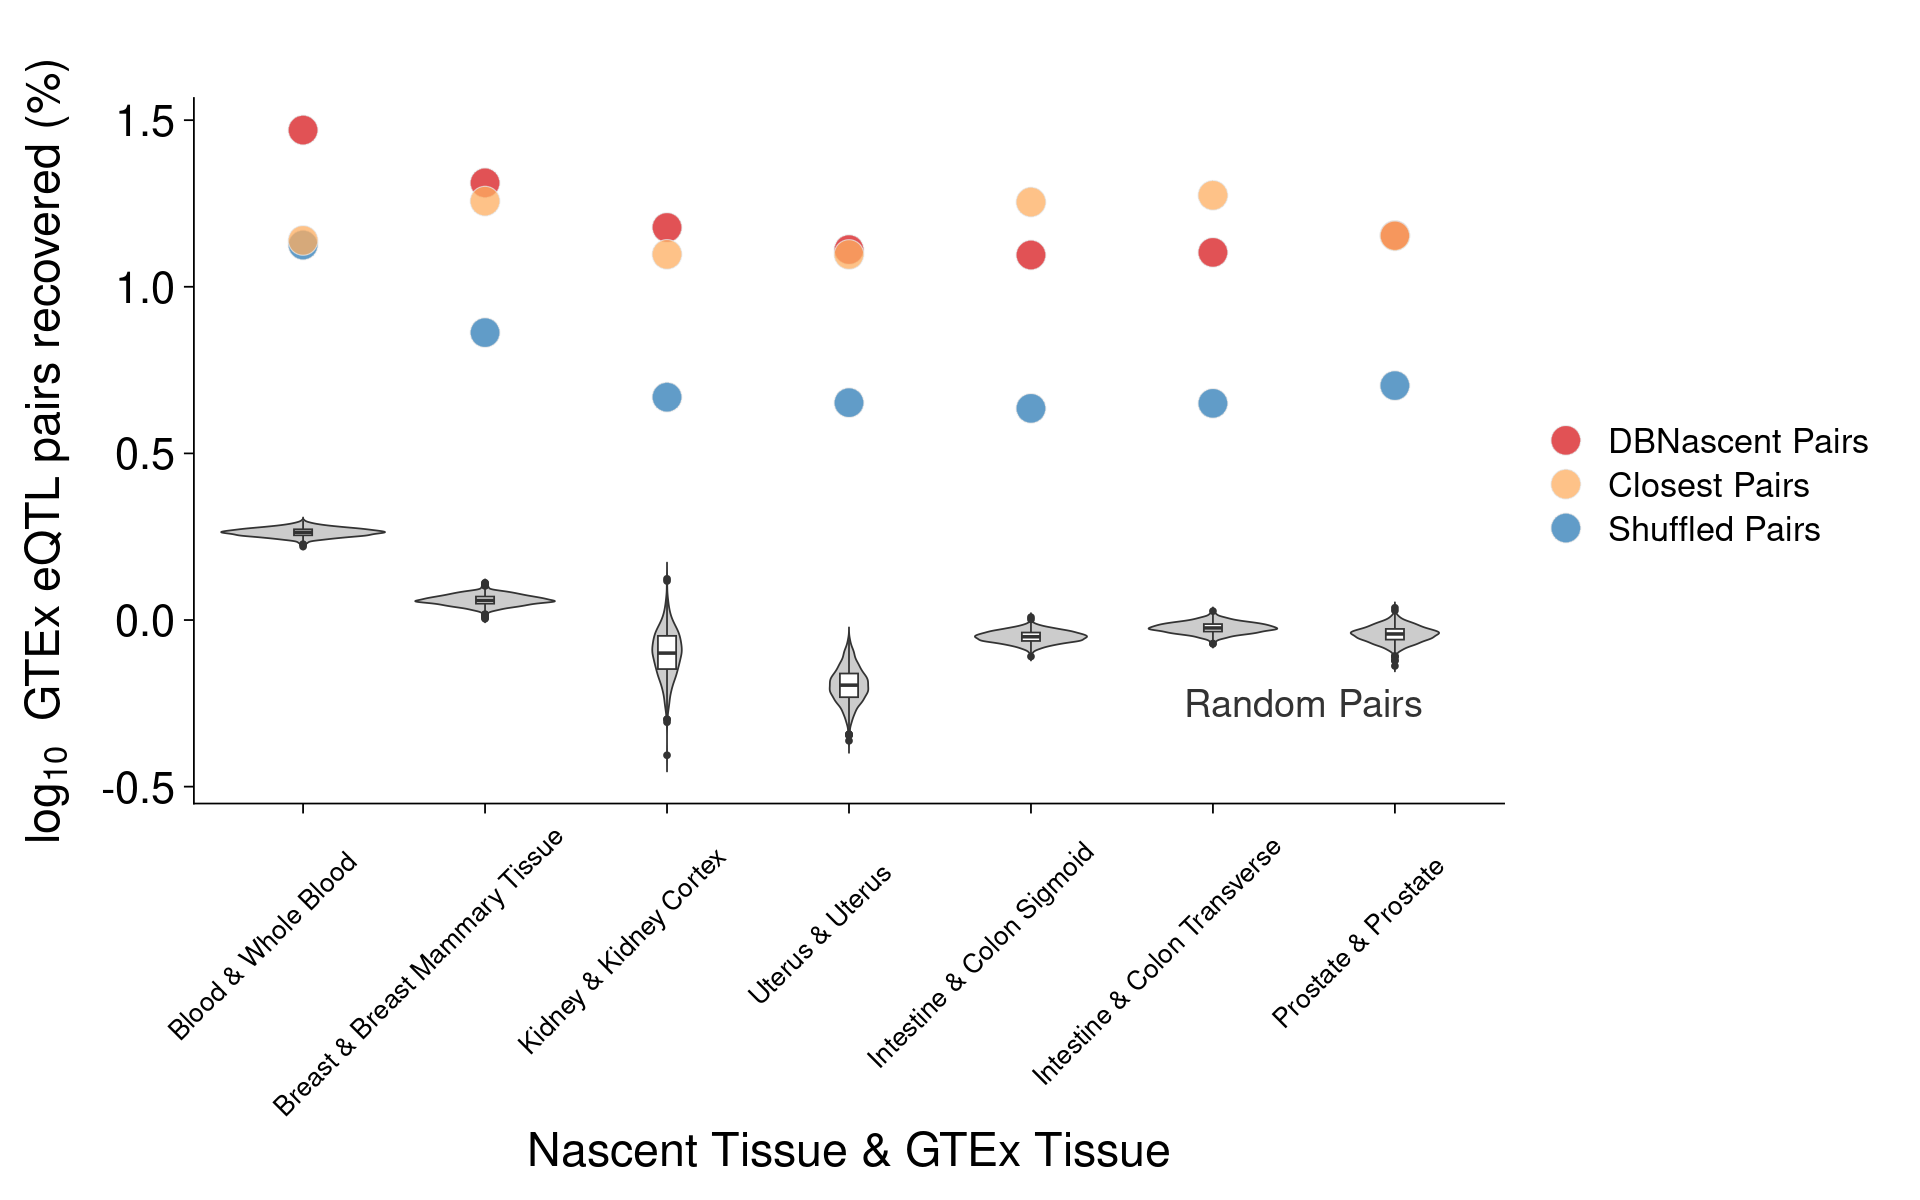

In [104]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sort_filt <- ggplot(overlap_bed_DT_tissue_filt, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=all_overlap_summary_tissue_filt, 
           aes(x=tissues, y=log(percent_eqtl, 10), 
               fill=pair_type),
           shape= 21,
           color="gray90",
           size=8,
           alpha=0.75) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue",
        fill = " ") +
annotate(geom="text",
         x=6.5, 
         y=-0.25, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_fill_manual(values = c("#d7191c","#fdae61","#2c7bb6")) +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sort_filt

Warning message:
“Removed 35 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 21 rows containing missing values or values outside the scale range
(`geom_point()`).”


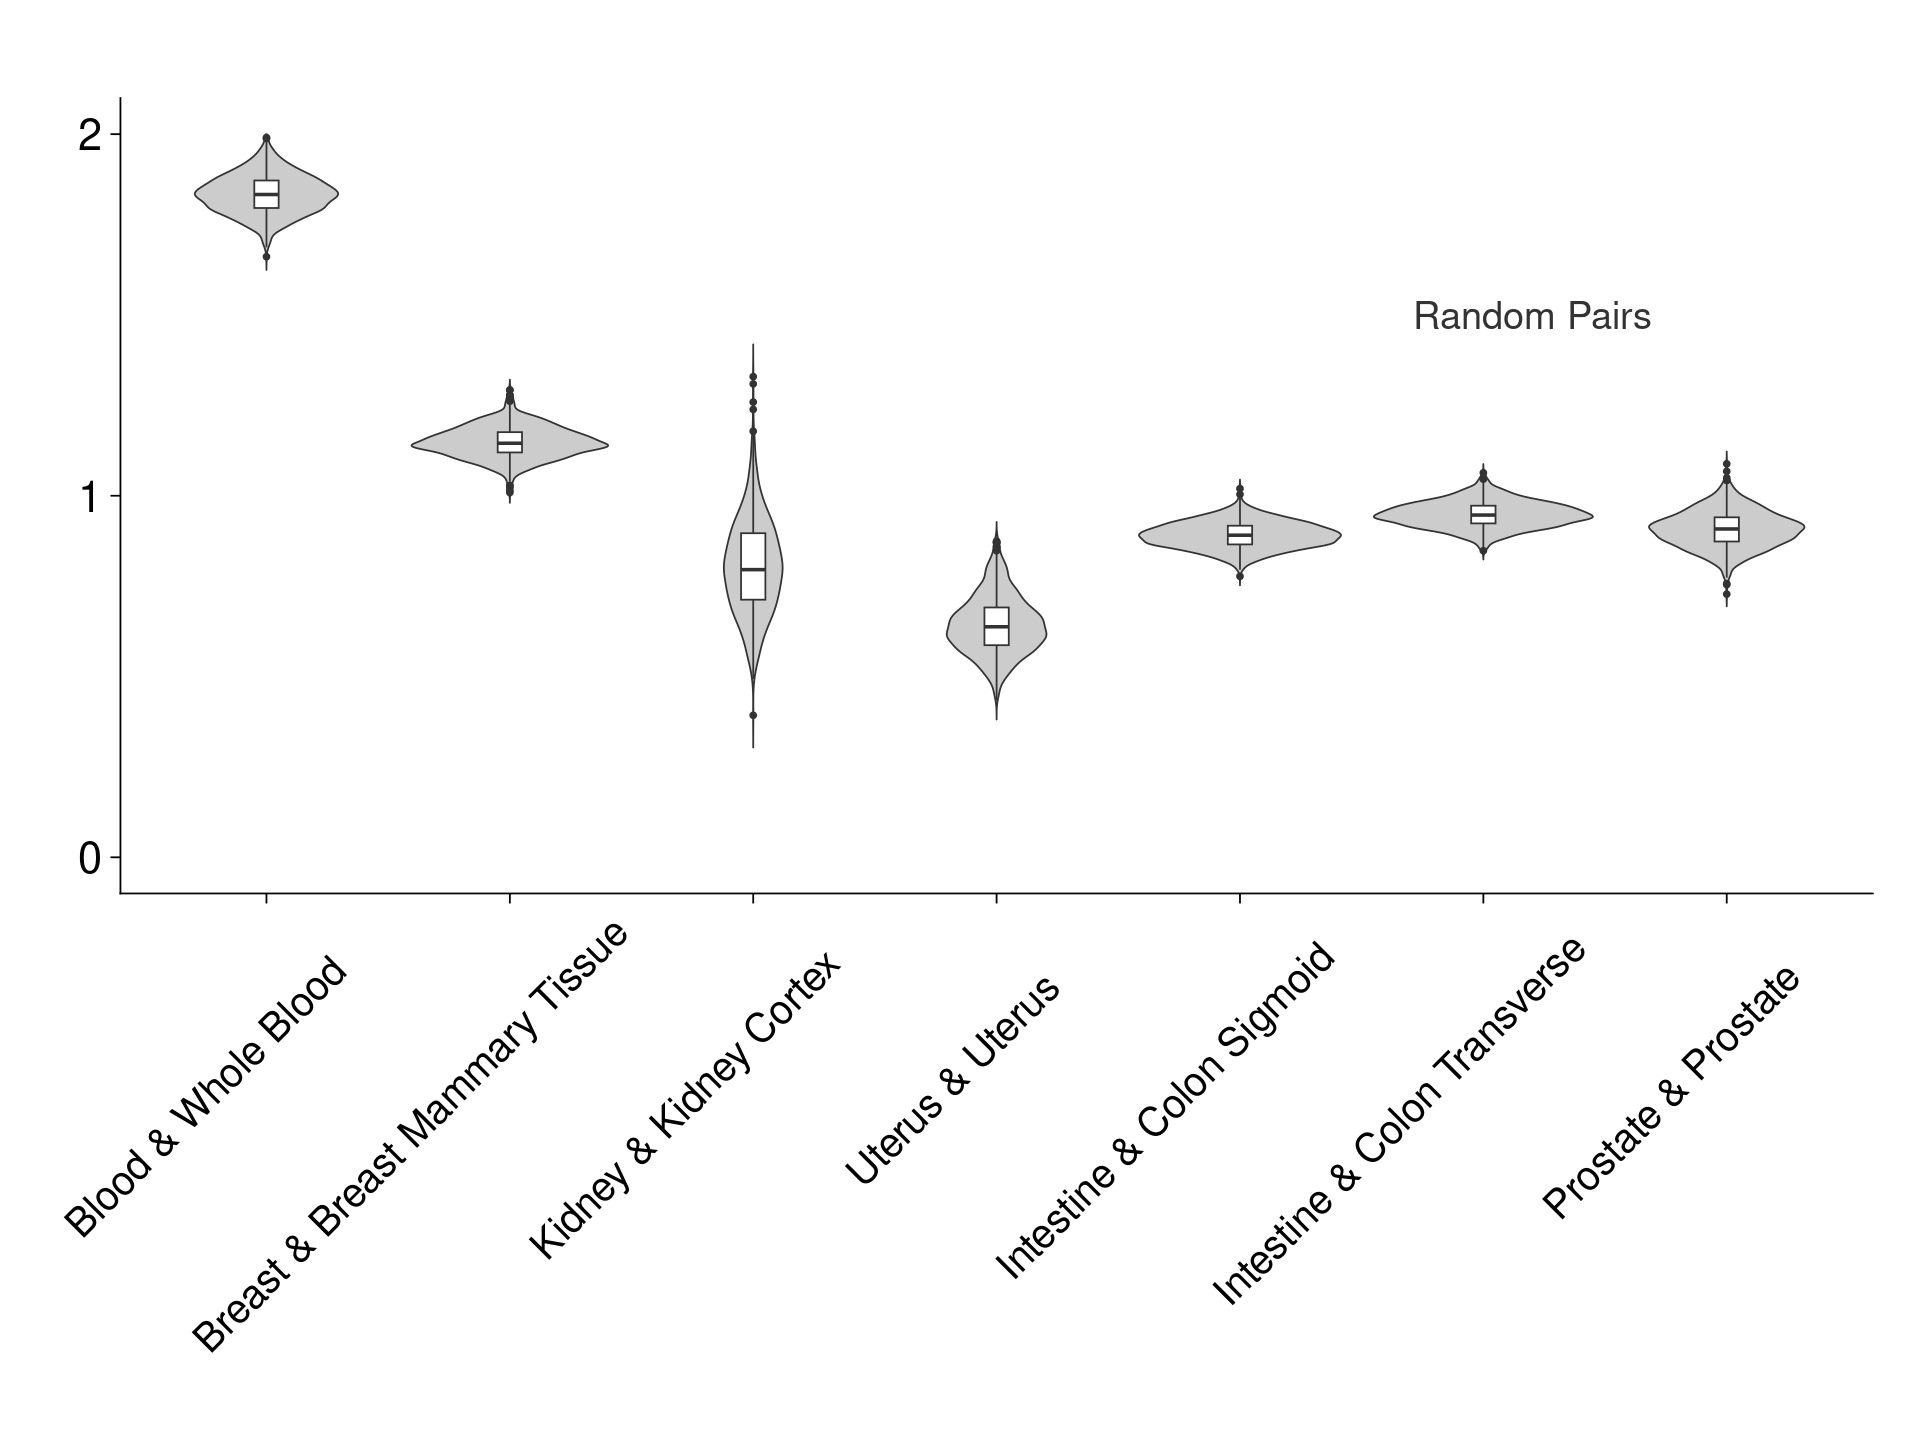

In [105]:
options(repr.plot.width=16, repr.plot.height=12)

# Use single color
overlap_plot_log_sort_filt_splitB <- ggplot(overlap_bed_DT_tissue_filt, aes(x=tissues, y=percent_eqtl)) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=all_overlap_summary_tissue_filt, 
           aes(x=tissues, y=percent_eqtl, 
               fill=pair_type),
           shape= 21,
           color="gray90",
           size=8,
           alpha=0.75) +
labs(title = " ", 
       y =  " ", 
       x = " ",
        fill = " ") +
annotate(geom="text",
         x=6.2, 
         y=1.5, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_fill_manual(values = c("#d7191c","#fdae61","#2c7bb6")) +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks=c(0,1,2),
                   limits=c(0,2)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 24, angle=45, vjust=0.75, hjust=0.75),
     legend.position = "none") +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sort_filt_splitB

Warning message:
“Removed 7000 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message in max(data$density, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`.
Caused by error in `$<-.data.frame`:
! replacement has 1 row, data has 0”
Warning message:
“Removed 7000 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


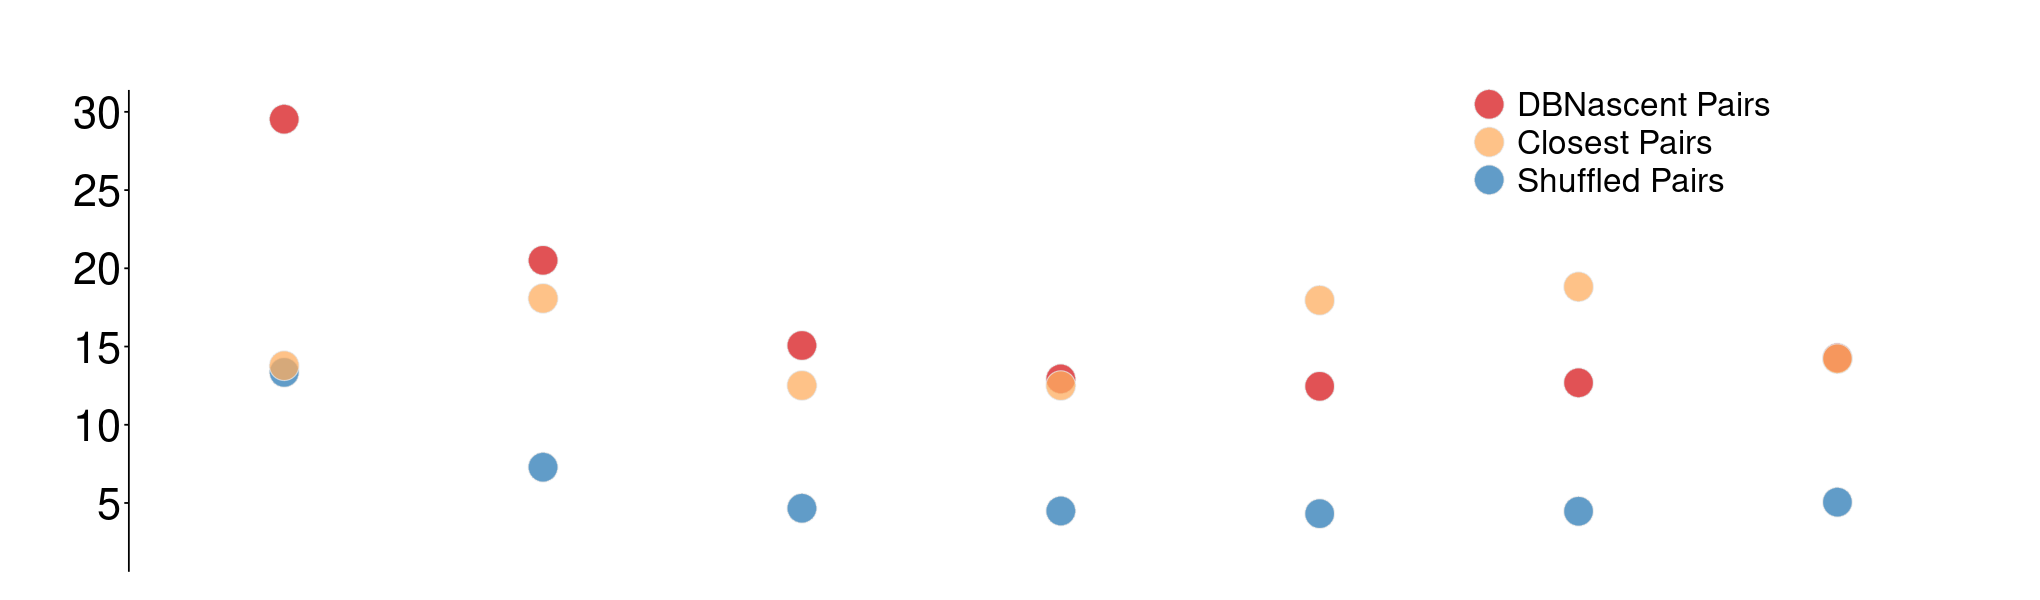

In [106]:
options(repr.plot.width=17, repr.plot.height=5)

# Use single color
overlap_plot_log_sort_filt_splitA <- ggplot(overlap_bed_DT_tissue_filt, aes(x=tissues, y=percent_eqtl)) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=all_overlap_summary_tissue_filt, 
           aes(x=tissues, y=percent_eqtl, 
               fill=pair_type),
           shape= 21,
           color="gray90",
           size=8,
           alpha=0.75) +
labs(title = " ", 
       y =  " ", 
       x = " ",
        fill = " ") +
annotate(geom="text",
         x=6.5, 
         y=-0.25, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_fill_manual(values = c("#d7191c","#fdae61","#2c7bb6")) +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks = seq(0, 30, 5),
                  limits=c(2,30)) +
theme_bw() +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.grid.minor = element_blank()) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm")) +
theme(axis.line.y = element_line(color = "black"), 
        axis.ticks.y = element_line(color = "black"),
        axis.text.y = element_text(color = "black"), 
        axis.title.y = element_text(color = "black")) +
theme(legend.position = "inside", 
      legend.position.inside = c(0.8, 0.95),
      legend.text=element_text(size=20))

overlap_plot_log_sort_filt_splitA

Warning message:
“Removed 7000 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message in max(data$density, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`.
Caused by error in `$<-.data.frame`:
! replacement has 1 row, data has 0”
Warning message:
“Removed 7000 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 35 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 21 rows containing missing values or values outside the scale range
(`geom_point()`).”


TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]

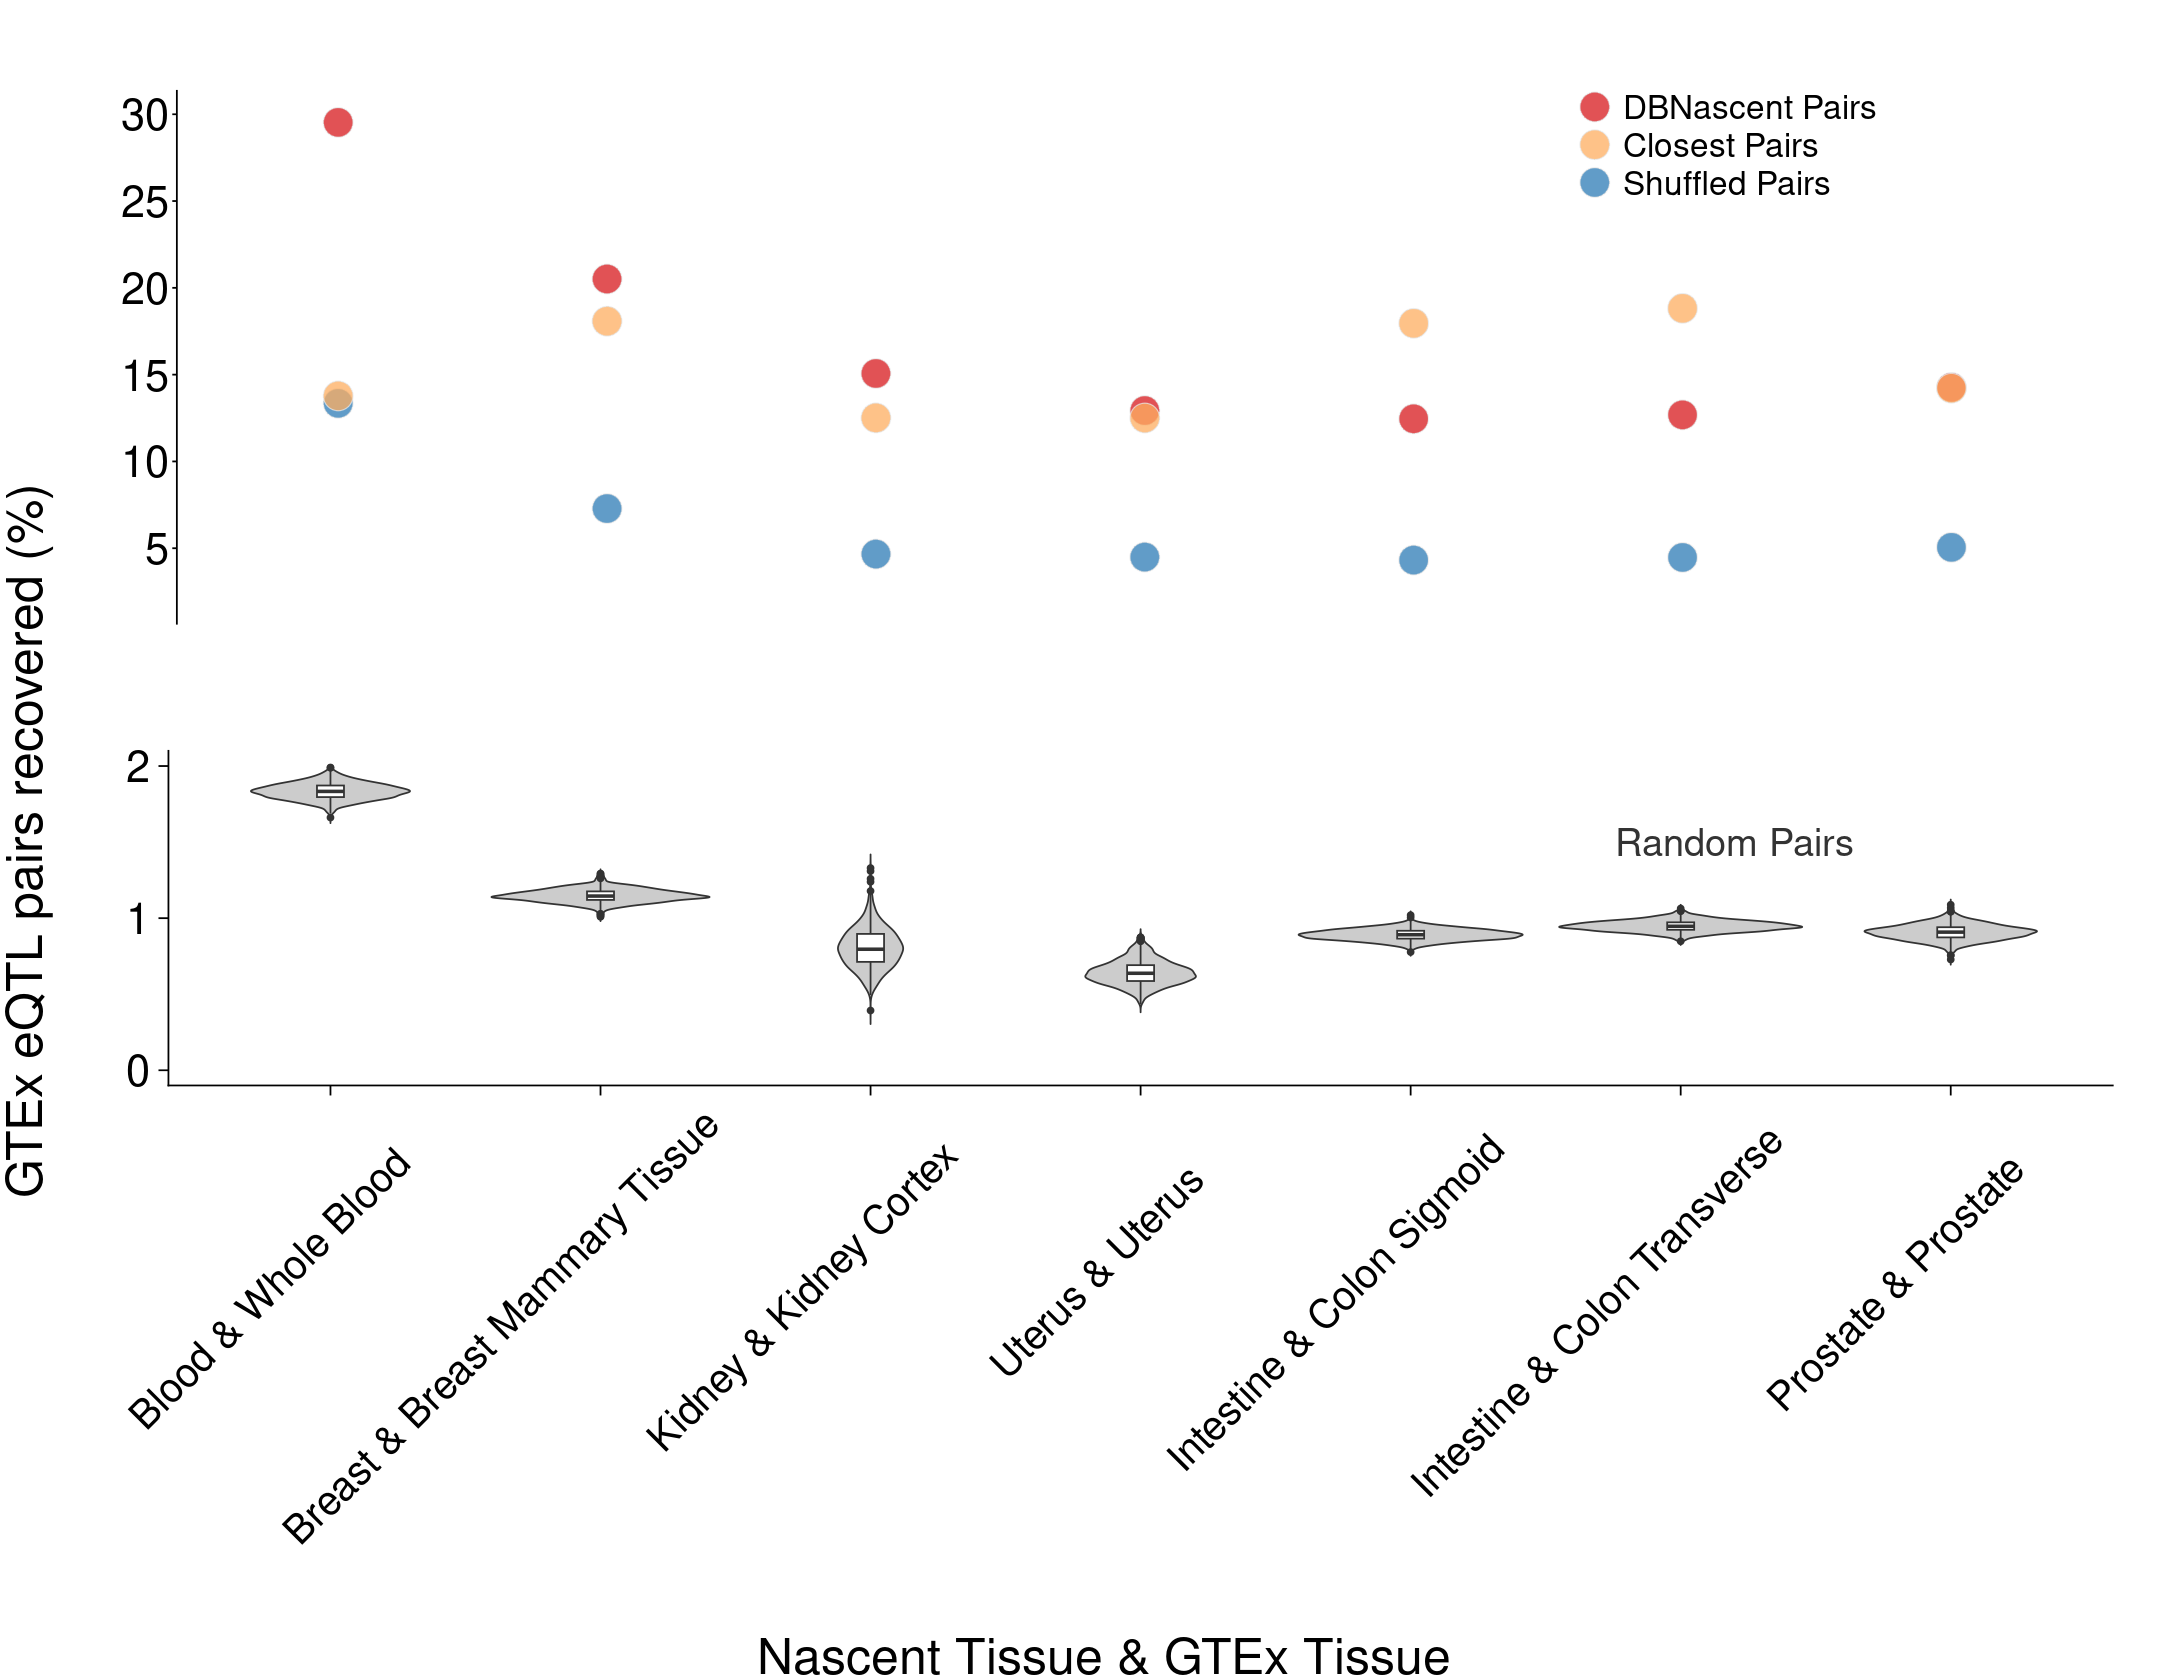

In [107]:
options(repr.plot.width=18, repr.plot.height=14)

plot<-plot_grid(overlap_plot_log_sort_filt_splitA,
                overlap_plot_log_sort_filt_splitB, ncol = 1,
               rel_heights = c(1, 1.5))

#create common x and y labels

y.grob <- textGrob("GTEx eQTL pairs recovered (%)", 
                   gp=gpar(fontface="plain", col="black", fontsize=30), rot=90)

x.grob <- textGrob("Nascent Tissue & GTEx Tissue", 
                   gp=gpar(fontface="plain", col="black", fontsize=30))

#add to plot

plot_gtex_overlaps <- grid.arrange(arrangeGrob(plot, left = y.grob, bottom = x.grob))
plot_gtex_overlaps 

In [108]:
ggsave(plot_gtex_overlaps, width = 18, height = 14,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_plot_reviews.pdf',
      bg = "transparent")

ggsave(plot_gtex_overlaps, width = 18, height = 14,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_plot_reviews.png',
      bg = "transparent")

ggsave(plot_gtex_overlaps, width = 18, height = 14,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_plot_reviews.svg',
      bg = "transparent")

### Complete plots

Warning message:
“Removed 12000 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message in max(data$density, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`.
Caused by error in `$<-.data.frame`:
! replacement has 1 row, data has 0”
Warning message:
“Removed 12000 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


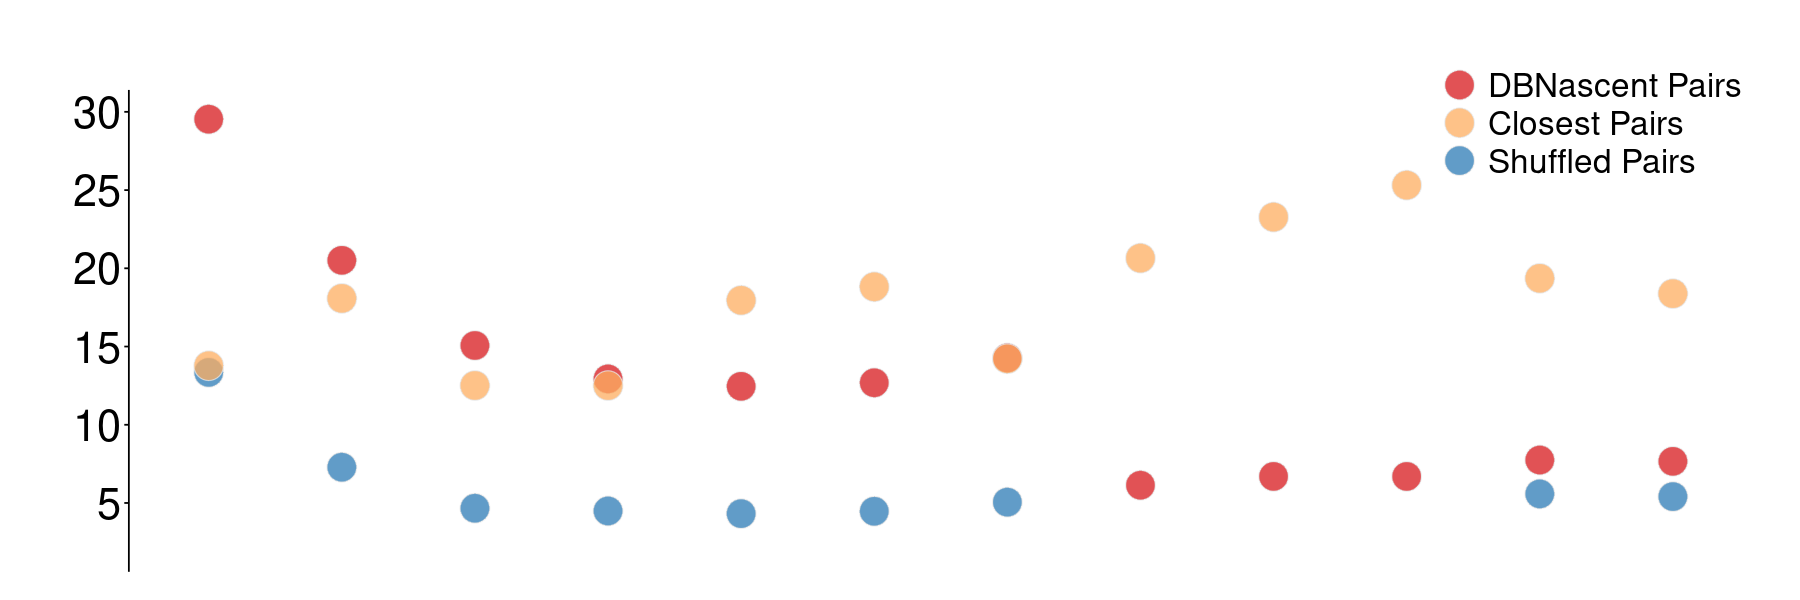

In [109]:
options(repr.plot.width=15, repr.plot.height=5)

# Use single color
overlap_plot_log_sort_all_splitA <- ggplot(overlap_bed_DT, aes(x=tissues, y=percent_eqtl)) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=all_overlap_summary, 
           aes(x=tissues, y=percent_eqtl, 
               fill=pair_type),
           shape= 21,
           color="gray90",
           size=8,
           alpha=0.75) +
labs(title = " ", 
       y =  " ", 
       x = " ",
        fill = " ") +
annotate(geom="text",
         x=6.5, 
         y=-0.25, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_fill_manual(values = c("#d7191c","#fdae61","#2c7bb6")) +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks = seq(0, 30, 5),
                  limits=c(2,30)) +
theme_bw() +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.grid.minor = element_blank()) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm")) +
theme(axis.line.y = element_line(color = "black"), 
        axis.ticks.y = element_line(color = "black"),
        axis.text.y = element_text(color = "black"), 
        axis.title.y = element_text(color = "black")) +
theme(legend.position = "inside", 
      legend.position.inside = c(0.9, 0.99),
      legend.text=element_text(size=20))

overlap_plot_log_sort_all_splitA

Warning message:
“Removed 33 rows containing missing values or values outside the scale range
(`geom_point()`).”


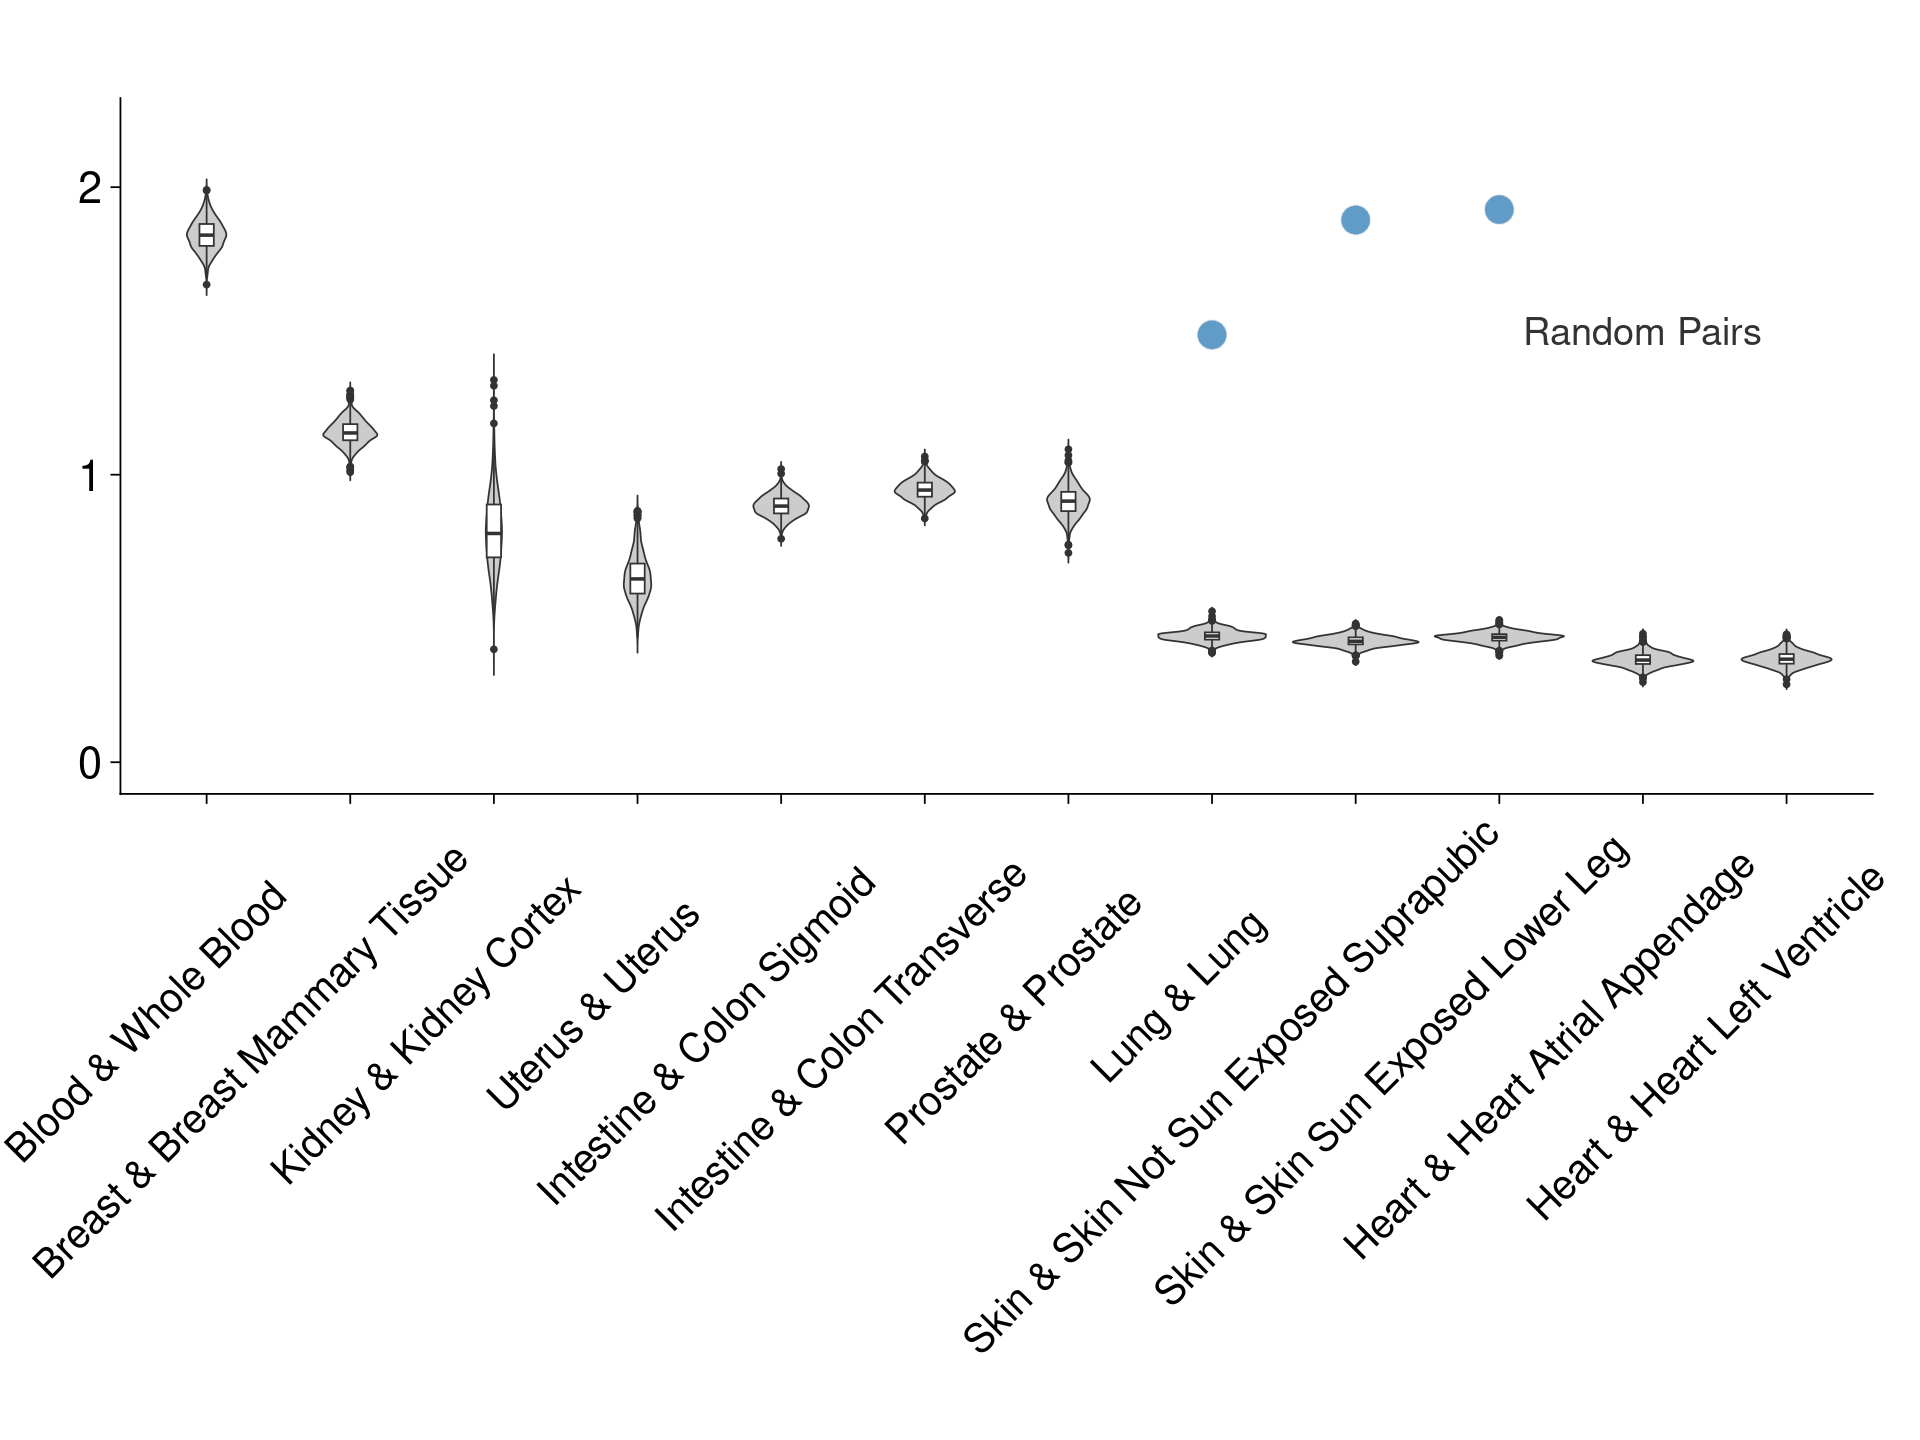

In [110]:
options(repr.plot.width=16, repr.plot.height=12)

# Use single color
overlap_plot_log_sort_all_splitB <- ggplot(overlap_bed_DT, aes(x=tissues, y=percent_eqtl)) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=all_overlap_summary, 
           aes(x=tissues, y=percent_eqtl, 
               fill=pair_type),
           shape= 21,
           color="gray90",
           size=8,
           alpha=0.75) +
labs(title = " ", 
       y =  " ", 
       x = " ",
        fill = " ") +
annotate(geom="text",
         x=11, 
         y=1.5, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_fill_manual(values = c("#d7191c","#fdae61","#2c7bb6")) +
scale_x_discrete(labels = tissue_names) +
scale_y_continuous(breaks=c(0,1,2),
                   limits=c(0,2.2)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 24, angle=45, vjust=0.75, hjust=0.75),
     legend.position = "none") +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sort_all_splitB

Warning message:
“Removed 12000 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message in max(data$density, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`.
Caused by error in `$<-.data.frame`:
! replacement has 1 row, data has 0”
Warning message:
“Removed 12000 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 33 rows containing missing values or values outside the scale range
(`geom_point()`).”


TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]

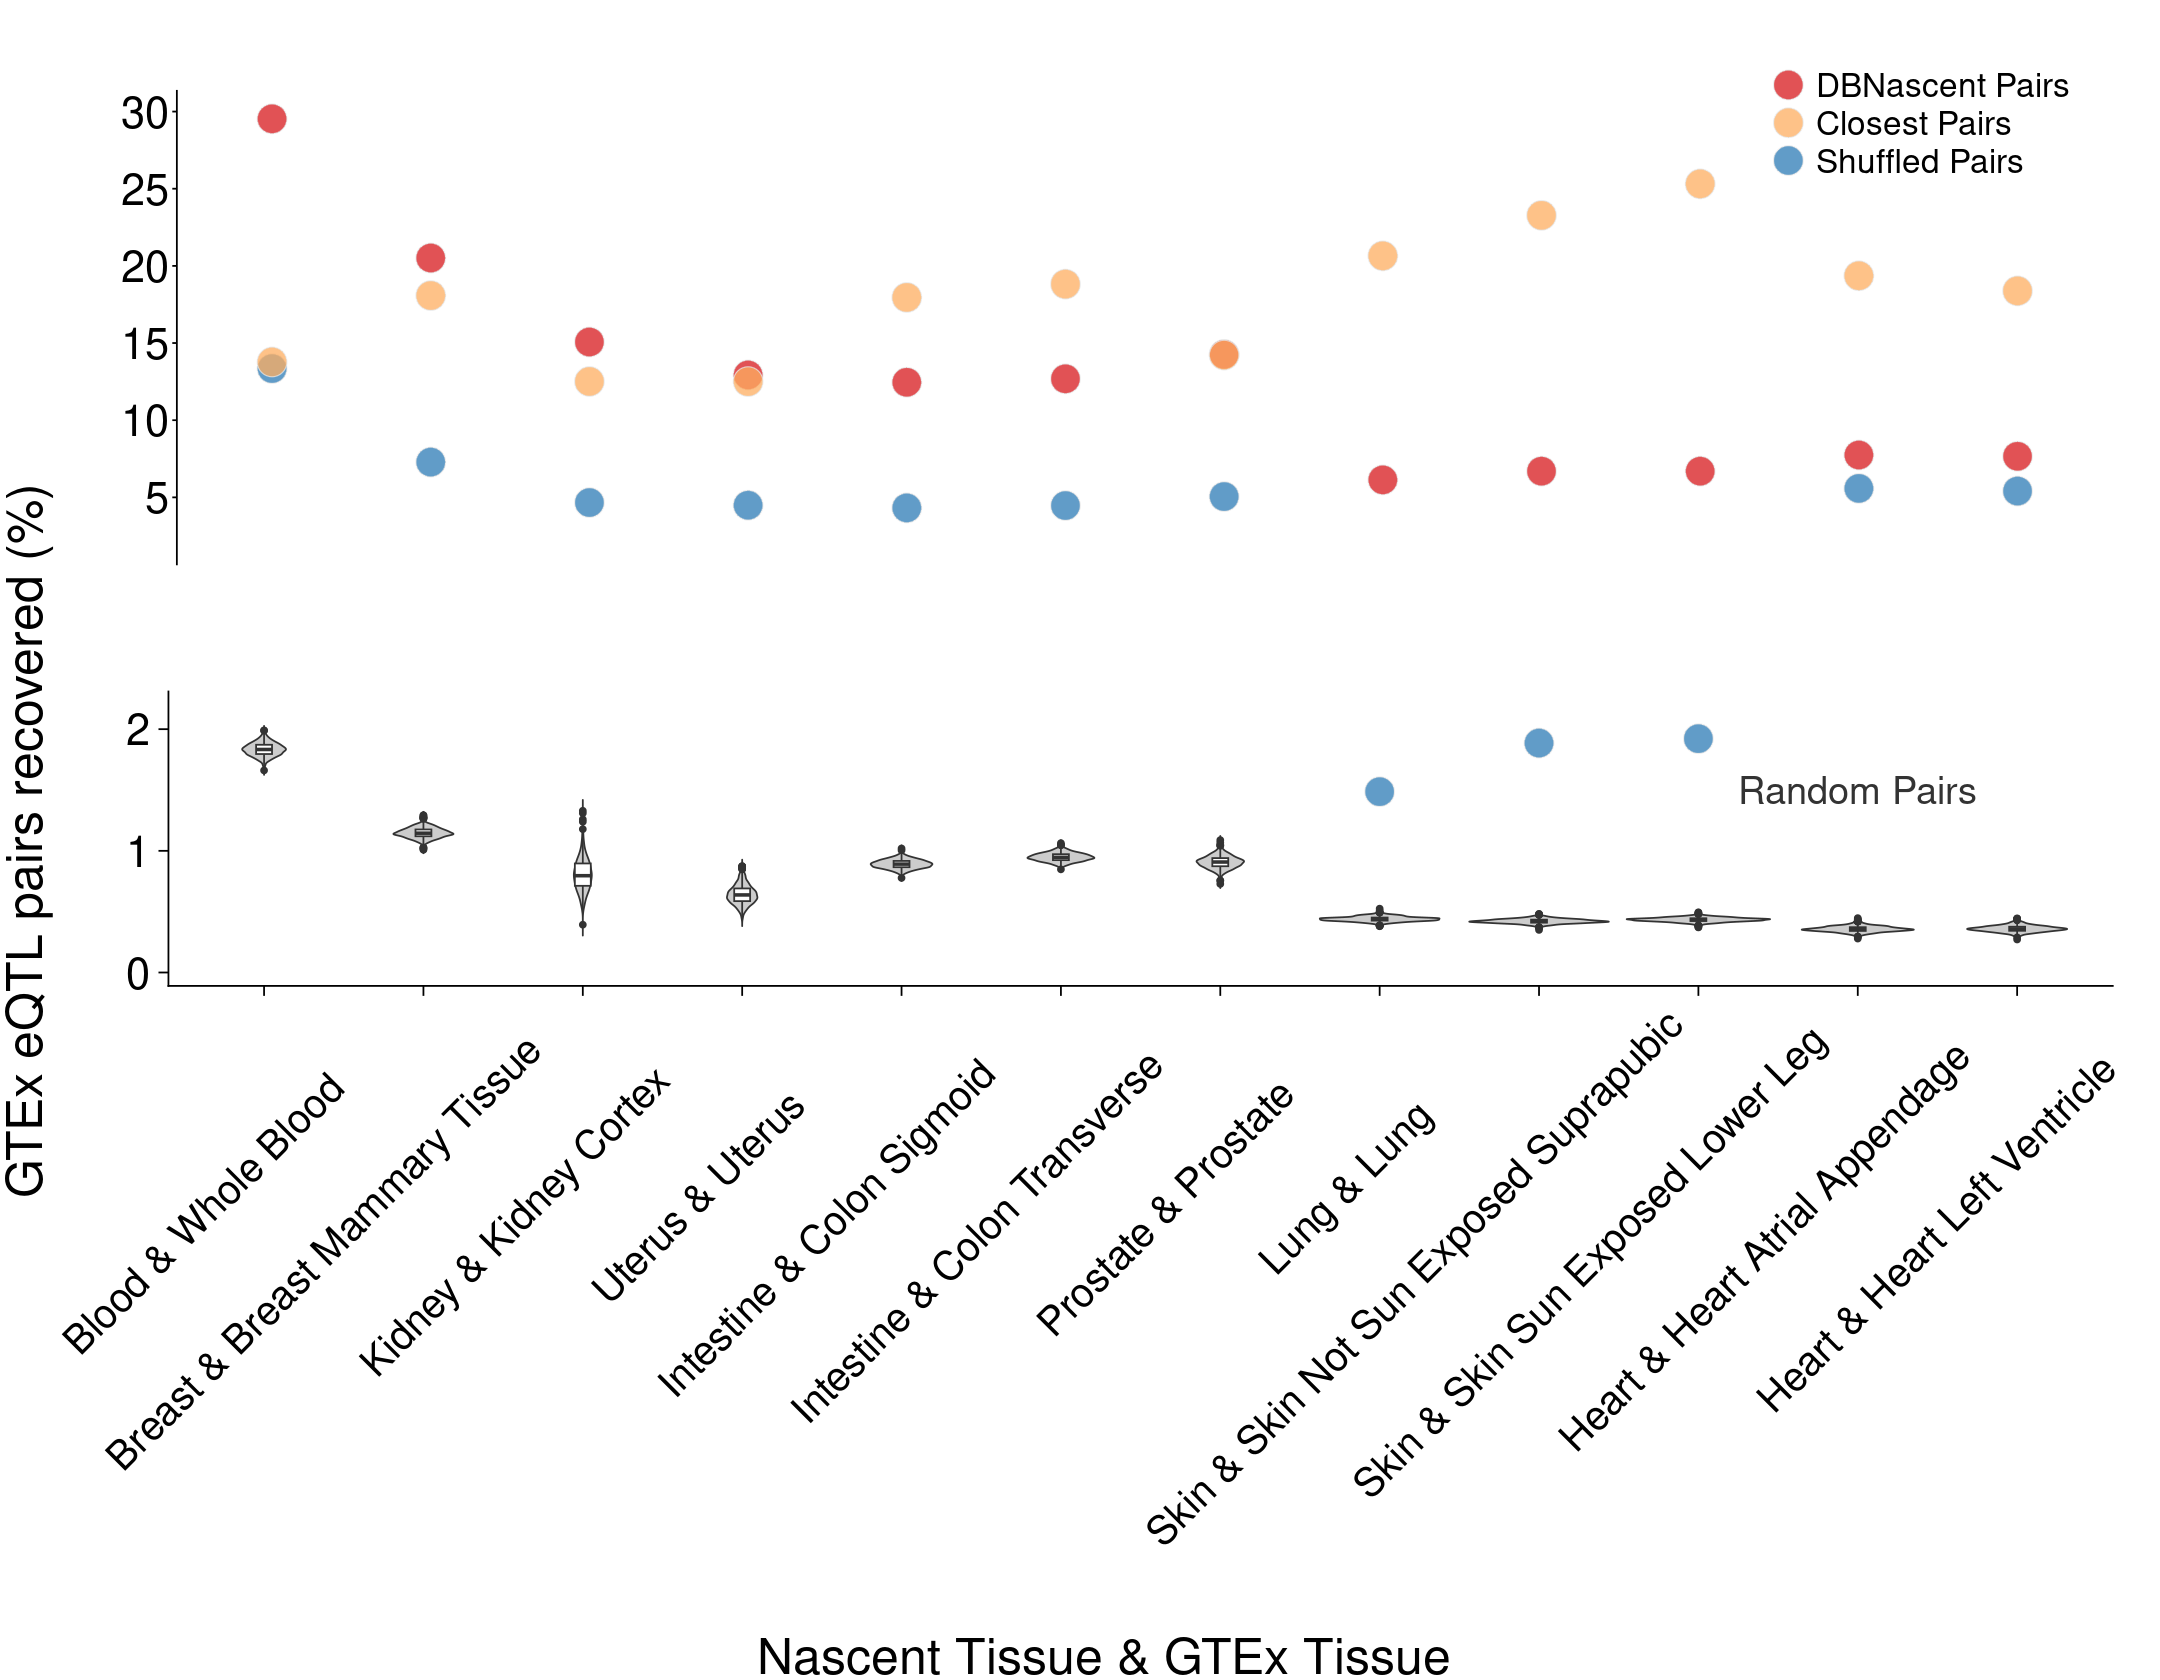

In [111]:
options(repr.plot.width=18, repr.plot.height=14)

plot_all <-plot_grid(overlap_plot_log_sort_all_splitA,
                overlap_plot_log_sort_all_splitB, ncol = 1,
               rel_heights = c(1, 1.75))

#create common x and y labels

y.grob <- textGrob("GTEx eQTL pairs recovered (%)", 
                   gp=gpar(fontface="plain", col="black", fontsize=30), rot=90)

x.grob <- textGrob("Nascent Tissue & GTEx Tissue", 
                   gp=gpar(fontface="plain", col="black", fontsize=30))

#add to plot

plot_gtex_overlaps_all <- grid.arrange(arrangeGrob(plot_all, left = y.grob, bottom = x.grob))
plot_gtex_overlaps_all 

In [112]:
ggsave(plot_gtex_overlaps_all, width = 18, height = 14,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_all_plot_reviews.pdf',
      bg = "transparent")

ggsave(plot_gtex_overlaps_all, width = 18, height = 14,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_all_plot_reviews.png',
      bg = "transparent")

ggsave(plot_gtex_overlaps_all, width = 18, height = 14,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gtex_overlaps_all_plot_reviews.svg',
      bg = "transparent")

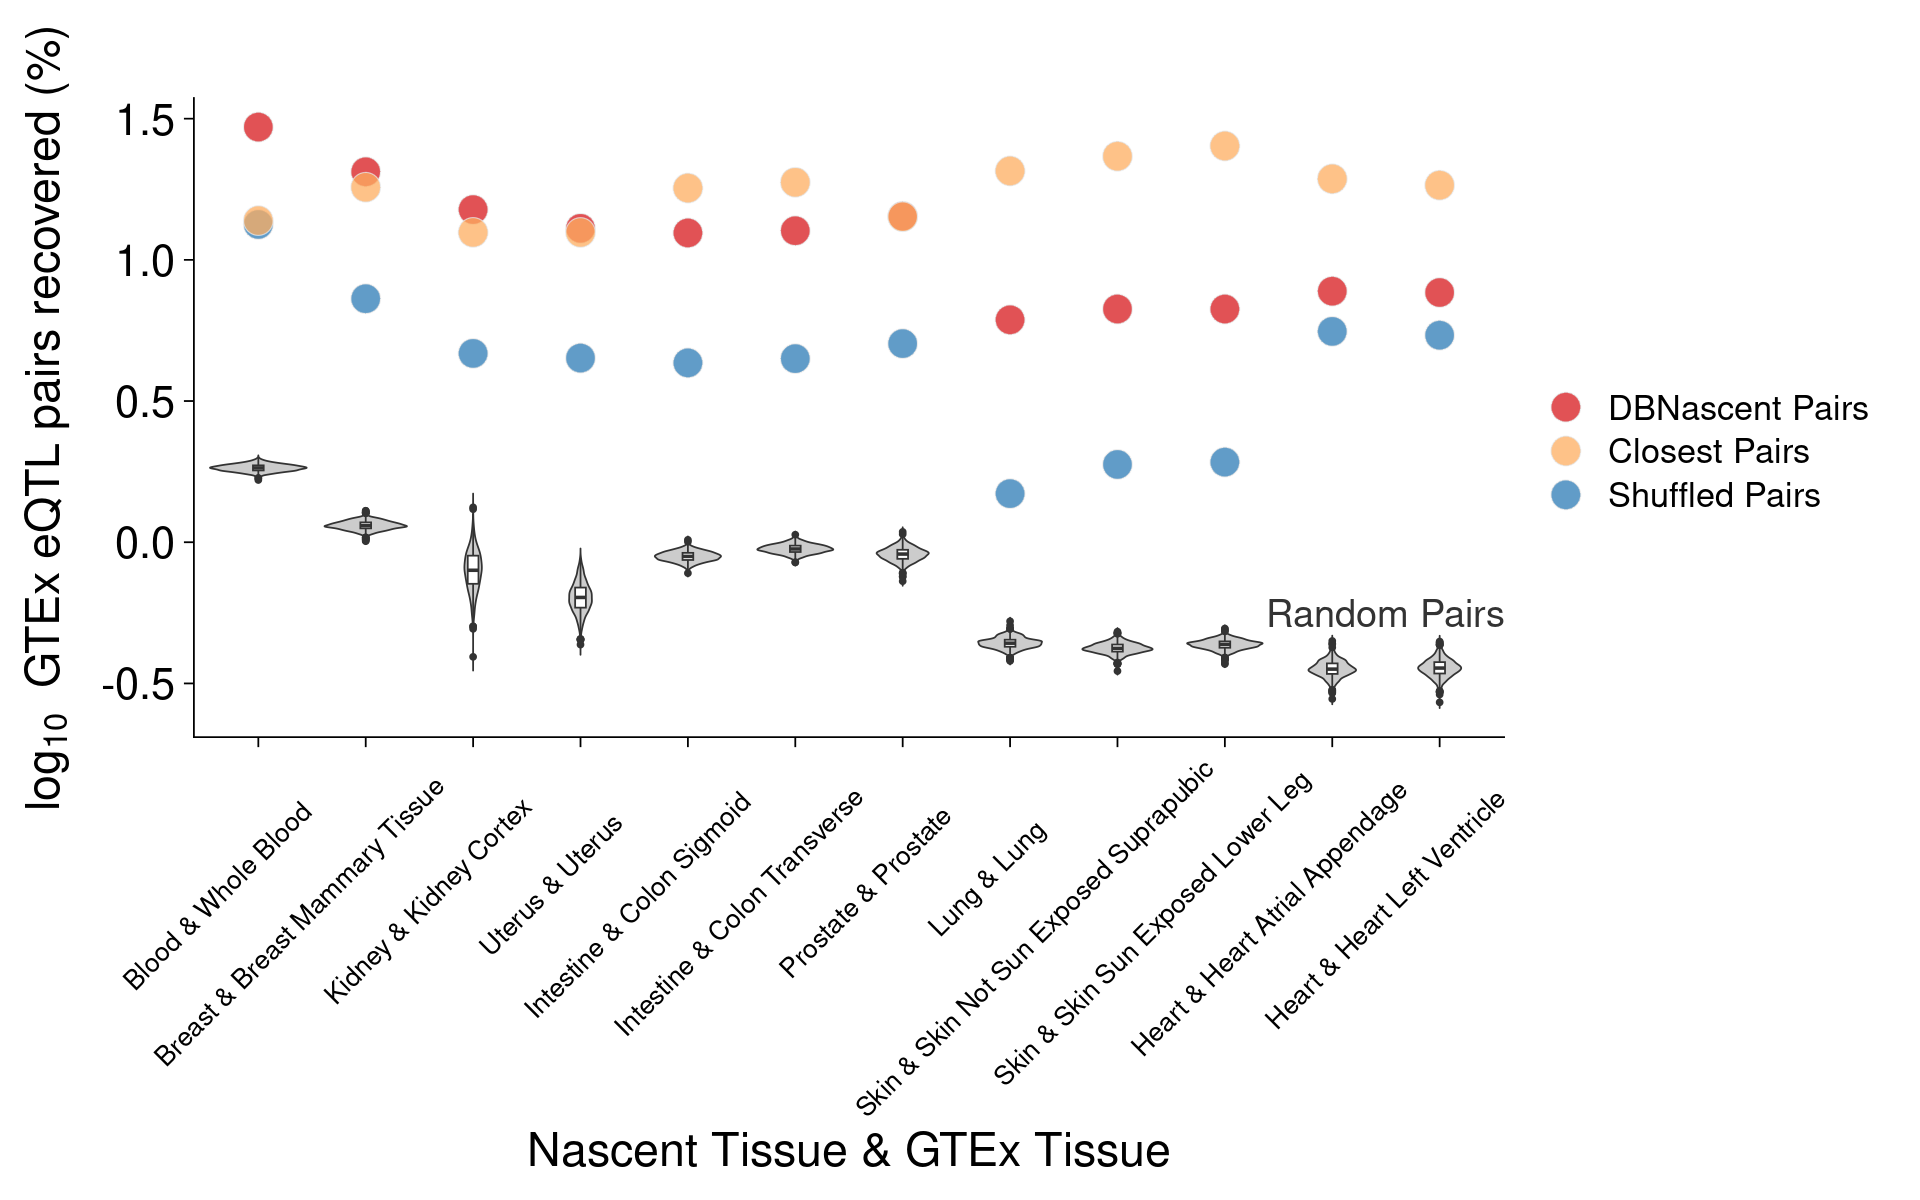

In [113]:
options(repr.plot.width=16, repr.plot.height=10)

# Use single color
overlap_plot_log_sort_all <- ggplot(overlap_bed_DT, aes(x=tissues, y=log(percent_eqtl, 10))) +
  geom_violin(trim=FALSE, fill='gray80', color="gray20")+
  geom_boxplot(width=0.1) + 
geom_point(data=all_overlap_summary, 
           aes(x=tissues, y=log(percent_eqtl, 10), 
               fill=pair_type),
           shape= 21,
           color="gray90",
           size=8,
           alpha=0.75) +
labs(title = " ", 
       y =  expression("log"["10"] ~ " GTEx eQTL pairs recovered (%)"), #"log10 GTEx eQTL pairs recovered (%)",
       x = "Nascent Tissue & GTEx Tissue",
        fill = " ") +
annotate(geom="text",
         x=11.5, 
         y=-0.25, 
         size=8,
         label="Random Pairs",
         color="gray20") +
scale_fill_manual(values = c("#d7191c","#fdae61","#2c7bb6")) +
scale_x_discrete(labels = tissue_names) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 16, angle=45, vjust=0.75, hjust=0.75)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plot_log_sort_all

# Session Information

In [115]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] svglite_2.1.3     gridExtra_2.3     cowplot_1.1.3     dplyr_1.1.4      
[5] ggplot2_3.5.1     data.table_1.16.2

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.8.9    compiler_4.4.0    crayon_1.5.3     
 [